<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h4> Problem statement : </h4>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>



<h4>Real-world/Business objectives and constraints.</h4>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

#### Our constraints
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

In [1]:
# To ginore the Warnings
import warnings
warnings.filterwarnings(action='ignore')

#To Data Manipulation and perform Matrix operations 
import numpy as np
import pandas as pd

#Plotting Libarries 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
%matplotlib inline


#To check missing Values
import missingno as msn

import re
from nltk.corpus import stopwords

import tqdm

# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix


from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

from collections import Counter, defaultdict
from scipy.sparse import coo_matrix, hstack
from tabulate import tabulate

from prettytable import PrettyTable

from sklearn.decomposition import TruncatedSVD

<h2>Data Exraction</h2>

<h3>Reading Variants Data</h3>

In [2]:
variants_df = pd.read_csv('training_variants')
print("Number of observaions and features in the  variants data set is :",variants_df.shape)
print("List of features in the variants data set is:",variants_df.columns)

Number of observaions and features in the  variants data set is : (3321, 4)
List of features in the variants data set is: Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')


<h3>Reading Text Data</h3>

In [3]:
text_df =pd.read_csv("training_text",sep="\|\|",names=["ID","Text"],skiprows=1)
print("Number of observaions and features in the  Text data set is :",text_df.shape)
print("List of features in the Text data set is:",text_df.columns)

Number of observaions and features in the  Text data set is : (3321, 2)
List of features in the Text data set is: Index(['ID', 'Text'], dtype='object')


### Merging the Variants and Text data sets

In [4]:
cancer_df=pd.merge(variants_df,text_df,on='ID',how='left')
print("Number of observaions and features in the  Cancer set is :",cancer_df.shape)
print("List of features in the Cancer data set is:",cancer_df.columns)
cancer_df.head()

Number of observaions and features in the  Cancer set is : (3321, 5)
List of features in the Cancer data set is: Index(['ID', 'Gene', 'Variation', 'Class', 'Text'], dtype='object')


ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...

In [5]:
#move the  Target variable to the end
save_class=cancer_df.pop('Class')
save_text=cancer_df.pop('Text')
cancer_df['Text']=save_text
cancer_df['Class']=save_class
cancer_df.head()

ID    Gene             Variation  \
0   0  FAM58A  Truncating Mutations   
1   1     CBL                 W802*   
2   2     CBL                 Q249E   
3   3     CBL                 N454D   
4   4     CBL                 L399V   

                                                Text  Class  
0  Cyclin-dependent kinases (CDKs) regulate a var...      1  
1   Abstract Background  Non-small cell lung canc...      2  
2   Abstract Background  Non-small cell lung canc...      2  
3  Recent evidence has demonstrated that acquired...      3  
4  Oncogenic mutations in the monomeric Casitas B...      4

<h2>Data Preprocessing </h2>

### Check for Class Balance

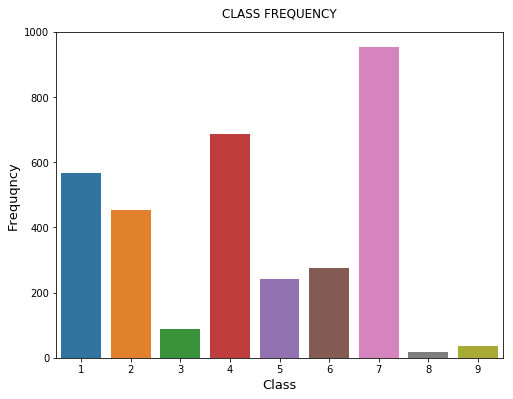

In [6]:
plt.figure(figsize=(8,6))
sns.countplot(x='Class',data=cancer_df)
plt.title('Class frequency'.upper(),pad=15,fontdict={'size':12})
plt.xlabel('Class',fontdict={'size':13})
plt.ylabel('Frequqncy',fontdict={'size':13})
plt.show()

###### observation:  Data set is an imbalanced  dataset with majority class is 7 and minority class is  8 

### Check for null values

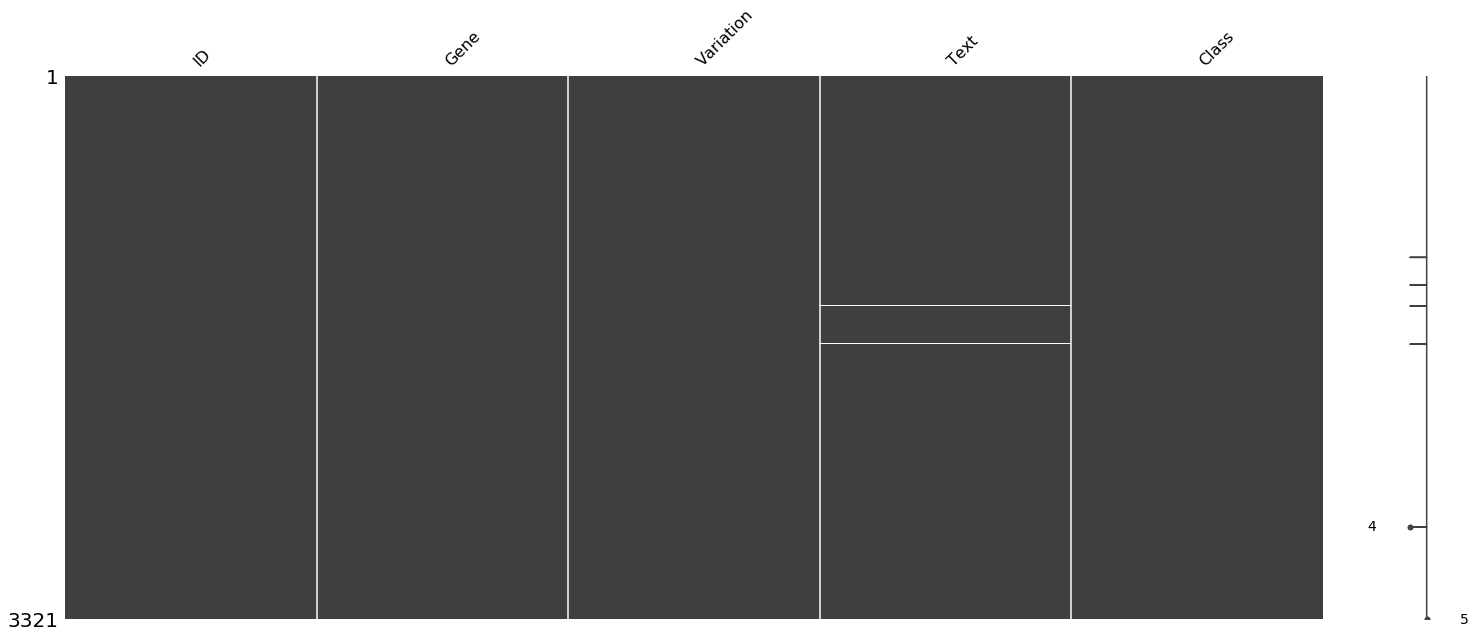

In [7]:
msn.matrix(cancer_df)
plt.show()

###### observation: data set has 5 missing values and all are from text feature

In [8]:
cancer_df[cancer_df['Text'].isnull()]

ID    Gene             Variation Text  Class
1109  1109   FANCA                S1088F  NaN      1
1277  1277  ARID5B  Truncating Mutations  NaN      1
1407  1407   FGFR3                 K508M  NaN      6
1639  1639    FLT1         Amplification  NaN      6
2755  2755    BRAF                 G596C  NaN      7

In [9]:
cancer_df.loc[cancer_df['Text'].isnull(),'Text']=cancer_df['Gene']+' '+cancer_df['Variation']

In [10]:
cancer_df.isnull().sum()

ID           0
Gene         0
Variation    0
Text         0
Class        0
dtype: int64

### Check for redundent data

In [11]:
print('Number of duplicate entires :',np.sum(cancer_df.duplicated()))

Number of duplicate entires : 0


### Text Pre processing

In [12]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def text_preprocessing(sent):
    
    sent=str(sent).lower()
    sent=sent.replace("′", "'").replace("’", "'")
    
    sent = re.sub(r"won't", "will not", sent)
    sent = re.sub(r"can\'t", "can not", sent)
    sent = re.sub(r"cannot", "can not", sent)

    # general
    sent = re.sub(r"n\'t", " not", sent)
    sent = re.sub(r"\'re", " are", sent)
    sent = re.sub(r"\'s", " is", sent)
    sent = re.sub(r"\'d", " would", sent)
    sent = re.sub(r"\'ll", " will", sent)
    sent = re.sub(r"\'t", " not", sent)
    sent = re.sub(r"\'ve", " have", sent)
    sent = re.sub(r"\'m", " am", sent)
    sent = re.sub("what's", "what is",sent)
    sent = re.sub("'ve", "have",sent)
    sent = re.sub("'s", "own",sent)
    
    # replace every special char with space
    sent = re.sub('[^a-zA-Z0-9\n]', ' ', sent)
    # replace multiple spaces with single space
    sent = re.sub('\s+',' ', sent)
    
    string=""
    for word in sent.split():
        # if the word is a not a stop word then retain that word from the data
        if not word in stop_words:
            string += word + " "
            
    return string

In [13]:
cancer_df['Text']=cancer_df['Text'].apply(text_preprocessing)

In [14]:
cancer_df['Gene']= cancer_df['Gene'].str.replace('\s+', '_')

In [15]:
cancer_df['Variation']= cancer_df['Variation'].str.replace('\s+', '_')

In [16]:
def generate_word_cloud_per_class(data_set,feature):
    fig,plots=plt.subplots(3,3,figsize=(15,12))
    mask=np.array(Image.open('Gene.jpg'))
    for row in range(3):
        for col in range(3):
            class_num=(row*3+col)+1
            class_words=data_set[data_set['Class']==class_num][feature].values
            display_words=''
            for word in class_words:
                display_words=display_words+word+' '
            wordcloud = WordCloud(width =250, height = 250,background_color ='white', min_font_size = 10,
                                  stopwords=stop_words,max_words=len(display_words),mask=mask,colormap='Dark2',
                                  collocations = False).generate(display_words)
            plots[row][col].imshow(wordcloud,interpolation='bilinear')
            plots[row][col].axis("off")
            plots[row][col].set_title('class {}'.format(class_num).upper(),fontdict={'size':15},pad=10)
    plt.show()

In [17]:
def print_cummulative_histogram(data_frame,feature):
    
    unique_cat = data_frame[feature].value_counts()
    print('Number of Unique {} : is {} '.format(feature, unique_cat.shape[0]))
    # the top 10 genes that occured most
    print(unique_cat.head(10))
    print("There are {} different categories  in the {} feature and """.format(unique_cat.shape[0],feature),end="")
    
    print("The distribution is follow as")

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    s = sum(unique_cat.values);
    h = unique_cat.values/s;
    plt.plot(h, label="Histrogram of  {}".format(feature))
    plt.xlabel('Index of a {}'.format(feature))
    plt.ylabel('Number of Occurances')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    c = np.cumsum(h)
    plt.plot(c,label='Cumulative distribution of {} '.format(feature))
    plt.xlabel('{} category index'.format(feature))
    plt.ylabel('Cummulative sum')

    plt.legend()
    plt.grid()

    
    plt.figure(figsize=(10,5))
    index=list(unique_cat.index)[:10]
    values=list(unique_cat.values)[:10]
    sns.barplot(values,index)
    plt.xlabel("frequency",fontdict={'size':12})
    plt.ylabel("category",fontdict={'size':12})
    plt.show()
    


Number of Unique Gene : is 264 
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64
There are 264 different categories  in the Gene feature and The distribution is follow as


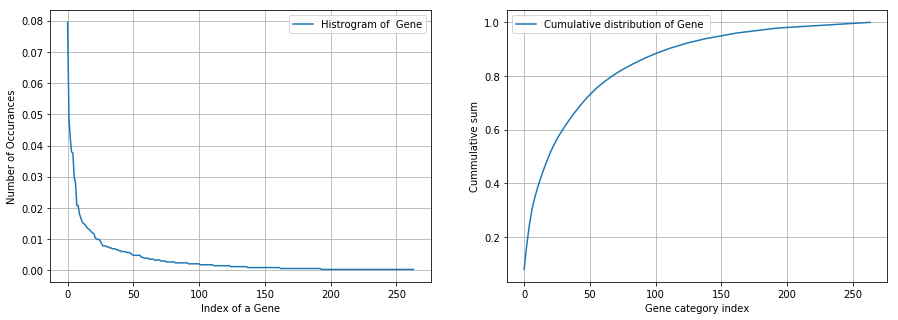

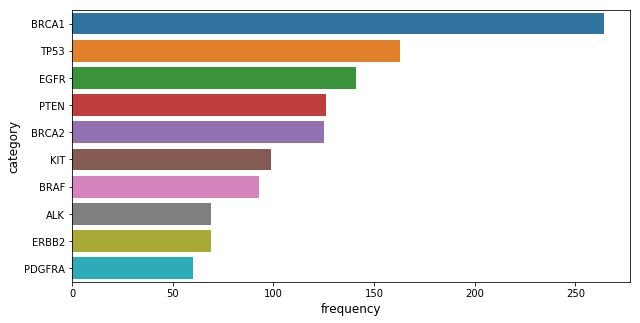

In [18]:
print_cummulative_histogram(cancer_df,'Gene')

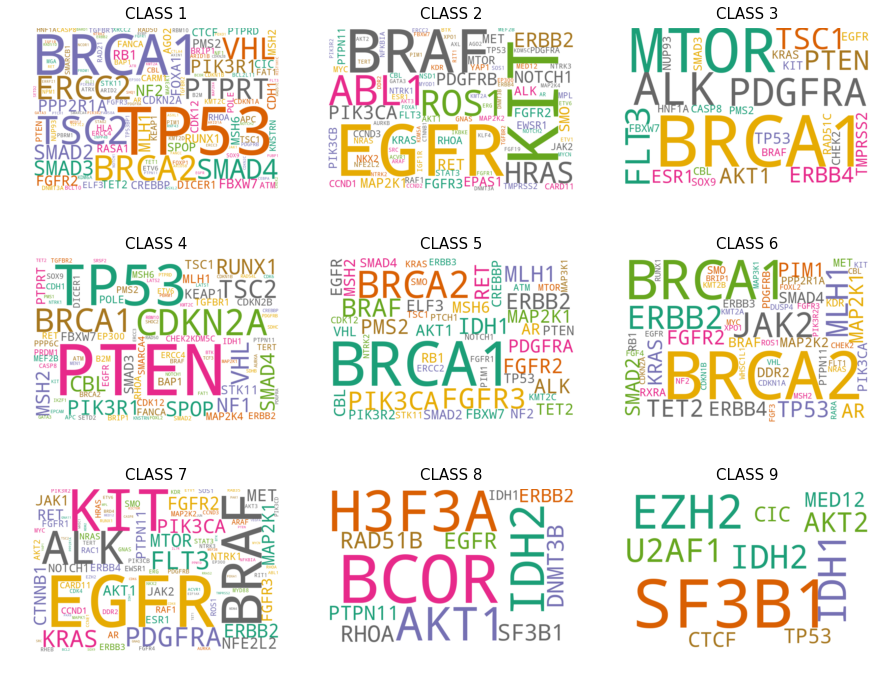

In [19]:
generate_word_cloud_per_class(cancer_df,'Gene')

###### Observation:- Dominent Gene per each class

* classs 1: BRCA1,TP53
* classs 2: KIT,EGFR
* classs 3: ALK,BRCA1
* classs 4: PTEN,TP53
* classs 5: BRCA1
* classs 6: BRCA2,BRCA1
* classs 7: EGFR,BRAF
* classs 8: BCOR,H3F3A
* classs 9: SF3B1

Number of Unique Variation : is 2996 
Truncating_Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61H                     3
Q61L                     3
T58I                     3
Q61R                     3
Name: Variation, dtype: int64
There are 2996 different categories  in the Variation feature and The distribution is follow as


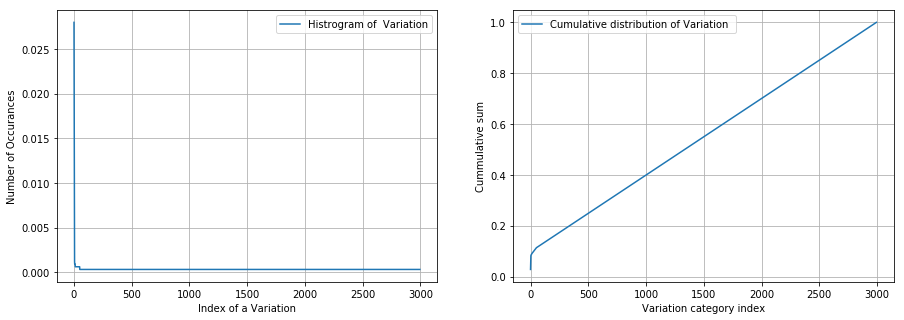

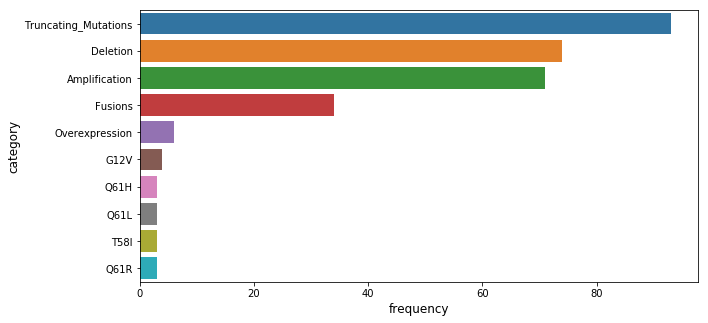

In [20]:
print_cummulative_histogram(cancer_df,'Variation')

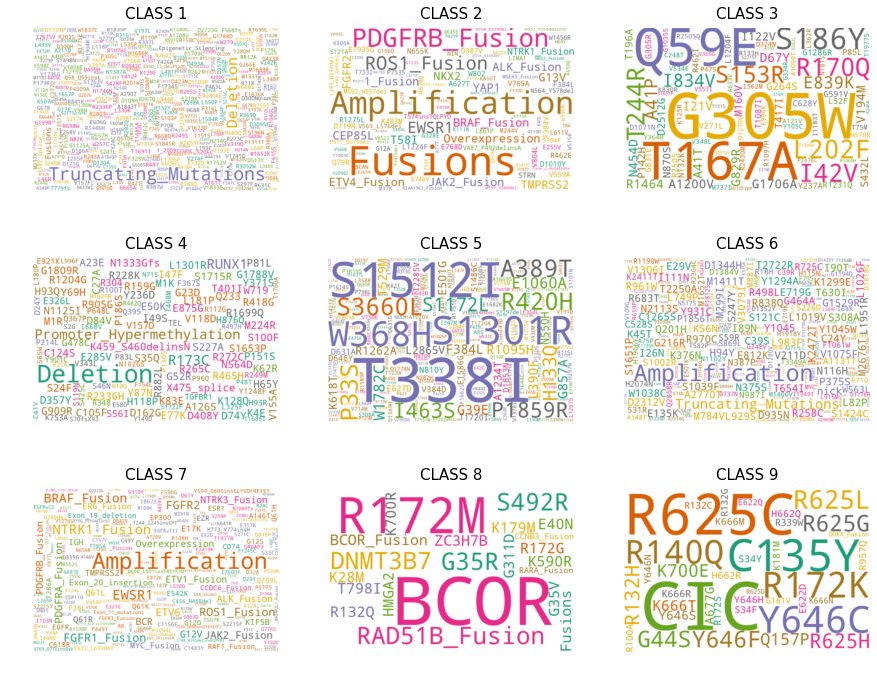

In [21]:
generate_word_cloud_per_class(cancer_df,'Variation')

######  Observation:- Dominent Variation per each class

* classs 1: TRUNCATING MUTATION
* classs 2: AMPLIFICATION FUSIONS
* classs 3: G305W
* classs 4: DELETION
* classs 5: T338I
* classs 6: AMPLIFICATION
* classs 7: AMPLIFICATION
* classs 8: BCOR
* classs 9: CIC

<h3>Train,Test and Cross Validation Split</h3>

In [22]:
y=cancer_df['Class'].values

In [23]:
X_train,X_test,y_train,y_test=train_test_split(cancer_df,y,test_size=0.20,stratify=y)
X_train_model,X_cv_model,y_train_model,y_cv_model=train_test_split(X_train,y_train,test_size=0.20,stratify=y_train)

In [24]:
print('Shape of  Train data set is :', X_train_model.shape)
print('Shape of  Test data set is :', X_test.shape)
print('Shape of  Cv data set is :', X_cv_model.shape)

Shape of  Train data set is : (2124, 5)
Shape of  Test data set is : (665, 5)
Shape of  Cv data set is : (532, 5)


<h4>Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

In [25]:
df=pd.DataFrame(index=[i for i in range(1,10) ])

df['Class']=[str(i) for i in range(1,10)]
df['No_Train_points']=list(Counter(y_train_model).values())
df['Train_percentage']=np.round(df['No_Train_points']/sum(list(Counter(y_train_model).values()))*100,2)

df['No_Test_points']=list(Counter(y_test).values())
df['Test_percentage']=np.round(df['No_Test_points']/sum(list(Counter(y_test).values()))*100,2)

df['No_cv_points']=list(Counter(y_cv_model).values())
df['Cv_percentage']=np.round(df['No_cv_points']/sum(list(Counter(y_cv_model).values()))*100,2)

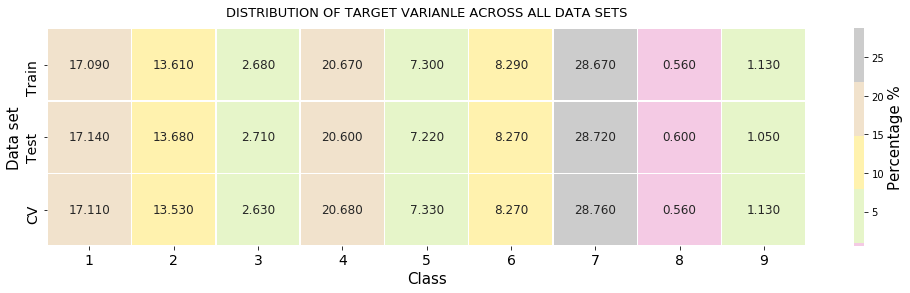

In [26]:
# Visual Representation of the target variable distribution

heat_map_data=df[['Train_percentage','Test_percentage','Cv_percentage']].T
plt.figure(figsize=(17,4))
plt.title("Distribution of target varianle across all data sets".upper(),pad=12,fontdict={'size':13})
ax=sns.heatmap(heat_map_data,cmap='Pastel2',annot=True,fmt='1.3f',
            xticklabels=[str(i) for i in range(1,10)],yticklabels=['Train','Test','CV'],linewidths=0.4,center=True,
            annot_kws={"size": 12})
ax.figure.axes[-1].set_ylabel('Percentage %', size=15)
ax.tick_params(which='major', labelsize=14)
ax.tick_params(which='minor', labelsize=14)
plt.xlabel("Class",fontsize=15)
plt.ylabel("Data set",fontsize=15)
plt.show()


In [27]:
#Textutal Representation
#code ref:https://stackoverflow.com/questions/9535954/printing-lists-as-tabular-data
print(tabulate(df,headers='keys',tablefmt='grid',showindex=False))

del df

+---------+-------------------+--------------------+------------------+-------------------+----------------+-----------------+
|   Class |   No_Train_points |   Train_percentage |   No_Test_points |   Test_percentage |   No_cv_points |   Cv_percentage |
+=========+===================+====================+==================+===================+================+=================+
|       1 |               363 |              17.09 |              114 |             17.14 |             91 |           17.11 |
+---------+-------------------+--------------------+------------------+-------------------+----------------+-----------------+
|       2 |               289 |              13.61 |               91 |             13.68 |             72 |           13.53 |
+---------+-------------------+--------------------+------------------+-------------------+----------------+-----------------+
|       3 |                57 |               2.68 |               18 |              2.71 |             14 |   

<h2>Prediction using a 'Random' Model</h2>

In [28]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(y, y_hat):
    
    conf_matrix= confusion_matrix(y, y_hat)
    plot_heatmap(conf_matrix,'Confusion Matrix')
    
    print("Note:-Recall matrix (Row Sum=1)".upper())
    recall_matrix =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)
    plot_heatmap(recall_matrix,'Recall Matrix')
    
    print("Note:-Precision matrix (Columm Sum=1)".upper())
    prec_matrix =(conf_matrix/conf_matrix.sum(axis=0))
    plot_heatmap(prec_matrix,'Precision Matrix')
    

In [29]:
def plot_heatmap(matrix,title):
    
    labels = [i for i in range(1,10)]
    plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(16,6))
    
    ax=sns.heatmap(matrix,annot=True,cmap='Blues',fmt=".3f",xticklabels=labels,yticklabels=labels,annot_kws={"size": 12})
    ax.figure.axes[-1].set_ylabel('Percentage %', size=15)
    
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("{}".format(title).upper(),pad=15)
    plt.show()

In [30]:
def generate_random_class_probs(y_true):
    
    predicted_y=np.zeros((len(y_true),9))
    
    for each_y in (range(len(y_true))):
        random_pred=np.random.rand(1,9)
        predicted_y[each_y] = ((random_pred/sum(sum(random_pred)))[0])

    return predicted_y
    

In [1]:
summary_table = PrettyTable()
summary_table.hrules=True
summary_table.field_names=['Model',"Train_Log_Loss", "Test_Log_Loss","Cv_Log_Loss"]

predict_y=generate_random_class_probs(y_train_model)
tr_log_loss=log_loss(y_train_model, predict_y, eps=1e-15)

predict_y=generate_random_class_probs(y_cv_model)
cv_log_loss=log_loss(y_cv_model, predict_y, eps=1e-15)

predict_y=generate_random_class_probs(y_test)
test_log_loss=log_loss(y_test, predict_y, eps=1e-15)

summary_table.add_row(['Random Probability Model',tr_log_loss,test_log_loss,cv_log_loss])
print(summary_table)

predicted_y =np.argmax(predict_y, axis=1)

plot_confusion_matrix(y_test,predicted_y)


NameError: name 'PrettyTable' is not defined

<h2>Univariate Analysis</h2>

In [32]:
def response_encoding(alpha, feature, data_frame):
    
    value_counts = data_frame[feature].value_counts()
    cat_dict = dict()

    for category, count in value_counts.items():
        
        vec = []
        
        for each_class in range(1,10):
            
            cls_cnt = data_frame.loc[(data_frame['Class']==each_class) & (data_frame[feature]==category)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (count + 90*alpha))
            
        cat_dict[category]=vec
    return cat_dict

def get_gv_feature(feature,df,cat_probs):

    response_encoding = []
    
    for cat_val in (df[feature].values):
        
        get_cat_value=cat_probs.get(cat_val)
        
        if(get_cat_value):
            response_encoding.append(get_cat_value)
        else:
            response_encoding.append([1/9 for i in range(9)])

    return response_encoding

In [33]:
def plot_log_loss(model,tune_param,hyper_vals,X_tr,y_tr,X_cv,y_cv,tune_label):
    
    train_log_loss=[]
    test_log_loss=[]
    
    summary_table = PrettyTable()
    summary_table.hrules=True
    summary_table.field_names=[tune_param.upper(),'train_log_loss','cv_log_loss']

    for i in tqdm.tqdm_notebook(sorted(hyper_vals)):
        hyper_param={tune_param:i}
        #code ref:https://stackoverflow.com/questions/27122757/sklearn-set-params-takes-exactly-1-argument
        clf = model.set_params(**hyper_param)
        clf.fit(X_tr, y_tr)
        prob_clf = CalibratedClassifierCV(clf, method="sigmoid")
        prob_clf.fit(X_tr, y_tr)
        
        predict_y = prob_clf.predict_proba(X_tr)
        tr_error=np.round(log_loss(y_tr, predict_y, labels=prob_clf.classes_, eps=1e-15),5)
        train_log_loss.append(tr_error)
        
        predict_y = prob_clf.predict_proba(X_cv)
        cv_error=np.round(log_loss(y_cv, predict_y, labels=prob_clf.classes_, eps=1e-15),5)
        test_log_loss.append(cv_error)

        summary_table.add_row([i,tr_error,cv_error])
    
        
    summary_table.sortby='cv_log_loss'
    print(summary_table)
    
    font = {'family' : 'normal','weight' : 'bold','size': 10}
    plt.figure(figsize=(13,6))
    
    x_label=[]
    if(tune_label):
        x_label=np.log10(hyper_vals)
    else:
        x_label=hyper_vals
    
    plt.plot(x_label, train_log_loss,c='g',label="Train logloss")
    plt.plot(x_label, test_log_loss,c='tomato',label="Test logloss")
    
    for i in range(len(hyper_vals)):
        plt.text(x_label[i],train_log_loss[i],str(np.round(train_log_loss[i],4)),fontdict=font)
        plt.text(x_label[i],test_log_loss[i],str(np.round(test_log_loss[i],4)),fontdict=font)
        
    plt.title("Cross Validation Log loss ".upper(),pad=20)
    plt.xlabel("hyper parameter :{}".format(tune_param))
    plt.ylabel("Log loss")
    plt.legend()
    plt.show()

In [34]:
def build_best_model(model,X_tr,y_tr,X_te,y_te,X_cv,y_cv,plot_matrix):
    
    from sklearn.metrics import log_loss
    
    model.fit(X_tr, y_tr)
    prob_clf = CalibratedClassifierCV(model, method="sigmoid")
    prob_clf.fit(X_tr, y_tr)

    predict_y = prob_clf.predict_proba(X_tr)
    tr_log_loss=np.round(log_loss(y_tr, predict_y, labels=prob_clf.classes_, eps=1e-15),5)

    predict_y = prob_clf.predict_proba(X_cv)
    cv_log_loss=np.round(log_loss(y_cv, predict_y, labels=prob_clf.classes_, eps=1e-15),5)
    
    predict_y = prob_clf.predict_proba(X_te)
    test_log_loss=np.round(log_loss(y_te, predict_y, labels=prob_clf.classes_, eps=1e-15),5)
    
    miss_classified_pct=np.round(np.count_nonzero((prob_clf.predict(X_cv)- y_cv))/y_cv.shape[0],4)*100
    
    
    summary_table = PrettyTable()
    summary_table.hrules=True
    summary_table.field_names=["Train_Log_Loss", "Test_Log_Loss","Cv_Log_Loss","Miss_classified_pct"]
    summary_table.add_row([tr_log_loss,test_log_loss,cv_log_loss,str(miss_classified_pct)+' %'])
    print(summary_table)

    if(plot_matrix):
        plot_confusion_matrix(y_cv, prob_clf.predict(X_cv))

In [35]:
def percent_covered(tr,te,cv,feature):
    
    train_covered=np.array(tr[feature].value_counts()).shape[0]
    print("Total number of different set of  ponits in the train data is ",train_covered)
    
    test_coverage=te[te[feature].isin(list(set(tr[feature])))].shape[0]
    cv_coverage=cv[cv[feature].isin(list(set(tr[feature])))].shape[0]
    
    print('In test data',test_coverage, 'out of',te.shape[0], ":",(test_coverage/te.shape[0])*100)
    print('In cross validation data',cv_coverage, 'out of ',cv.shape[0],":" ,(cv_coverage/cv.shape[0])*100)

##### Gene Feature

In [36]:
#Response Encoding
response_values=response_encoding(1,'Gene',X_train_model)

In [37]:
X_tr_gene_re=np.array(get_gv_feature('Gene',X_train_model,response_values))
X_te_gene_re=np.array(get_gv_feature('Gene',X_test,response_values))
X_cv_gene_re=np.array(get_gv_feature('Gene',X_cv_model,response_values))

In [38]:
print("The shape of gene feature for response encoding in train data:", X_tr_gene_re.shape)
print("The shape of gene feature for response encoding in test data:", X_te_gene_re.shape)
print("The shape of gene feature for response encoding in cv data:", X_cv_gene_re.shape)

The shape of gene feature for response encoding in train data: (2124, 9)
The shape of gene feature for response encoding in test data: (665, 9)
The shape of gene feature for response encoding in cv data: (532, 9)


In [39]:
# one-hot encoding of Gene feature.
vectorizer = CountVectorizer()
vectorizer.fit(X_train_model['Gene'])

X_tr_gene_oe= vectorizer.transform(X_train_model['Gene'])
X_te_gene_oe = vectorizer.transform(X_test['Gene'])
X_cv_gene_oe = vectorizer.transform(X_cv_model['Gene'])

In [40]:
print("The shape of gene feature for one hot encoding in train data:", X_tr_gene_oe.shape)
print("The shape of gene feature for one hot encoding in test data:", X_te_gene_oe.shape)
print("The shape of gene feature for one hot encoding in cv data:", X_cv_gene_oe.shape)

The shape of gene feature for one hot encoding in train data: (2124, 239)
The shape of gene feature for one hot encoding in test data: (665, 239)
The shape of gene feature for one hot encoding in cv data: (532, 239)



+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.0001 |    1.04121     |   1.21056   |
+--------+----------------+-------------+
| 0.001  |    1.09658     |   1.22845   |
+--------+----------------+-------------+
|  0.01  |    1.27394     |   1.34265   |
+--------+----------------+-------------+
|  0.1   |    1.39621     |   1.44758   |
+--------+----------------+-------------+
|   1    |    1.43775     |   1.48578   |
+--------+----------------+-------------+
|   10   |    1.44291     |   1.49074   |
+--------+----------------+-------------+
|  100   |    1.44365     |   1.49151   |
+--------+----------------+-------------+


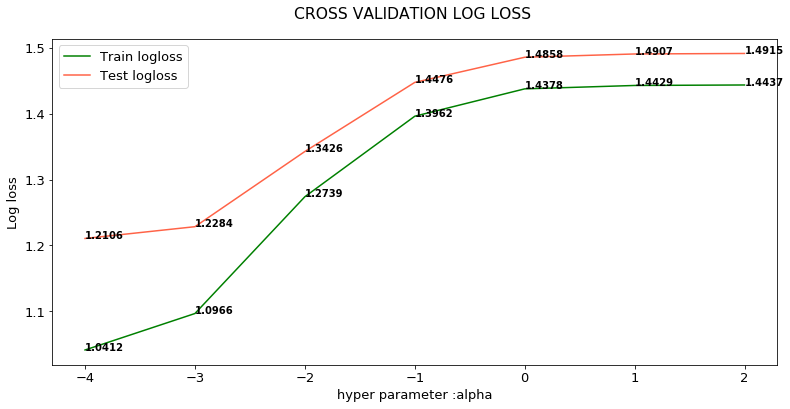

In [41]:
model=SGDClassifier()
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-4,3)]
plot_log_loss(model,'alpha',alpha_values,X_tr_gene_oe,y_train_model,X_cv_gene_oe,y_cv_model,True)

In [42]:
model.alpha=10**-4
build_best_model(model,X_tr_gene_oe,y_train_model,X_te_gene_oe,y_test,X_cv_gene_oe,y_cv_model,False)

+----------------+---------------+-------------+----------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct  |
+----------------+---------------+-------------+----------------------+
|    1.03529     |    1.21051    |   1.21569   | 46.989999999999995 % |
+----------------+---------------+-------------+----------------------+


In [43]:
percent_covered(X_train_model,X_test,X_cv_model,'Gene')

Total number of different set of  ponits in the train data is  240
In test data 653 out of 665 : 98.19548872180451
In cross validation data 517 out of  532 : 97.18045112781954


### Variation

In [44]:
response_values=response_encoding(1,'Variation',X_train_model)

In [45]:
X_tr_var_re=np.array(get_gv_feature('Variation',X_train_model,response_values))
X_te_var_re=np.array(get_gv_feature('Variation',X_test,response_values))
X_cv_var_re=np.array(get_gv_feature('Variation',X_cv_model,response_values))

In [46]:
print("The shape of Variation feature for response encoding in train data:", X_tr_var_re.shape)
print("The shape of Variation feature for response encoding in test data:", X_te_var_re.shape)
print("The shape of Variation feature for response encoding in cv data:", X_cv_var_re.shape)

The shape of Variation feature for response encoding in train data: (2124, 9)
The shape of Variation feature for response encoding in test data: (665, 9)
The shape of Variation feature for response encoding in cv data: (532, 9)


In [47]:
# one-hot encoding of variation feature.
vectorizer = CountVectorizer()

X_tr_var_oe = vectorizer.fit_transform(X_train_model['Variation'])
X_te_var_oe = vectorizer.transform(X_test['Variation'])
X_cv_var_oe = vectorizer.transform(X_cv_model['Variation'])

In [48]:
print("The shape of Variation feature for one hot encoding in train data:", X_tr_var_oe.shape)
print("The shape of Variation feature for one hot encoding in test data:", X_te_var_oe.shape)
print("The shape of Variation feature for one hot encoding in cv data:", X_cv_var_oe.shape)

The shape of Variation feature for one hot encoding in train data: (2124, 1951)
The shape of Variation feature for one hot encoding in test data: (665, 1951)
The shape of Variation feature for one hot encoding in cv data: (532, 1951)



+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.0001 |    0.74647     |   1.71158   |
+--------+----------------+-------------+
| 0.001  |    1.02421     |   1.72099   |
+--------+----------------+-------------+
|  0.01  |    1.45161     |   1.73386   |
+--------+----------------+-------------+
|  0.1   |     1.5686     |   1.73919   |
+--------+----------------+-------------+
|   1    |    1.59097     |   1.74197   |
+--------+----------------+-------------+
|   10   |    1.59293     |   1.74245   |
+--------+----------------+-------------+
|  100   |    1.59311     |   1.74254   |
+--------+----------------+-------------+


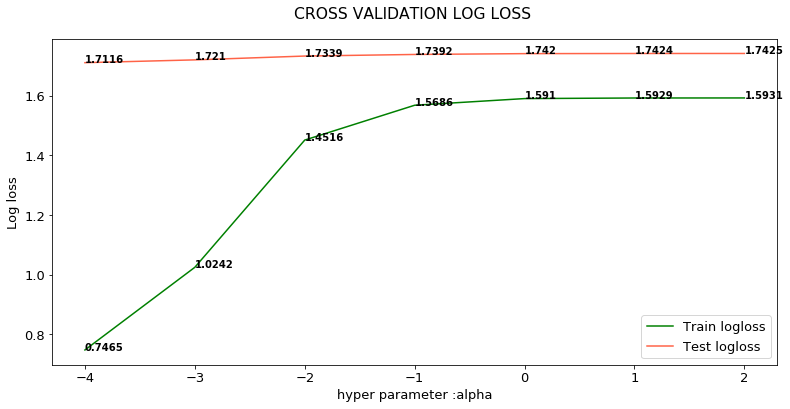

In [49]:
plot_log_loss(model,'alpha',alpha_values,X_tr_var_oe,y_train_model,X_cv_var_oe,y_cv_model,True)

In [50]:
model.alpha=10**-2
build_best_model(model,X_tr_var_oe,y_train_model,X_te_var_oe,y_test,X_cv_var_oe,y_cv_model,False)

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    1.45281     |    1.73536    |   1.73383   | 65.60000000000001 % |
+----------------+---------------+-------------+---------------------+


In [51]:
percent_covered(X_train_model,X_test,X_cv_model,'Variation')

Total number of different set of  ponits in the train data is  1919
In test data 54 out of 665 : 8.1203007518797
In cross validation data 59 out of  532 : 11.090225563909774


###  Text Feature

In [52]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

In [53]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

## BOW (unigram)

### onehot encoding

In [54]:
vectorizer = CountVectorizer(min_df=3)
X_tr_text_oe = vectorizer.fit_transform(X_train_model['Text'])

train_text_features= vectorizer.get_feature_names()
# X_tr_text_oe.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = X_tr_text_oe.sum(axis=0).A1
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

# don't forget to normalize every feature
X_tr_text_oe = normalize(X_tr_text_oe, axis=0)

X_te_text_oe = vectorizer.transform(X_test['Text'])
X_te_text_oe = normalize(X_te_text_oe, axis=0)

X_cv_text_oe = vectorizer.transform(X_cv_model['Text'])
X_cv_text_oe = normalize(X_cv_text_oe, axis=0)


Total number of unique words in train data : 53310


In [55]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train_model[X_train_model['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train_model)

### Response encoding

In [56]:
#response coding of text features
X_tr_text_re  = get_text_responsecoding(X_train_model)
X_te_text_re  = get_text_responsecoding(X_test)
X_cv_text_re  = get_text_responsecoding(X_cv_model)

In [57]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
X_tr_text_re = (X_tr_text_re.T/X_tr_text_re.sum(axis=1)).T
X_te_text_re = (X_te_text_re.T/X_te_text_re.sum(axis=1)).T
X_cv_text_re = (X_cv_text_re.T/X_cv_text_re.sum(axis=1)).T

In [58]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [59]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur).most_common(22))

[(3, 5945), (4, 3405), (5, 3009), (6, 2789), (7, 2376), (8, 1970), (9, 1566), (10, 1291), (12, 1279), (15, 1059), (14, 1026), (11, 940), (13, 915), (16, 832), (17, 708), (18, 689), (24, 531), (20, 497), (19, 472), (21, 469), (25, 469), (34, 431)]



+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.001  |    0.75567     |   1.16863   |
+--------+----------------+-------------+
|  0.01  |    0.88304     |   1.24951   |
+--------+----------------+-------------+
| 0.0001 |    1.08564     |   1.35291   |
+--------+----------------+-------------+
|  0.1   |    1.36102     |    1.3893   |
+--------+----------------+-------------+
|   1    |    1.62606     |   1.64265   |
+--------+----------------+-------------+
|   10   |    1.66603     |   1.67861   |
+--------+----------------+-------------+
|  100   |    1.67019     |   1.68237   |
+--------+----------------+-------------+


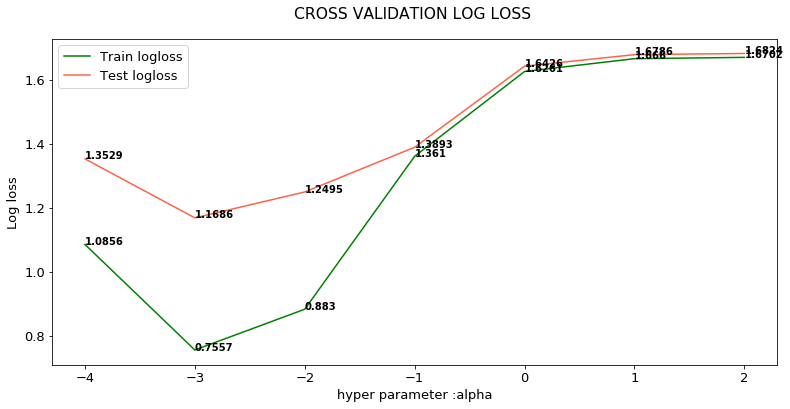

In [60]:
plot_log_loss(model,'alpha',alpha_values,X_tr_text_oe,y_train_model,X_cv_text_oe,y_cv_model,True)

In [61]:
model.alpha=10**-3
build_best_model(model,X_tr_text_oe,y_train_model,X_te_text_oe,y_test,X_cv_text_oe,y_cv_model,False)

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.76123     |    1.16648    |   1.17574   |       37.97 %       |
+----------------+---------------+-------------+---------------------+


In [62]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [63]:
len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(X_cv_model)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.841 % of word of test data appeared in train data
97.749 % of word of Cross Validation appeared in train data


In [64]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train_model['Gene'])
    var_vec  = var_count_vec.fit(X_train_model['Variation'])
    text_vec = text_count_vec.fit(X_train_model['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [65]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names_tfidf(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train_model['Gene'])
    var_vec  = var_count_vec.fit(X_train_model['Variation'])
    text_vec = text_count_vec.fit(X_train_model['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<h3>Stacking the three types of features</h3

In [66]:
X_tr_re = np.hstack((X_tr_gene_re,X_tr_var_re,X_tr_text_re))
X_te_re = np.hstack((X_te_gene_re,X_te_var_re,X_te_text_re))
X_cv_re = np.hstack((X_cv_gene_re,X_cv_var_re,X_cv_text_re))

print("\nAfter Response encoding :\n".upper())
print("train data shape : ", X_tr_re.shape)
print("test data shape : ", X_te_re.shape)
print("cross validation data  shape :", X_cv_re.shape)

X_tr_f= hstack((X_tr_gene_oe,X_tr_var_oe)).tocsr()
X_te_f= hstack((X_te_gene_oe,X_te_var_oe)).tocsr()
X_cv_f= hstack((X_cv_gene_oe,X_cv_var_oe)).tocsr()

X_tr_oe = hstack((X_tr_f,X_tr_text_oe)).tocsr()
X_te_oe = hstack((X_te_f,X_te_text_oe)).tocsr()
X_cv_oe = hstack((X_cv_f,X_cv_text_oe)).tocsr()

print("\nAfter One hot encoding  using BOW:\n".upper())
print("train data shape : ", X_tr_oe.shape)
print("test data shape : ", X_te_oe.shape)
print("cross validation data  shape :", X_cv_oe.shape)



AFTER RESPONSE ENCODING :

train data shape :  (2124, 27)
test data shape :  (665, 27)
cross validation data  shape : (532, 27)

AFTER ONE HOT ENCODING  USING BOW:

train data shape :  (2124, 55500)
test data shape :  (665, 55500)
cross validation data  shape : (532, 55500)


In [67]:
#remove one hot encoding
del X_tr_gene_oe
del X_te_gene_oe
del X_cv_gene_oe

del X_tr_var_oe
del X_te_var_oe
del X_cv_var_oe

del X_tr_text_oe
del X_te_text_oe
del X_cv_text_oe

In [68]:
#remove response encoding
del X_tr_gene_re
del X_te_gene_re
del X_cv_gene_re

del X_tr_var_re
del X_te_var_re
del X_cv_var_re

del X_tr_text_re
del X_te_text_re
del X_cv_text_re

In [69]:
def predict_future_q_point(model,X_tr,X_te,y_tr,y_te,index):
    
    model.fit(X_tr, y_tr)
    sig_clf = CalibratedClassifierCV(model, method="sigmoid")
    sig_clf.fit(X_tr, y_tr)
    
    predicted_cls = sig_clf.predict(X_te[index])
    actual_cls=y_te[index]
    probs_values=np.round(sig_clf.predict_proba(X_te[index]),4)

    
    return [predicted_cls,actual_cls,probs_values]

<h1> Machine Learning Models</h1>

<h2>Base Line Model</h2>

<h3>Naive Bayes</h3>

<h4>Hyper parameter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
|   1    |    0.91926     |   1.29414   |
+--------+----------------+-------------+
| 0.001  |    0.88637     |   1.30207   |
+--------+----------------+-------------+
|  0.01  |    0.89829     |   1.30521   |
+--------+----------------+-------------+
|  1000  |    1.04571     |   1.30585   |
+--------+----------------+-------------+
| 0.0001 |    0.87608     |   1.30734   |
+--------+----------------+-------------+
| 1e-05  |    0.87273     |   1.31006   |
+--------+----------------+-------------+
|  0.1   |    0.90823     |   1.31161   |
+--------+----------------+-------------+
|  100   |    1.09531     |   1.35764   |
+--------+----------------+-------------+
|   10   |    1.08518     |   1.37803   |
+--------+----------------+-------------+


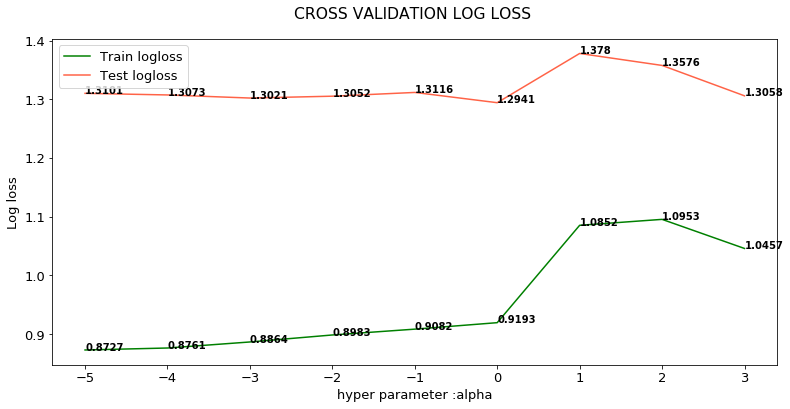

In [70]:
model=MultinomialNB()
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing the model with best hyper paramters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.91926     |     1.2678    |   1.29414   |       39.85 %       |
+----------------+---------------+-------------+---------------------+


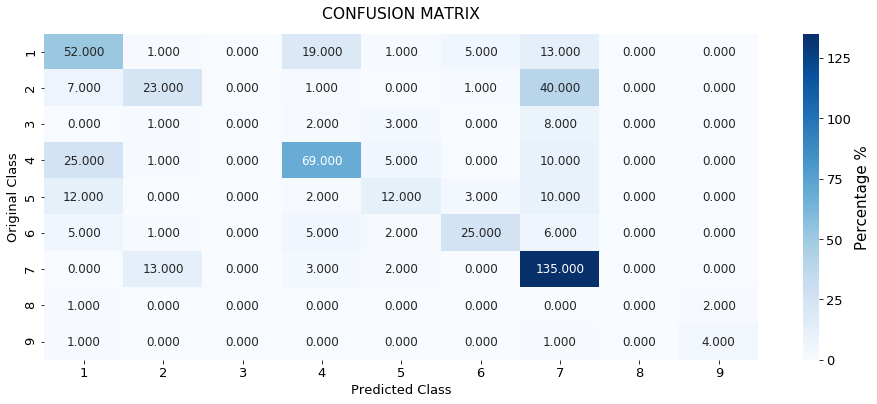

NOTE:-RECALL MATRIX (ROW SUM=1)


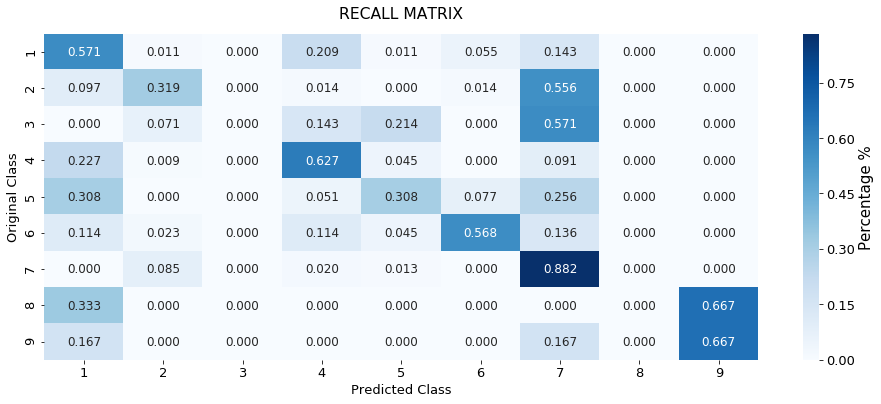

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


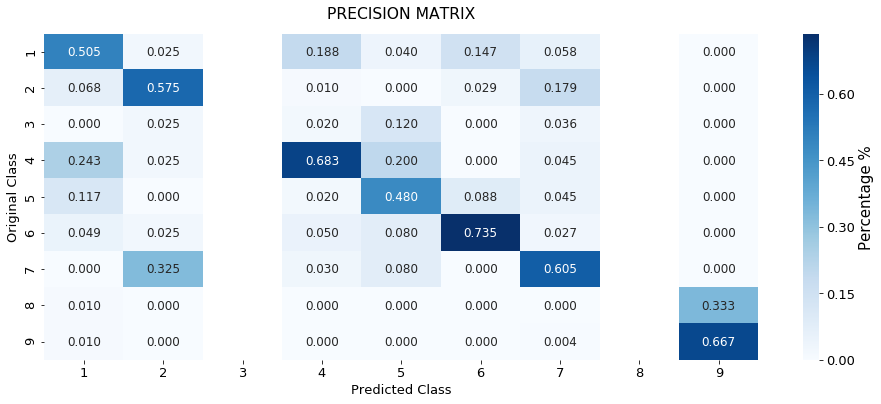

In [71]:
model.alpha=10**0
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h4>Feature Importance, Correctly classified point</h4>

In [73]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 3 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [0.0751 0.0857 0.0231 0.4772 0.0479 0.0393 0.2416 0.0046 0.0054]
----------------------------------------------------------------------------------------------------
6 Text feature [function] present in test data point [True]
10 Text feature [protein] present in test data point [True]
11 Text feature [acid] present in test data point [True]
12 Text feature [missense] present in test data point [True]
14 Text feature [activity] present in test data point [True]
15 Text feature [amino] present in test data point [True]
16 Text feature [proteins] present in test data point [True]
17 Text feature [retained] present in test data point [True]
18 Text feature [experiments] present in test data point [True]
19 Text feature [functional] present in test data point [True]
25 Text feature [loss] present in test data point [True]
26 Text feature [results] present in test data point [True]
29 Tex

<h4>Feature Importance, Incorrectly classified point</h4>

In [74]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.0783 0.4612 0.0263 0.1055 0.1946 0.0439 0.0789 0.0052 0.0062]
----------------------------------------------------------------------------------------------------
15 Text feature [identified] present in test data point [True]
21 Text feature [molecular] present in test data point [True]
23 Text feature [clinical] present in test data point [True]
24 Text feature [time] present in test data point [True]
26 Text feature [another] present in test data point [True]
28 Text feature [case] present in test data point [True]
29 Text feature [new] present in test data point [True]
31 Text feature [including] present in test data point [True]
33 Text feature [sequencing] present in test data point [True]
34 Text feature [patient] present in test data point [True]
37 Text feature [confirmed] present in test data point [True]
38 Text feature [12] present in test data point [True]
39 Text fea

<h2>K Nearest Neighbour Classification</h2>

<h3>Hyper parameter tuning</h3>


+-------------+----------------+-------------+
| N_NEIGHBORS | train_log_loss | cv_log_loss |
+-------------+----------------+-------------+
|      11     |    0.63884     |   1.05847   |
+-------------+----------------+-------------+
|      15     |     0.6996     |   1.06926   |
+-------------+----------------+-------------+
|      5      |    0.49726     |   1.07563   |
+-------------+----------------+-------------+
|      21     |    0.75576     |   1.09501   |
+-------------+----------------+-------------+
|      31     |    0.81911     |    1.1105   |
+-------------+----------------+-------------+
|      41     |    0.85839     |   1.12324   |
+-------------+----------------+-------------+
|      51     |    0.88384     |    1.1252   |
+-------------+----------------+-------------+
|      99     |    0.94893     |   1.13909   |
+-------------+----------------+-------------+


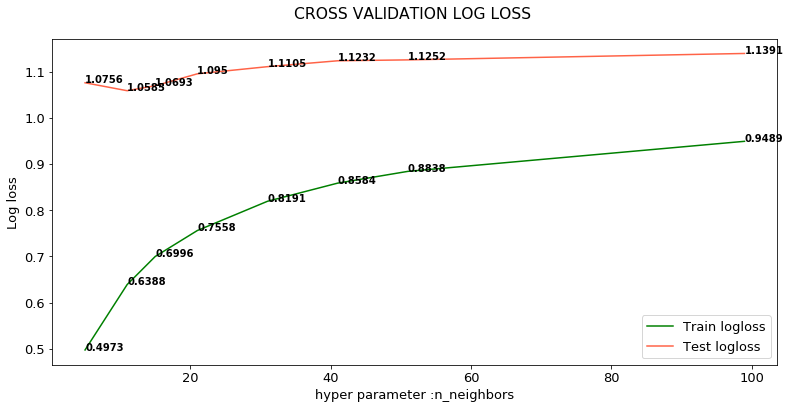

In [75]:
model=KNeighborsClassifier()
model.n_jobs=-1
k_values=[5, 11, 15, 21, 31, 41, 51, 99]
plot_log_loss(model,'n_neighbors',k_values,X_tr_re,y_train_model,X_cv_re,y_cv_model,False)

<h3>Testing the model with best hyper paramters</h3>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.63884     |    1.10655    |   1.05847   |       37.03 %       |
+----------------+---------------+-------------+---------------------+


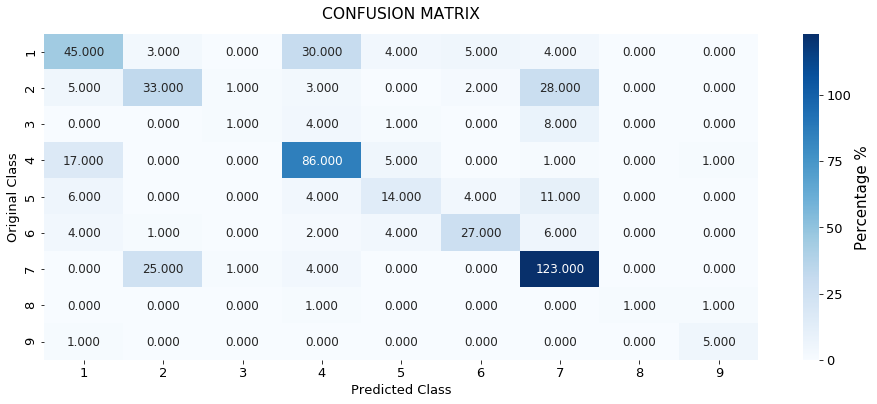

NOTE:-RECALL MATRIX (ROW SUM=1)


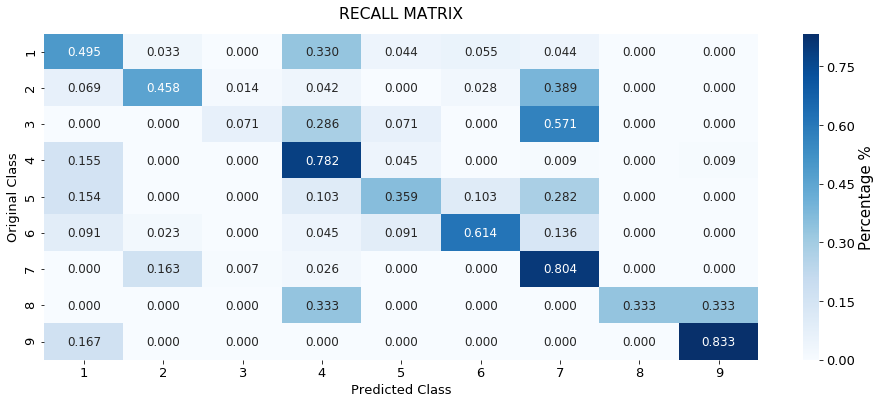

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


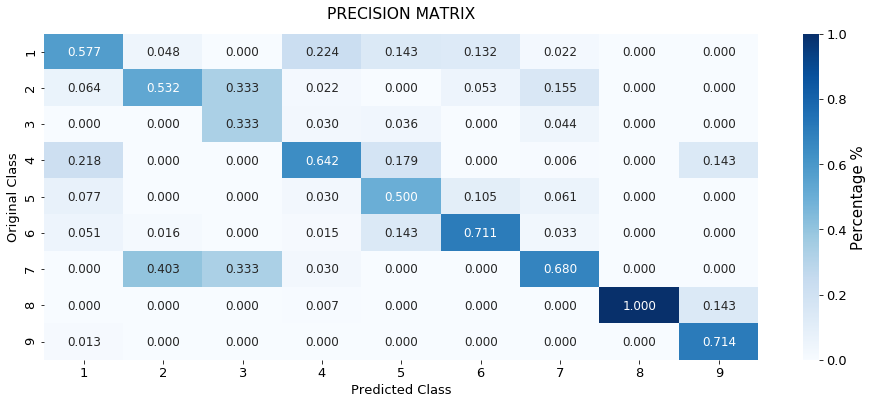

In [76]:
model.n_neighbors=11
build_best_model(model,X_tr_re,y_train_model,X_te_re,y_test,X_cv_re,y_cv_model,True)

In [77]:
model.fit(X_tr_re, y_train_model)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(X_tr_re, y_train_model)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform'),
            cv='warn', method='sigmoid')

<h3>correctly classified point</h3>

In [78]:
n_neighbours=11

In [79]:
for test_point_index in range(1,15):
    
    predicted_cls = sig_clf.predict(X_te_re[test_point_index].reshape(1,-1))
    actual_cls=y_test[test_point_index]
    
    if(predicted_cls == actual_cls):
        print("For the index {} from the test data".format(test_point_index))
        print("Predicted Class :", predicted_cls[0])
        print("Actual Class :", actual_cls)

        neighbors = model.kneighbors(X_te_re[test_point_index].reshape(1, -1), n_neighbours)
        print("the k value for knn is",n_neighbours,"and the nearest neighbours of the test points belongs to classes",
              y_train_model[neighbors[1][0]])
        print("Fequency of nearest points :",Counter(y_train_model[neighbors[1][0]]))
        
        break

For the index 3 from the test data
Predicted Class : 4
Actual Class : 4
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [4 1 4 1 4 7 4 1 4 4 4]
Fequency of nearest points : Counter({4: 7, 1: 3, 7: 1})


<h3>incorrectly classified point</h3>

In [80]:
for test_point_index in range(1,15):
    
    predicted_cls = sig_clf.predict(X_te_re[test_point_index].reshape(1,-1))
    actual_cls=y_test[test_point_index]
    
    if(predicted_cls != actual_cls):
        print("For the index {} from the test data".format(test_point_index))
        print("Predicted Class :", predicted_cls[0])
        print("Actual Class :", actual_cls)

        neighbors = model.kneighbors(X_te_re[test_point_index].reshape(1, -1), n_neighbours)
        print("the k value for knn is",n_neighbours,"and the nearest neighbours of the test points belongs to classes",
              y_train_model[neighbors[1][0]])
        print("Fequency of nearest points :",Counter(y_train_model[neighbors[1][0]]))
        
        break

For the index 1 from the test data
Predicted Class : 2
Actual Class : 5
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [2 2 2 5 2 2 2 2 7 1 2]
Fequency of nearest points : Counter({2: 8, 1: 1, 5: 1, 7: 1})


<h2>Logistic Regression(With Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.001  |    0.62691     |   1.13413   |
+--------+----------------+-------------+
|  0.01  |    0.78216     |   1.14883   |
+--------+----------------+-------------+
| 0.0001 |    0.93194     |   1.26658   |
+--------+----------------+-------------+
| 1e-05  |    1.10112     |   1.39267   |
+--------+----------------+-------------+
|  0.1   |     1.3719     |   1.40602   |
+--------+----------------+-------------+
|   1    |    1.62579     |   1.64565   |
+--------+----------------+-------------+
|   10   |     1.6565     |    1.677    |
+--------+----------------+-------------+
|  100   |     1.6598     |   1.68031   |
+--------+----------------+-------------+
|  1000  |    1.66023     |   1.68079   |
+--------+----------------+-------------+


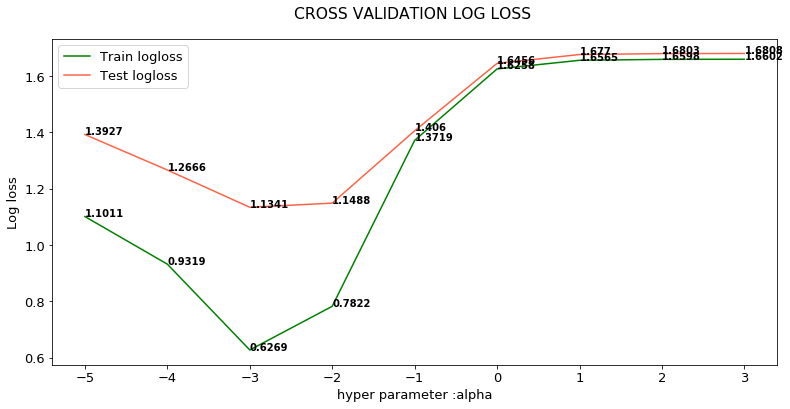

In [81]:
model=SGDClassifier()
model.class_weight='balanced'
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing the model with best hyper paramters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.62533     |    1.09768    |   1.11214   |       34.96 %       |
+----------------+---------------+-------------+---------------------+


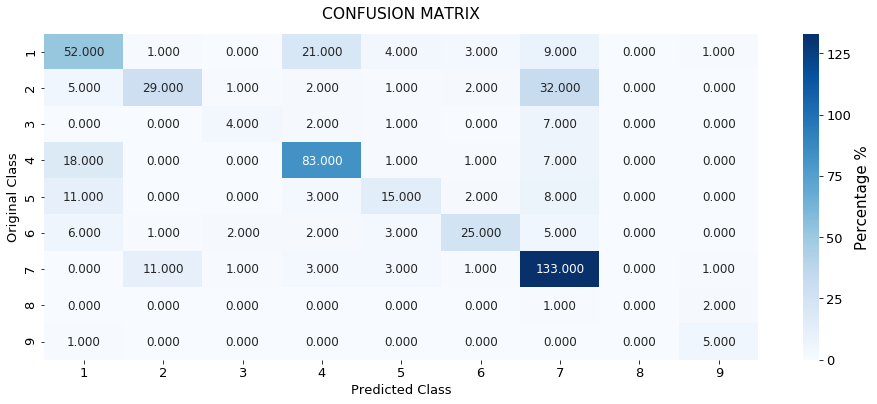

NOTE:-RECALL MATRIX (ROW SUM=1)


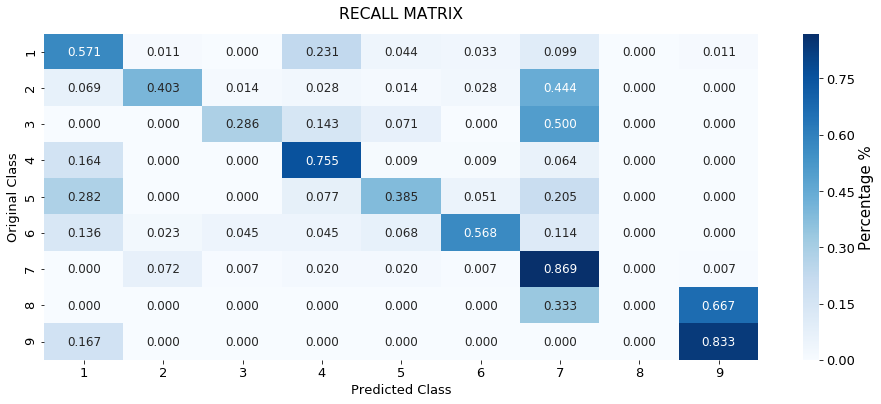

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


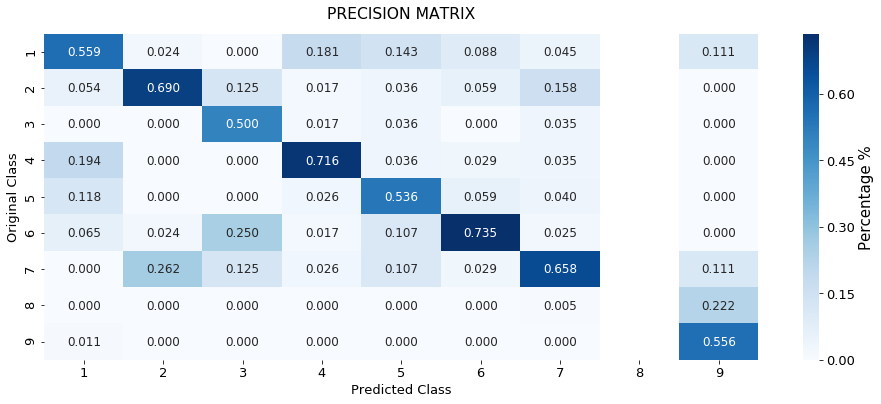

In [82]:
model.alpha=10**-3
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h4>Feature Importance</h4>

<h5>Correctly Classified point</h5>

In [85]:
tot_features=100

for index in range(10,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 11 from the test data
Predicted Class : [7]
Actual Class : 7
Predicted Class Probabilities: [0.0148 0.0285 0.0064 0.0873 0.0169 0.0085 0.8296 0.0042 0.0038]
----------------------------------------------------------------------------------------------------
36 Text feature [ligand] present in test data point [True]
37 Text feature [constitutively] present in test data point [True]
39 Text feature [constitutive] present in test data point [True]
62 Text feature [receptors] present in test data point [True]
73 Text feature [transforming] present in test data point [True]
75 Text feature [activated] present in test data point [True]
Out of the top  100  features  6 are present in query point


<h5>Incorrectly Classified point</h5>

In [86]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.0085 0.8738 0.0037 0.0051 0.0833 0.0037 0.0105 0.0046 0.0068]
----------------------------------------------------------------------------------------------------
Out of the top  100  features  0 are present in query point


<h2>Logistic Regression(With out Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.001  |    0.61982     |   1.12283   |
+--------+----------------+-------------+
|  0.01  |    0.75879     |   1.19664   |
+--------+----------------+-------------+
| 0.0001 |    0.92975     |   1.29345   |
+--------+----------------+-------------+
|  0.1   |    1.22852     |   1.30549   |
+--------+----------------+-------------+
| 1e-05  |    1.03451     |    1.3244   |
+--------+----------------+-------------+
|   1    |    1.54545     |   1.58558   |
+--------+----------------+-------------+
|   10   |    1.59779     |    1.6321   |
+--------+----------------+-------------+
|  100   |    1.60312     |   1.63677   |
+--------+----------------+-------------+
|  1000  |    1.60401     |   1.63719   |
+--------+----------------+-------------+


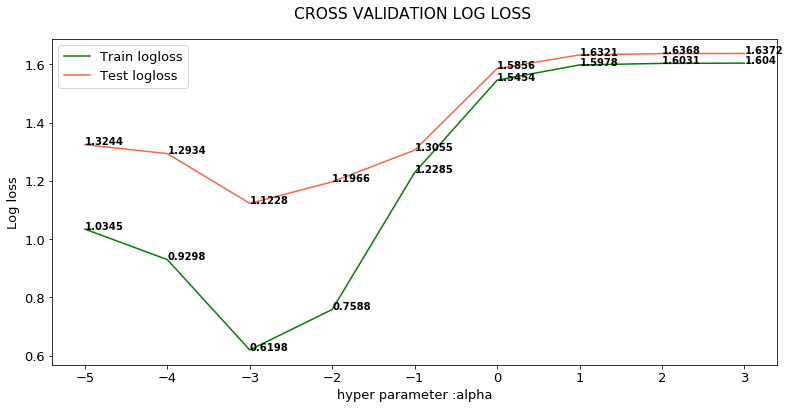

In [87]:
model=SGDClassifier()
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing model with best hyper parameters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.61942     |    1.12616    |   1.11228   |       36.84 %       |
+----------------+---------------+-------------+---------------------+


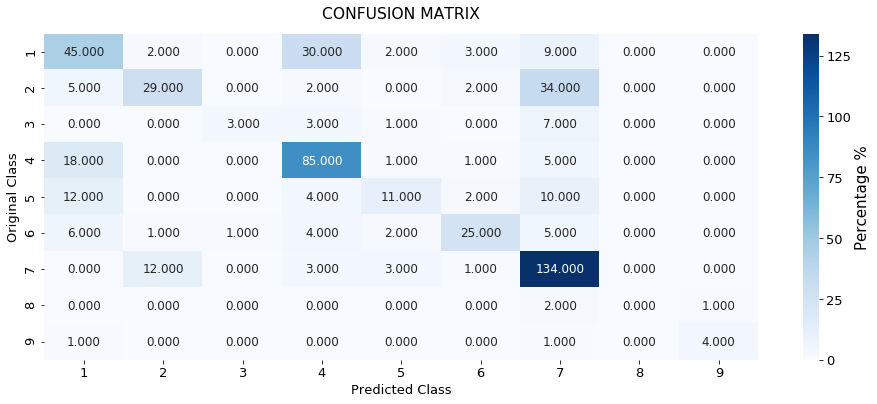

NOTE:-RECALL MATRIX (ROW SUM=1)


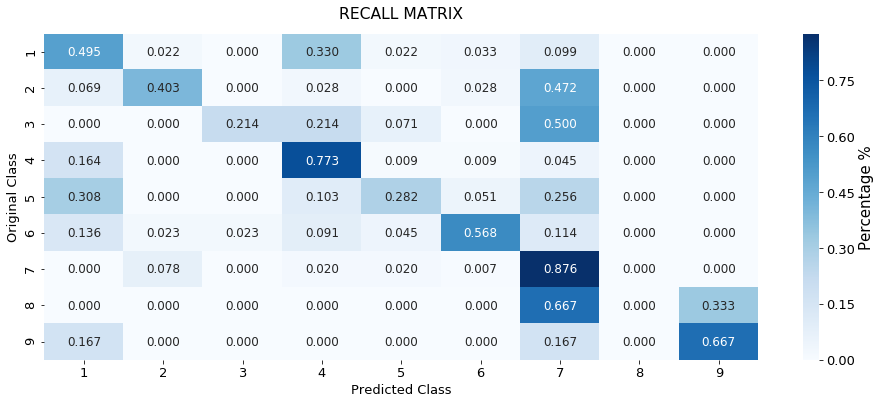

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


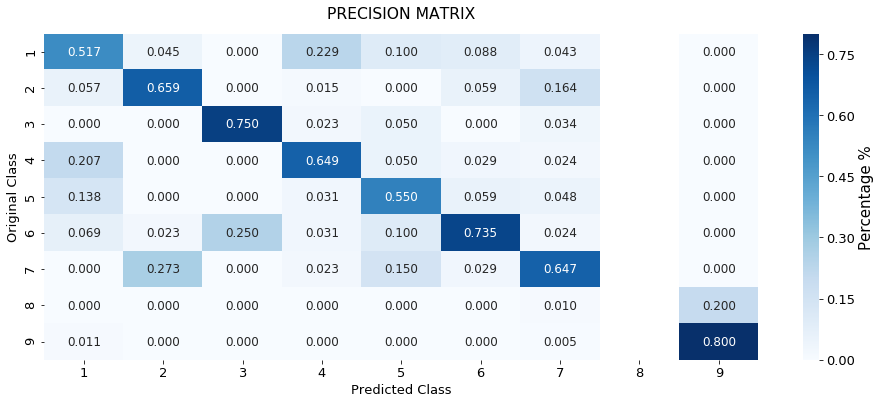

In [88]:
model.alpha=10**-3
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h4>Feature Importance, Correctly Classified point</h4>

In [89]:
tot_features=500

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 3 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [0.1006 0.1058 0.0151 0.5272 0.0394 0.0272 0.1743 0.0055 0.005 ]
----------------------------------------------------------------------------------------------------
311 Text feature [pmdlg] present in test data point [True]
337 Text feature [suppressor] present in test data point [True]
452 Text feature [385] present in test data point [True]
453 Text feature [missense] present in test data point [True]
Out of the top  500  features  4 are present in query point


<h4>Feature Importance, Inorrectly Classified point</h4>

In [90]:
tot_features=500

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [6.900e-03 6.570e-01 3.000e-03 6.800e-03 3.011e-01 3.700e-03 1.900e-02
 1.800e-03 6.000e-04]
----------------------------------------------------------------------------------------------------
210 Text feature [m918] present in test data point [True]
453 Text feature [691] present in test data point [True]
462 Text feature [m918t] present in test data point [True]
Out of the top  500  features  3 are present in query point


<h2>Linear Support Vector Machines</h2>

<h3>Hyper paramter tuning</h3>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
|  0.01  |    0.76183     |    1.1562   |
+--------+----------------+-------------+
| 0.001  |     0.8228     |   1.20646   |
+--------+----------------+-------------+
| 0.0001 |    1.00358     |    1.3324   |
+--------+----------------+-------------+
|  0.1   |    1.26588     |   1.34795   |
+--------+----------------+-------------+
| 1e-05  |    1.04339     |   1.37611   |
+--------+----------------+-------------+
|   1    |    1.64581     |   1.66671   |
+--------+----------------+-------------+
|   10   |    1.66038     |   1.68093   |
+--------+----------------+-------------+
|  100   |    1.66038     |   1.68094   |
+--------+----------------+-------------+
|  1000  |    1.66039     |   1.68094   |
+--------+----------------+-------------+


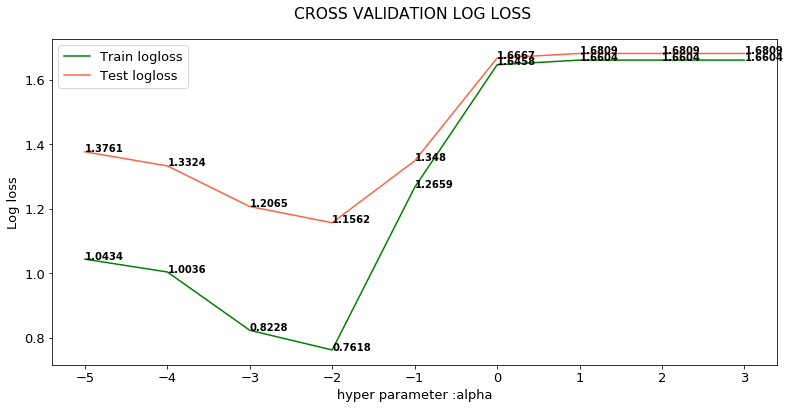

In [91]:
model=SGDClassifier()
model.loss='hinge'
model.class_weight='balanced'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h3>Testing model with best hyper parameters</h3>

+----------------+---------------+-------------+----------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct  |
+----------------+---------------+-------------+----------------------+
|    0.75829     |    1.16085    |   1.15664   | 34.589999999999996 % |
+----------------+---------------+-------------+----------------------+


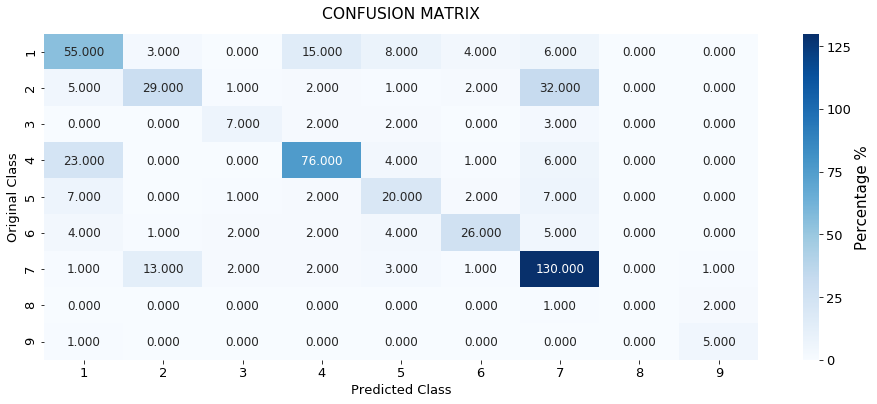

NOTE:-RECALL MATRIX (ROW SUM=1)


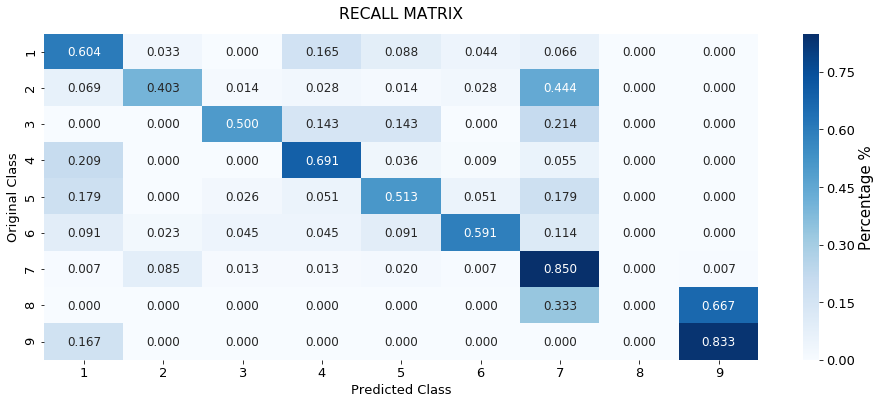

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


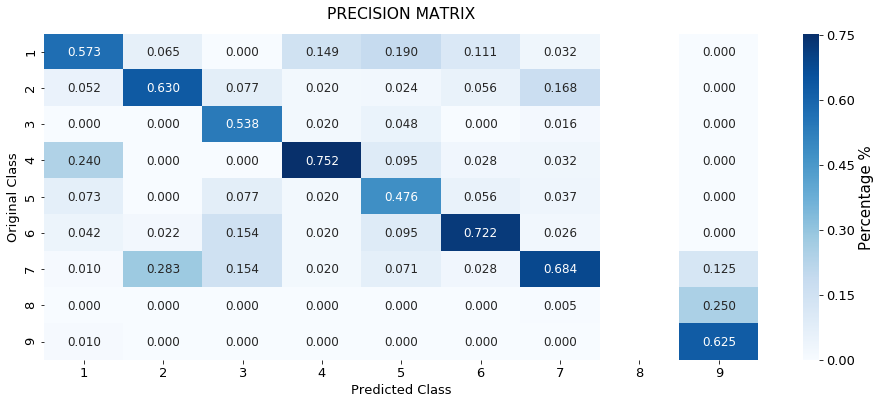

In [92]:
model.alpha=10**-2
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h3>Feature Importance</h3>

<h4>For Correctly classified point</h4>

In [93]:
tot_features=500

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 3 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [0.1216 0.1057 0.0198 0.4728 0.0518 0.0333 0.1815 0.006  0.0074]
----------------------------------------------------------------------------------------------------
96 Text feature [suppressor] present in test data point [True]
128 Text feature [improvision] present in test data point [True]
161 Text feature [microscopy] present in test data point [True]
306 Text feature [pmdlg] present in test data point [True]
342 Text feature [knockout] present in test data point [True]
Out of the top  500  features  5 are present in query point


<h4>For Incorrectly classified point</h4>

In [94]:
tot_features=500

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.013  0.6389 0.0052 0.0219 0.281  0.005  0.0256 0.0043 0.005 ]
----------------------------------------------------------------------------------------------------
Out of the top  500  features  0 are present in query point


<h2>Random Forest Classifier</h2>

<h3>Hyper paramter tuning (With One hot Encoding)</h3>

In [95]:
def randomforest_hypertuning(X_tr,X_cv):
    
    from sklearn.metrics import log_loss
    
    n_estimators = [100,200,500,1000,2000]
    max_depth = [2,4,6,8,10]

    cv_log_error = []
    train_log_error=[]

    for est in tqdm.tqdm_notebook(n_estimators):
        for dep in max_depth:

            clf = RandomForestClassifier(n_estimators=est, criterion='gini', max_depth=dep, random_state=42, n_jobs=-1)
            clf.fit(X_tr, y_train_model)

            sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
            sig_clf.fit(X_tr, y_train_model)

            sig_clf_probs = sig_clf.predict_proba(X_cv)
            cv_log_error.append(log_loss(y_cv_model, sig_clf_probs, labels=clf.classes_, eps=1e-15))

            sig_clf_probs = sig_clf.predict_proba(X_tr)
            train_log_error.append(log_loss(y_train_model, sig_clf_probs, labels=clf.classes_, eps=1e-15))

    log_loss=[np.array(train_log_error).reshape(5,5),np.array(cv_log_error).reshape(5,5)]

    titles=["Train dataset","CV dataset"]
    fig,plots= plt.subplots(1,2,figsize=(21,7))
    fig.suptitle("Log loss for Train and CV datasets".upper(),fontsize=14)
    for i in range(2):
        sns.heatmap(log_loss[i],
                    xticklabels=max_depth,yticklabels=n_estimators,cmap="YlGnBu",annot=True,fmt='f',ax=plots[i],cbar=False)
        plots[i].set_title('{} LogLoss'.format(titles[i]).upper(),fontsize=14)
        plots[i].set(xlabel='max_depth', ylabel='n_estimators')
        plots[i].label_outer()
    plt.show()


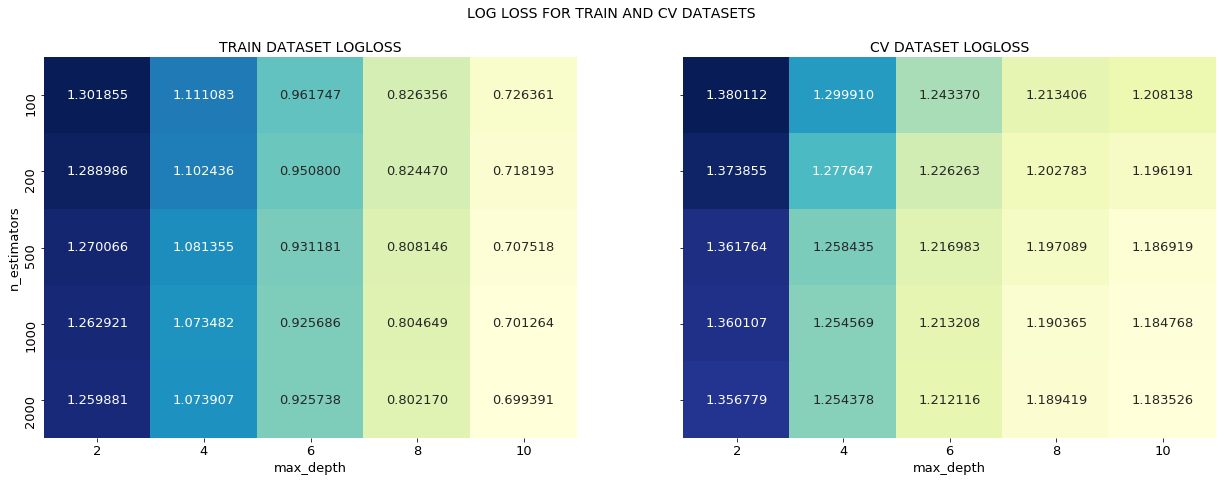

In [96]:
randomforest_hypertuning(X_tr_oe,X_cv_oe)

<h3>Testing model with best hyper parameters (One Hot Encoding)</h3>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.70752     |    1.16355    |   1.18692   |       41.17 %       |
+----------------+---------------+-------------+---------------------+


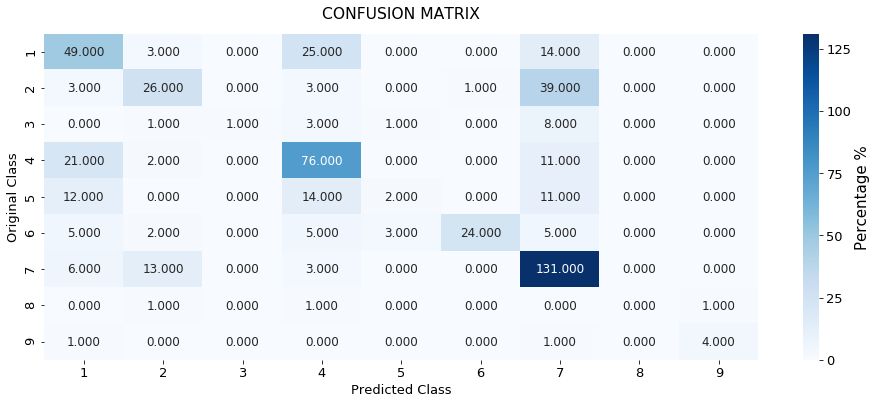

NOTE:-RECALL MATRIX (ROW SUM=1)


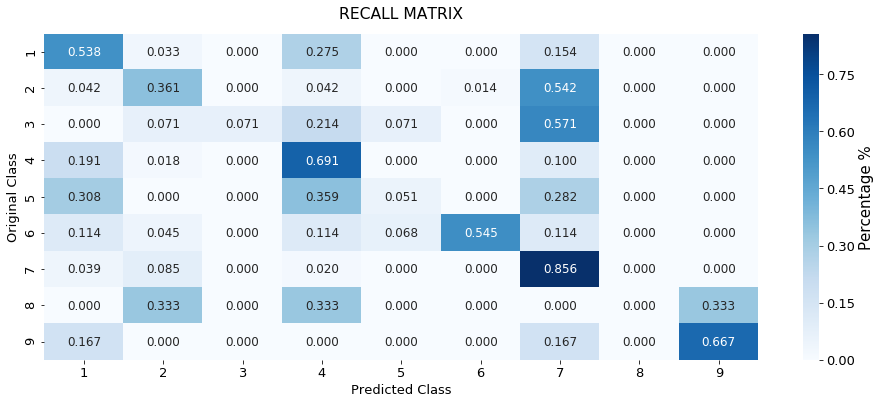

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


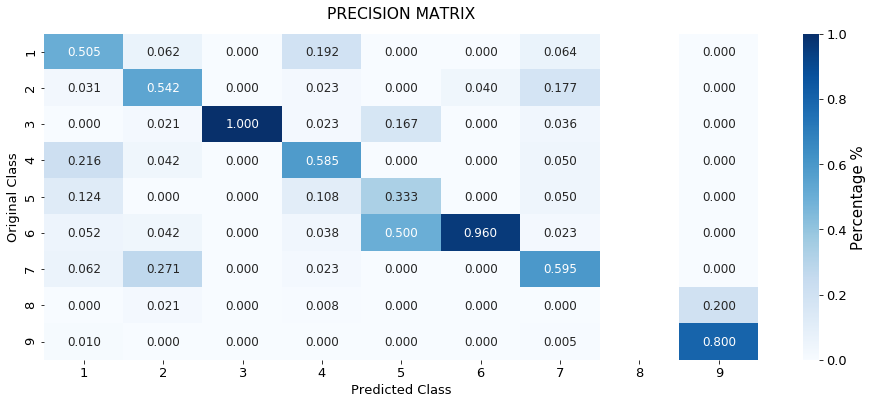

In [97]:
model = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h3>Feature Importance</h3>

<h4>Correctly Classified point</h4>

In [99]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.feature_importances_)[:tot_features]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 3 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [0.3191 0.0637 0.0219 0.4008 0.0576 0.0515 0.0668 0.0062 0.0125]
----------------------------------------------------------------------------------------------------
1 Text feature [missense] present in test data point [True]
5 Text feature [function] present in test data point [True]
11 Text feature [functional] present in test data point [True]
12 Text feature [loss] present in test data point [True]
15 Text feature [suppressor] present in test data point [True]
16 Text feature [oncogenic] present in test data point [True]
17 Text feature [signaling] present in test data point [True]
21 Text feature [cells] present in test data point [True]
27 Text feature [frameshift] present in test data point [True]
31 Text feature [expressing] present in test data point [True]
33 Text feature [variants] present in test data point [True]
39 Text feature [protein] present in test data point [Tru

<h4>Inorrectly Classified point</h4>

In [100]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.feature_importances_)[:tot_features]
        print("-"*100)
        
        get_impfeature_names(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.1248 0.463  0.0232 0.1488 0.0873 0.0521 0.0879 0.0059 0.007 ]
----------------------------------------------------------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [missense] present in test data point [True]
4 Text feature [tyrosine] present in test data point [True]
5 Text feature [function] present in test data point [True]
11 Text feature [functional] present in test data point [True]
20 Text feature [neutral] present in test data point [True]
21 Text feature [cells] present in test data point [True]
22 Text feature [oncogene] present in test data point [True]
23 Text feature [treatment] present in test data point [True]
30 Text feature [proliferation] present in test data point [True]
33 Text feature [variants] present in test data point [True]
38 Text feature [extracellular] present in test data point [

<h3>Hyper paramter tuning (With Response Coding)</h3>

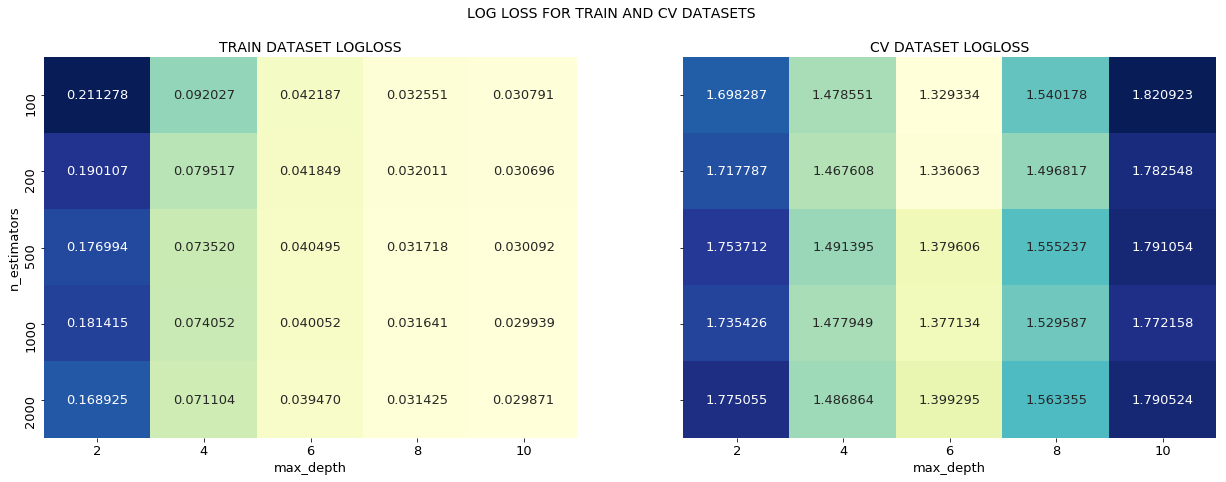

In [101]:
randomforest_hypertuning(X_tr_re,X_cv_re)

<h3>Testing model with best hyper parameters (Response Coding)</h3>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.04185     |     1.3625    |   1.33606   |       49.25 %       |
+----------------+---------------+-------------+---------------------+


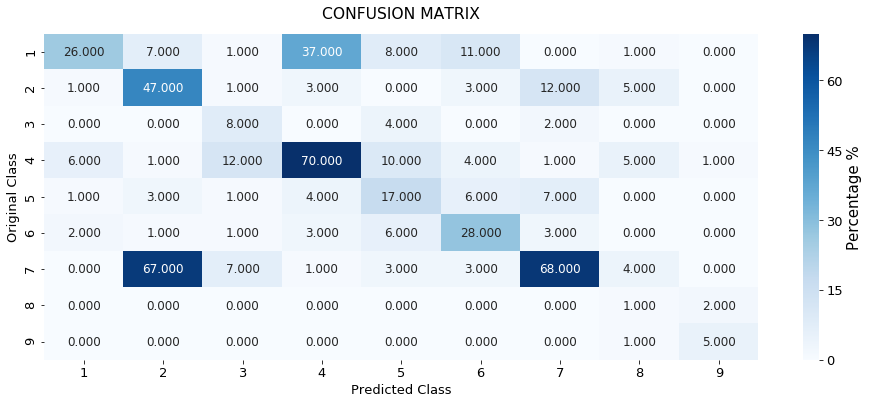

NOTE:-RECALL MATRIX (ROW SUM=1)


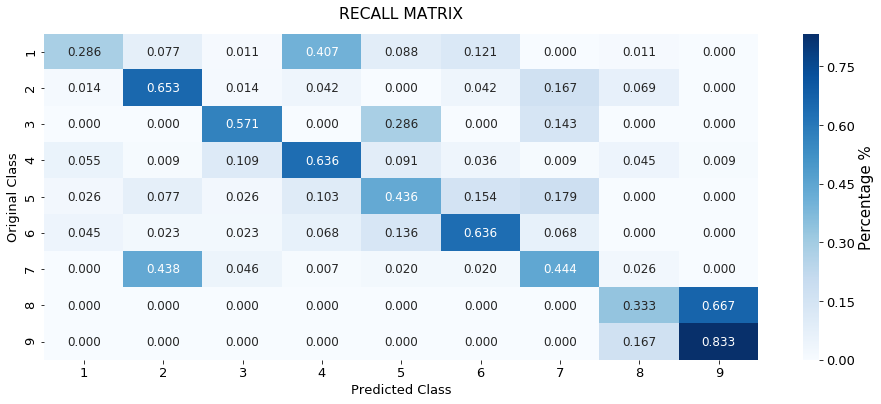

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


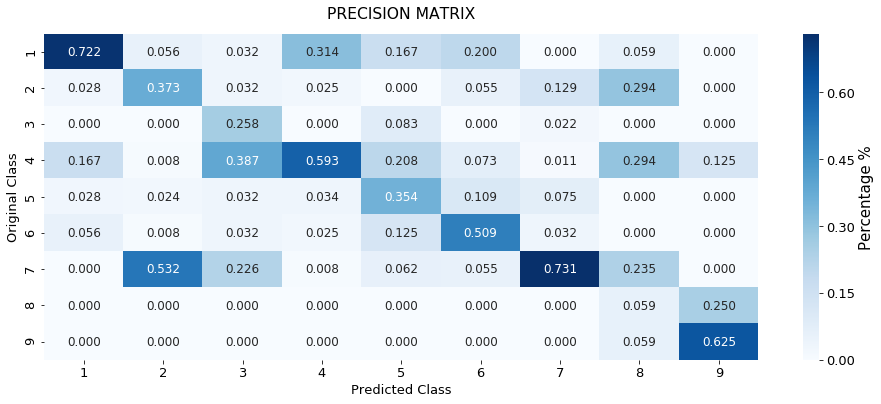

In [102]:
model = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=6, random_state=42, n_jobs=-1)
build_best_model(model,X_tr_re,y_train_model,X_te_re,y_test,X_cv_re,y_cv_model,True)

<h3>Feature Importance</h3>

<h4>Correctly Classified point</h4>

In [107]:
test_point_index = 5

model.fit(X_tr_re, y_train_model)

sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(X_tr_re, y_train_model)

predicted_cls = sig_clf.predict(X_te_re[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_te_re[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-model.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")


Predicted Class : 7
Predicted Class Probabilities: [[0.0026 0.0477 0.0014 0.0034 0.0014 0.0063 0.9337 0.0017 0.0018]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h4>Incorrectly Classified point</h4>

In [108]:
test_point_index = 1

model.fit(X_tr_re, y_train_model)

sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(X_tr_re, y_train_model)

predicted_cls = sig_clf.predict(X_te_re[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_te_re[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-model.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")


Predicted Class : 2
Predicted Class Probabilities: [[0.026  0.5213 0.0413 0.0431 0.1182 0.0525 0.1071 0.0573 0.0332]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h2>Stack the models </h2>

<h3>testing with hyper parameter tuning</h3>

In [110]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(X_tr_oe, y_train_model)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(X_tr_oe, y_train_model)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=1)
clf3.fit(X_tr_oe, y_train_model)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(X_tr_oe, y_train_model)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf1.predict_proba(X_cv_oe))))
sig_clf2.fit(X_tr_oe, y_train_model)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf2.predict_proba(X_cv_oe))))
sig_clf3.fit(X_tr_oe, y_train_model)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf3.predict_proba(X_cv_oe))))

print('-'*45)

c_values = [10**i for i in range(-5,5)] 
best_alpha = 999

table = PrettyTable()
table.hrules=True
table.field_names=["C", "Train_log_loss","Cv_Log_Loss"]

for i in tqdm.tqdm_notebook(c_values):
    
    clf= LogisticRegression(C=i)
    
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=clf, use_probas=True)
    sclf.fit(X_tr_oe, y_train_model)
    
    tr_log_loss=np.round(log_loss(y_train_model, sclf.predict_proba(X_tr_oe)),4)
    cv_log_loss=np.round(log_loss(y_cv_model, sclf.predict_proba(X_cv_oe)),4)
    
    table.add_row([i,tr_log_loss,cv_log_loss])

    if best_alpha > cv_log_loss:
        best_alpha = cv_log_loss

table.sortby='Cv_Log_Loss'
print(table)
del table


Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.15
Naive Bayes : Log Loss: 1.29
---------------------------------------------------------------------------



+--------+----------------+-------------+
|   C    | Train_log_loss | Cv_Log_Loss |
+--------+----------------+-------------+
|  0.1   |     0.6546     |    1.1334   |
+--------+----------------+-------------+
|   1    |     0.3806     |    1.1889   |
+--------+----------------+-------------+
|   10   |     0.2744     |    1.3857   |
+--------+----------------+-------------+
|  0.01  |     1.3149     |    1.4636   |
+--------+----------------+-------------+
|  100   |     0.2273     |    1.662    |
+--------+----------------+-------------+
|  1000  |     0.2108     |    1.8886   |
+--------+----------------+-------------+
| 0.001  |     1.9982     |    2.0133   |
+--------+----------------+-------------+
| 10000  |     0.2051     |    2.1581   |
+--------+----------------+-------------+
| 0.0001 |     2.1742     |    2.1754   |
+--------+----------------+-------------+
| 1e-05  |     2.1949     |    2.195    |
+--------+----------------+-------------+


<h3>testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.6546386637504518
Log loss (CV) on the stacking classifier : 1.1334067861558315
Log loss (test) on the stacking classifier : 1.1366731503225256
Number of missclassified point : 37.44


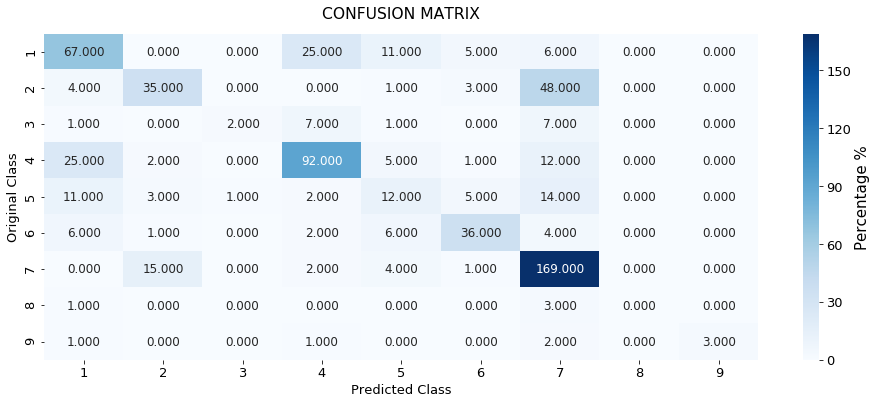

NOTE:-RECALL MATRIX (ROW SUM=1)


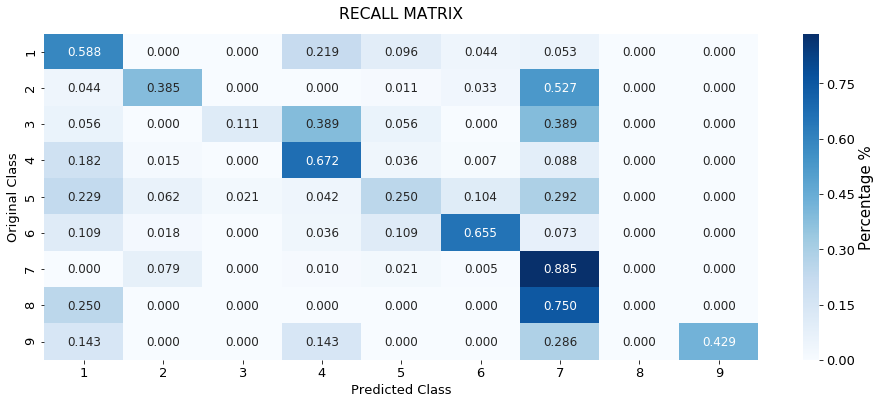

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


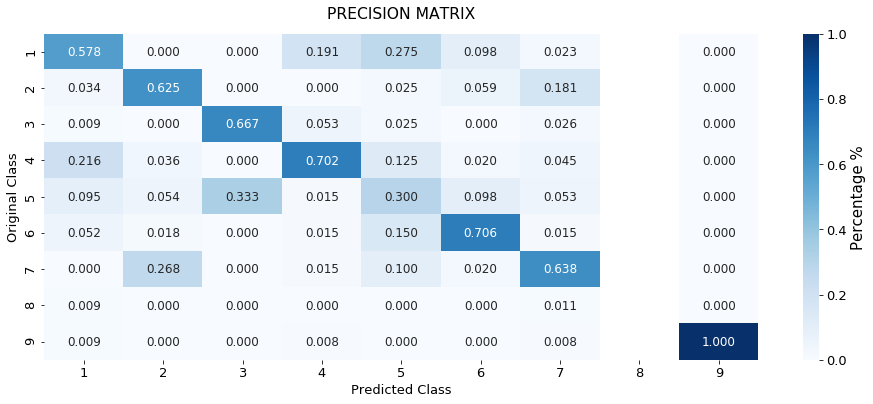

In [113]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(X_tr_oe, y_train_model)

log_error = log_loss(y_train_model, sclf.predict_proba(X_tr_oe))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv_model, sclf.predict_proba(X_cv_oe))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(X_te_oe))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.round(np.count_nonzero((sclf.predict(X_te_oe)- y_test))/y_test.shape[0]*100,2))
plot_confusion_matrix(y_test,sclf.predict(X_te_oe))

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.7293975021519067
Log loss (CV) on the VotingClassifier : 1.0939168398845545
Log loss (test) on the VotingClassifier : 1.1066702054638577
Number of missclassified point : 36.69


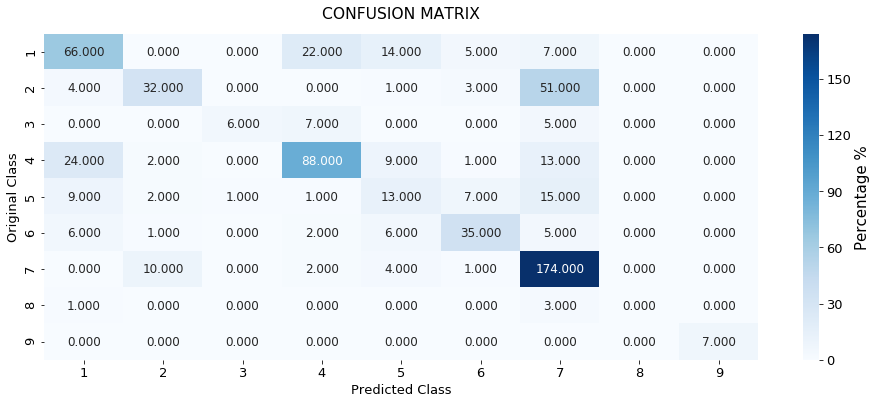

NOTE:-RECALL MATRIX (ROW SUM=1)


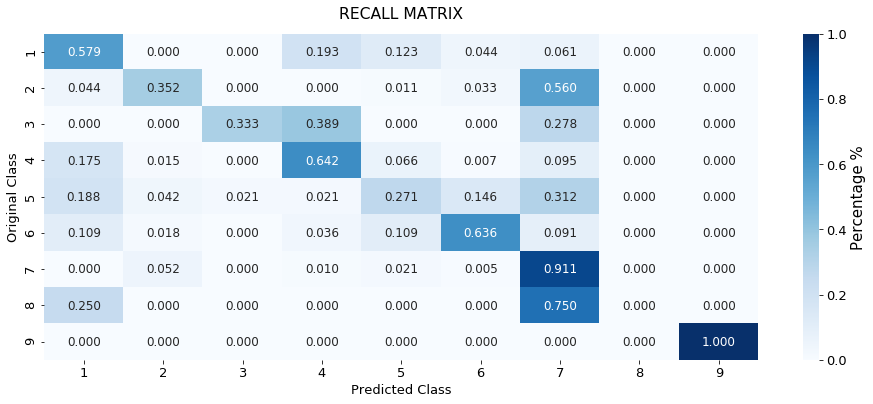

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


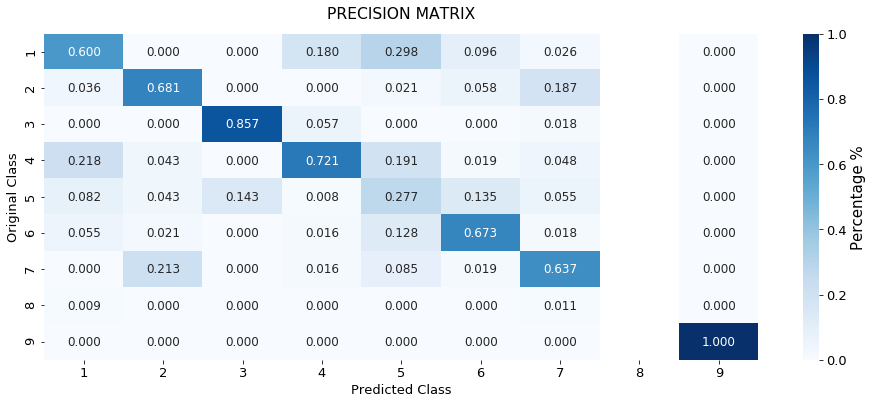

In [114]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(X_tr_oe, y_train_model)

print("Log loss (train) on the VotingClassifier :", log_loss(y_train_model, vclf.predict_proba(X_tr_oe)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv_model, vclf.predict_proba(X_cv_oe)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(X_te_oe)))
print("Number of missclassified point :", np.round(np.count_nonzero((vclf.predict(X_te_oe)- y_test))/y_test.shape[0]*100,2))

plot_confusion_matrix(y_test,vclf.predict(X_te_oe))

In [132]:
del X_tr_oe
del X_te_oe
del X_cv_oe

## TF-IDF

In [133]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names_tfidf(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train_model['Gene'])
    var_vec  = var_count_vec.fit(X_train_model['Variation'])
    text_vec = text_count_vec.fit(X_train_model['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [134]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [135]:
tfvectorizer = TfidfVectorizer(min_df=3)
X_tr_text_oe_tfidf = tfvectorizer.fit_transform(X_train_model['Text'])

select_1000 = SelectKBest(chi2, k=1000).fit(X_tr_text_oe_tfidf,y_train_model)

X_tr_tfidf_1000=select_1000.transform(X_tr_text_oe_tfidf)

# don't forget to normalize every feature
X_tr_text_oe_tfidf = normalize(X_tr_text_oe_tfidf, axis=0)
X_tr_tfidf_1000=normalize(X_tr_tfidf_1000, axis=0)

X_te_text_oe_tfidf = tfvectorizer.transform(X_test['Text'])
X_te_tfidf_1000=select_1000.transform(X_te_text_oe_tfidf)

X_te_text_oe_tfidf = normalize(X_te_text_oe_tfidf, axis=0)
X_te_tfidf_1000=normalize(X_te_tfidf_1000, axis=0)


X_cv_text_oe_tfidf = tfvectorizer.transform(X_cv_model['Text'])
X_cv_tfidf_1000=select_1000.transform(X_cv_text_oe_tfidf)

X_cv_text_oe_tfidf = normalize(X_cv_text_oe_tfidf, axis=0)
X_cv_tfidf_1000=normalize(X_cv_tfidf_1000, axis=0)

In [136]:
X_tr_oe_tfidf = hstack((X_tr_f,X_tr_text_oe_tfidf)).tocsr()
X_te_oe_tfidf = hstack((X_te_f,X_te_text_oe_tfidf)).tocsr()
X_cv_oe_tfidf = hstack((X_cv_f,X_cv_text_oe_tfidf)).tocsr()

print("\nAfter One hot encoding  using Tfidf:\n".upper())
print("train data shape : ", X_tr_oe_tfidf.shape)
print("test data shape : ", X_te_oe_tfidf.shape)
print("cross validation data  shape :", X_cv_oe_tfidf.shape)

X_tr_oe_1000 = hstack((X_tr_f,X_tr_tfidf_1000)).tocsr()
X_te_oe_1000 = hstack((X_te_f,X_te_tfidf_1000)).tocsr()
X_cv_oe_1000 = hstack((X_cv_f,X_cv_tfidf_1000)).tocsr()

print("\nAfter One hot encoding  using tfidf top 1000 features:\n".upper())
print("train data shape : ", X_tr_oe_1000.shape)
print("test data shape : ", X_te_oe_1000.shape)
print("cross validation data  shape :", X_cv_oe_1000.shape)


AFTER ONE HOT ENCODING  USING TFIDF:

train data shape :  (2124, 55500)
test data shape :  (665, 55500)
cross validation data  shape : (532, 55500)

AFTER ONE HOT ENCODING  USING TFIDF TOP 1000 FEATURES:

train data shape :  (2124, 3190)
test data shape :  (665, 3190)
cross validation data  shape : (532, 3190)


In [137]:
X_tr_oe=X_tr_oe_tfidf
X_te_oe=X_te_oe_tfidf
X_cv_oe=X_cv_oe_tfidf

<h3>Naive Bayes</h3>

<h4>Hyper parameter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
|   1    |     0.8888     |   1.28537   |
+--------+----------------+-------------+
| 0.001  |    0.84611     |   1.29692   |
+--------+----------------+-------------+
| 1e-05  |    0.83869     |   1.29978   |
+--------+----------------+-------------+
|  0.01  |    0.87459     |   1.30662   |
+--------+----------------+-------------+
| 0.0001 |    0.84202     |   1.30669   |
+--------+----------------+-------------+
|  0.1   |    0.89222     |    1.3088   |
+--------+----------------+-------------+
|   10   |    0.99104     |   1.33743   |
+--------+----------------+-------------+


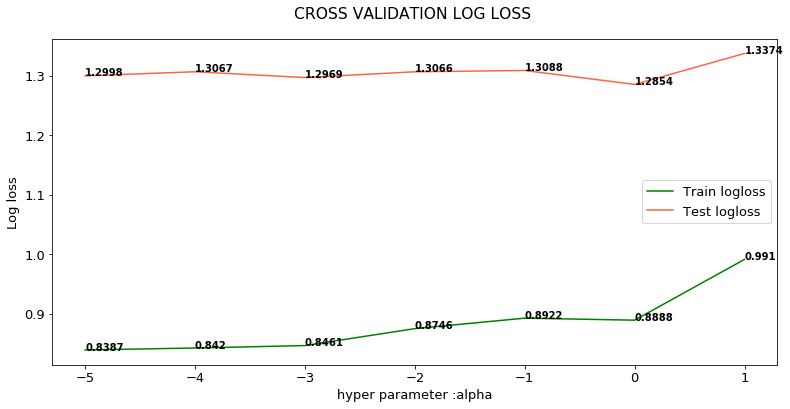

In [138]:
model=MultinomialNB()
alpha_values=[10**i for i in range(-5,2)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing the model with best hyper paramters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|     0.8888     |    1.28762    |   1.28537   |       38.53 %       |
+----------------+---------------+-------------+---------------------+


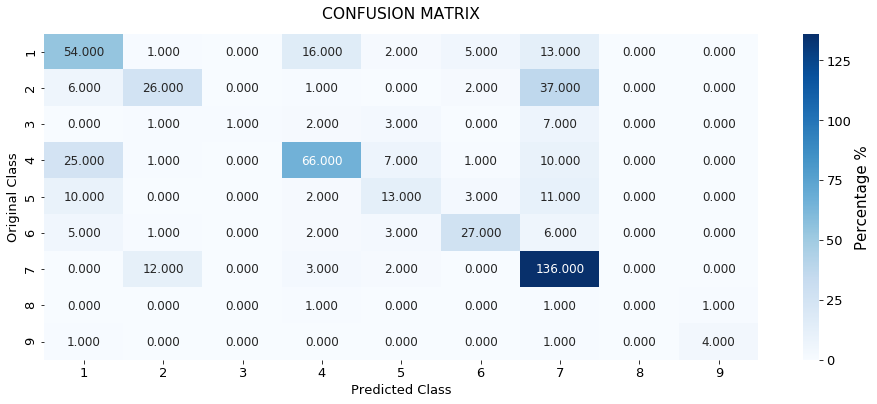

NOTE:-RECALL MATRIX (ROW SUM=1)


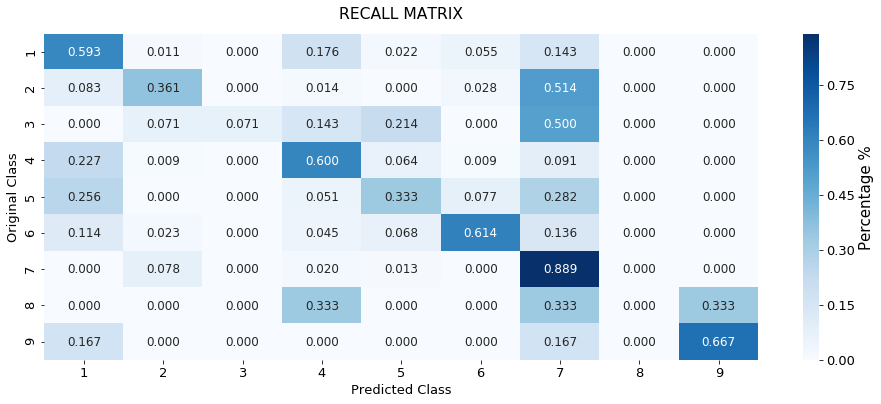

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


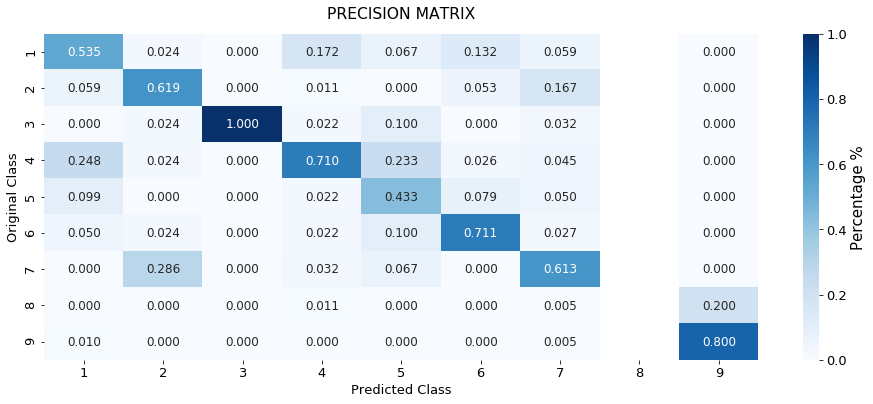

In [139]:
model.alpha=10**0
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h4>Feature Importance, Correctly classified point</h4>

In [140]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 3 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [0.0727 0.0798 0.0224 0.4752 0.0461 0.0363 0.2573 0.0046 0.0055]
----------------------------------------------------------------------------------------------------
6 Text feature [proteins] present in test data point [True]
7 Text feature [activity] present in test data point [True]
8 Text feature [protein] present in test data point [True]
9 Text feature [experiments] present in test data point [True]
14 Text feature [acid] present in test data point [True]
15 Text feature [loss] present in test data point [True]
16 Text feature [whereas] present in test data point [True]
17 Text feature [function] present in test data point [True]
19 Text feature [indicated] present in test data point [True]
20 Text feature [amino] present in test data point [True]
21 Text feature [shown] present in test data point [True]
22 Text feature [whether] present in test data point [True]
23 Text featur

<h4>Feature Importance, Incorrectly classified point</h4>

In [141]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.0847 0.4555 0.0261 0.106  0.19   0.0419 0.0839 0.0054 0.0065]
----------------------------------------------------------------------------------------------------
12 Text feature [treatment] present in test data point [True]
13 Text feature [patients] present in test data point [True]
15 Text feature [time] present in test data point [True]
17 Text feature [molecular] present in test data point [True]
19 Text feature [clinical] present in test data point [True]
21 Text feature [advanced] present in test data point [True]
23 Text feature [treated] present in test data point [True]
26 Text feature [study] present in test data point [True]
27 Text feature [first] present in test data point [True]
29 Text feature [patient] present in test data point [True]
30 Text feature [performed] present in test data point [True]
32 Text feature [confirmed] present in test data point [True]
34 Te

<h2>Logistic Regression(With Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.001  |     0.5833     |   1.10865   |
+--------+----------------+-------------+
|  0.01  |    0.67095     |   1.17873   |
+--------+----------------+-------------+
|  0.1   |    1.07512     |   1.22685   |
+--------+----------------+-------------+
| 0.0001 |     0.9355     |   1.25775   |
+--------+----------------+-------------+
| 1e-05  |    1.00148     |   1.32541   |
+--------+----------------+-------------+
|   1    |    1.36239     |   1.41361   |
+--------+----------------+-------------+
|   10   |    1.40981     |   1.45533   |
+--------+----------------+-------------+
|  100   |    1.41491     |   1.45999   |
+--------+----------------+-------------+
|  1000  |     1.4156     |    1.4607   |
+--------+----------------+-------------+


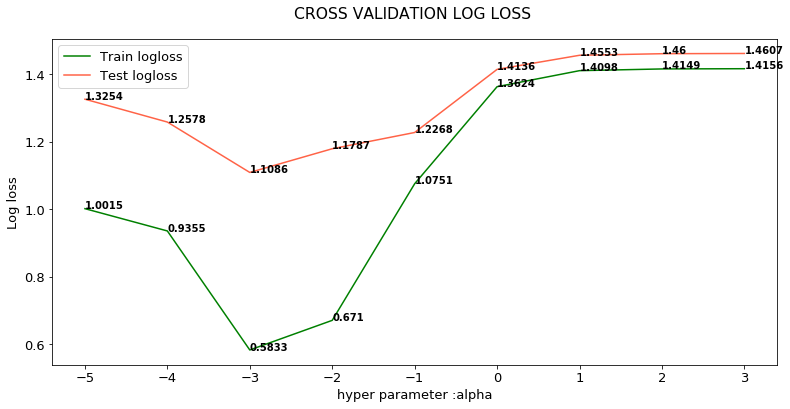

In [142]:
model=SGDClassifier()
model.class_weight='balanced'
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing the model with best hyper paramters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.58196     |    1.06037    |   1.09763   |       36.09 %       |
+----------------+---------------+-------------+---------------------+


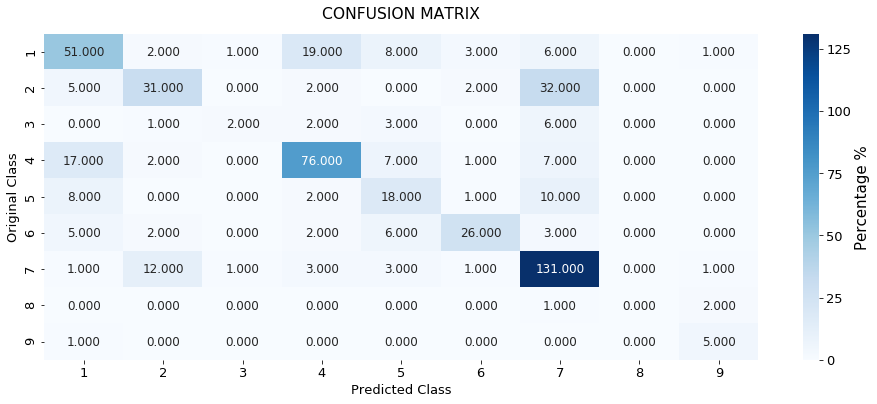

NOTE:-RECALL MATRIX (ROW SUM=1)


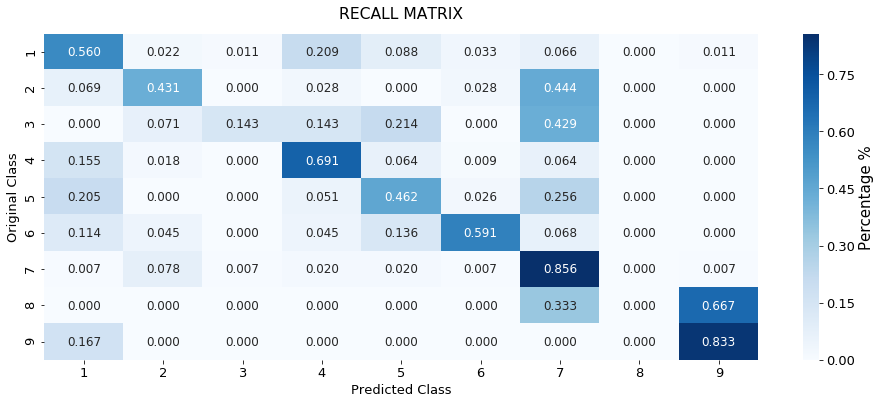

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


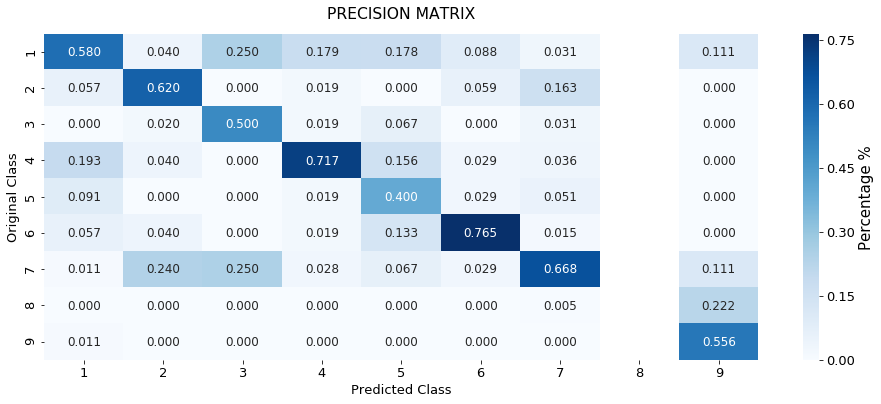

In [127]:
model.alpha=10**-3
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h4>Feature Importance</h4>

<h5>Correctly Classified point</h5>

In [144]:
tot_features=100

for index in range(100,150):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 100 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [6.550e-02 9.290e-02 1.060e-02 7.013e-01 3.580e-02 6.300e-03 8.360e-02
 3.900e-03 1.000e-04]
----------------------------------------------------------------------------------------------------
3 Text feature [s170r] present in test data point [True]
4 Text feature [dic8] present in test data point [True]
5 Text feature [h93y] present in test data point [True]
6 Text feature [hamartoma] present in test data point [True]
7 Text feature [r130g] present in test data point [True]
8 Text feature [v343e] present in test data point [True]
9 Text feature [g129r] present in test data point [True]
10 Text feature [y155c] present in test data point [True]
11 Text feature [f347l] present in test data point [True]
12 Text feature [g129e] present in test data point [True]
13 Text feature [pten] present in test data point [True]
15 Text feature [dephosphorylate] present in test data point [True]

<h5>Incorrectly Classified point</h5>

In [145]:
tot_features=100

for index in range(100,150):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 101 from the test data
Predicted Class : [7]
Actual Class : 2
Predicted Class Probabilities: [1.334e-01 2.988e-01 8.200e-03 4.560e-02 6.720e-02 1.350e-02 4.257e-01
 7.500e-03 1.000e-04]
----------------------------------------------------------------------------------------------------
Out of the top  100  features  0 are present in query point


<h2>Logistic Regression(With out Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.001  |    0.57683     |    1.1176   |
+--------+----------------+-------------+
|  0.01  |    0.65487     |   1.21363   |
+--------+----------------+-------------+
|  0.1   |    0.99837     |   1.22173   |
+--------+----------------+-------------+
| 0.0001 |    0.94061     |   1.31153   |
+--------+----------------+-------------+
| 1e-05  |    0.99292     |   1.31813   |
+--------+----------------+-------------+
|   1    |    1.28561     |   1.41965   |
+--------+----------------+-------------+
|   10   |    1.33752     |   1.48321   |
+--------+----------------+-------------+
|  100   |    1.34377     |   1.49036   |
+--------+----------------+-------------+
|  1000  |    1.34454     |   1.49135   |
+--------+----------------+-------------+


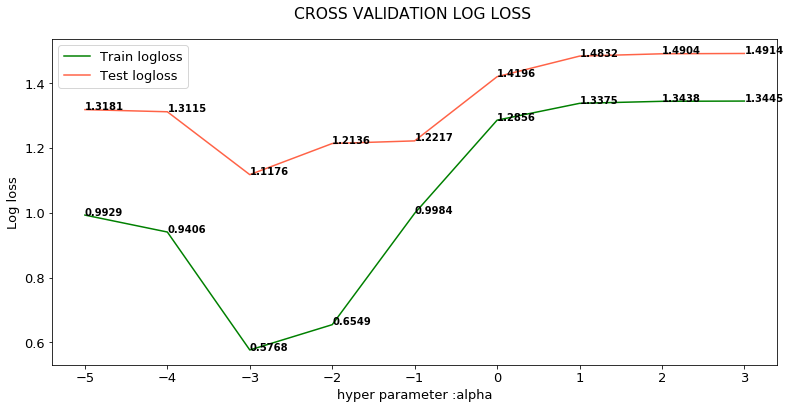

In [146]:
model=SGDClassifier()
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing model with best hyper parameters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.56922     |    1.08154    |   1.11758   |       37.22 %       |
+----------------+---------------+-------------+---------------------+


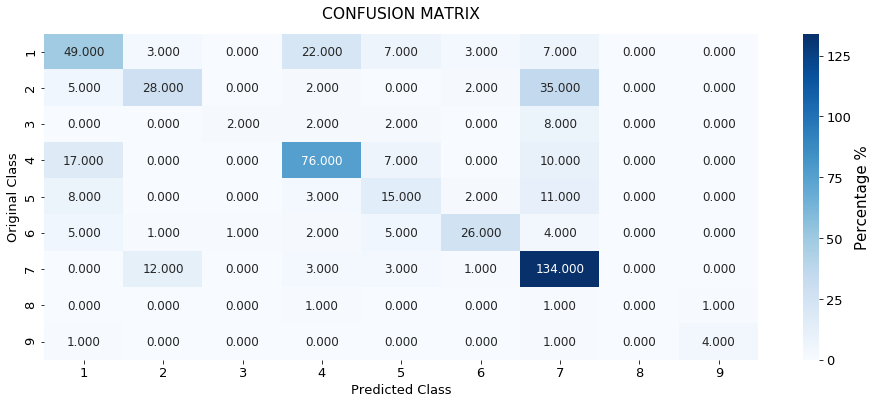

NOTE:-RECALL MATRIX (ROW SUM=1)


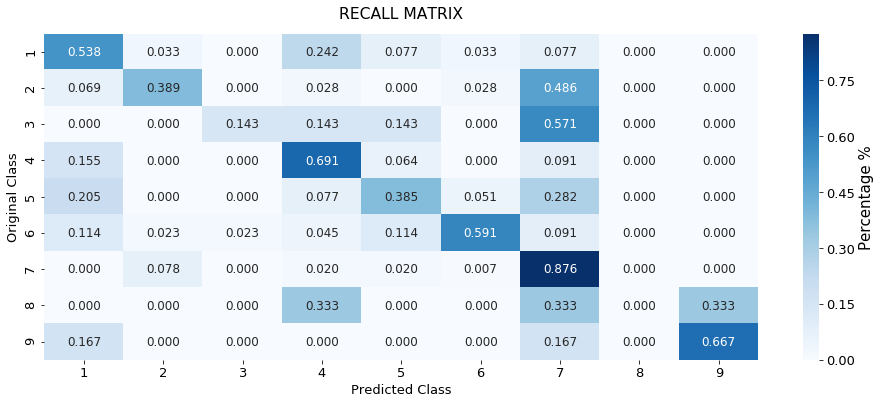

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


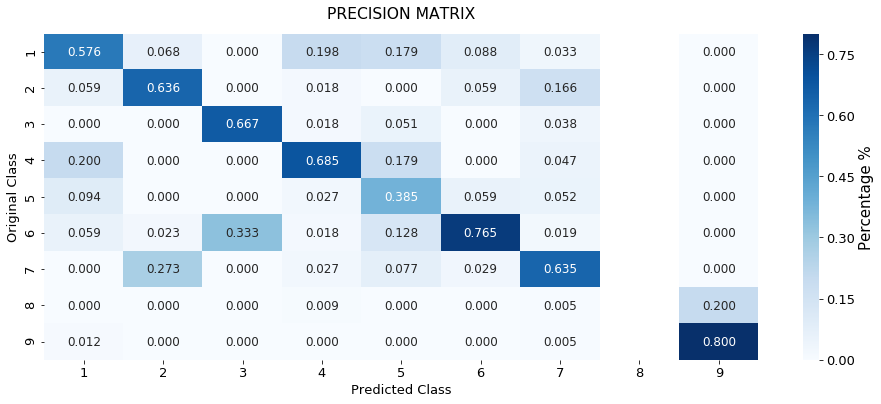

In [147]:
model.alpha=10**-3
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h4>Feature Importance, Correctly Classified point</h4>

In [156]:
tot_features=500

for index in range(20,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 20 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [4.100e-03 9.300e-03 8.000e-04 9.719e-01 3.300e-03 1.300e-03 8.800e-03
 5.000e-04 1.000e-04]
----------------------------------------------------------------------------------------------------
241 Text feature [germline] present in test data point [True]
265 Text feature [cycloheximide] present in test data point [True]
274 Text feature [immunocytochemistry] present in test data point [True]
453 Text feature [suppressor] present in test data point [True]
476 Text feature [inactivating] present in test data point [True]
Out of the top  500  features  5 are present in query point


<h4>Feature Importance, Inorrectly Classified point</h4>

In [157]:
tot_features=500

for index in range(20,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 21 from the test data
Predicted Class : [4]
Actual Class : 1
Predicted Class Probabilities: [0.2269 0.0555 0.0051 0.4066 0.023  0.0085 0.2712 0.0023 0.0008]
----------------------------------------------------------------------------------------------------
301 Text feature [cycloheximide] present in test data point [True]
356 Text feature [inactivating] present in test data point [True]
467 Text feature [apparently] present in test data point [True]
Out of the top  500  features  3 are present in query point


<h2>Linear Support Vector Machines</h2>

<h3>Hyper paramter tuning</h3>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
|  0.01  |    0.72219     |    1.1762   |
+--------+----------------+-------------+
| 0.001  |    0.82055     |   1.24425   |
+--------+----------------+-------------+
|  0.1   |    1.03624     |   1.25369   |
+--------+----------------+-------------+
| 1e-05  |    1.01484     |   1.31949   |
+--------+----------------+-------------+
| 0.0001 |    0.99481     |   1.32101   |
+--------+----------------+-------------+
|   1    |    1.41334     |   1.45891   |
+--------+----------------+-------------+
|   10   |    1.41584     |   1.46096   |
+--------+----------------+-------------+
|  100   |    1.41584     |   1.46096   |
+--------+----------------+-------------+
|  1000  |    1.41584     |   1.46096   |
+--------+----------------+-------------+


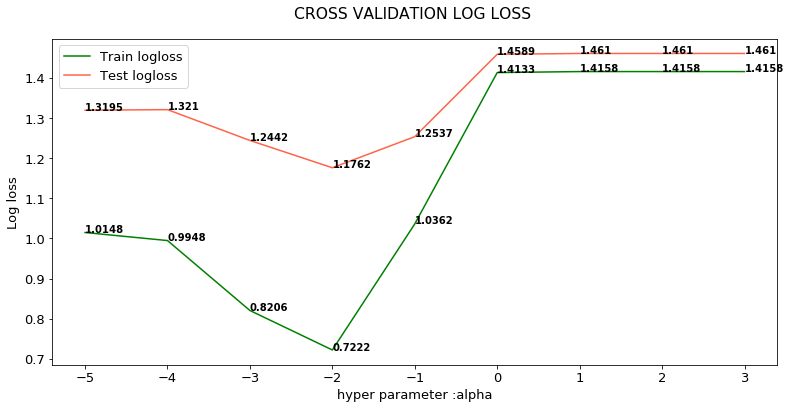

In [158]:
model=SGDClassifier()
model.loss='hinge'
model.class_weight='balanced'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h3>Testing model with best hyper parameters</h3>

+----------------+---------------+-------------+----------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct  |
+----------------+---------------+-------------+----------------------+
|     0.728      |    1.13529    |   1.16297   | 35.709999999999994 % |
+----------------+---------------+-------------+----------------------+


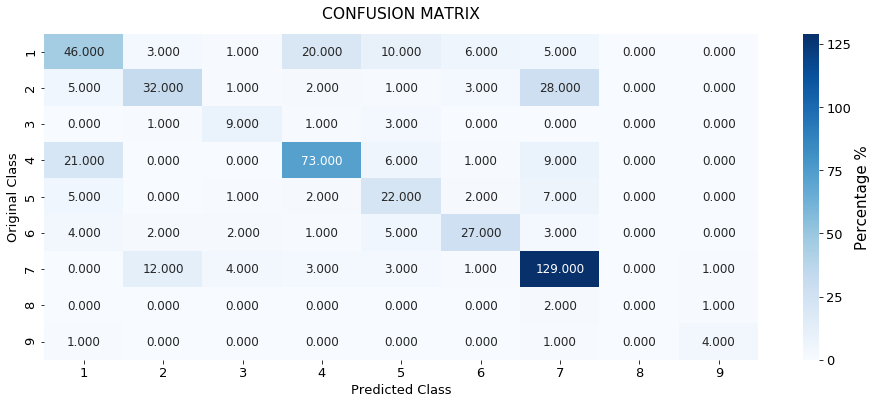

NOTE:-RECALL MATRIX (ROW SUM=1)


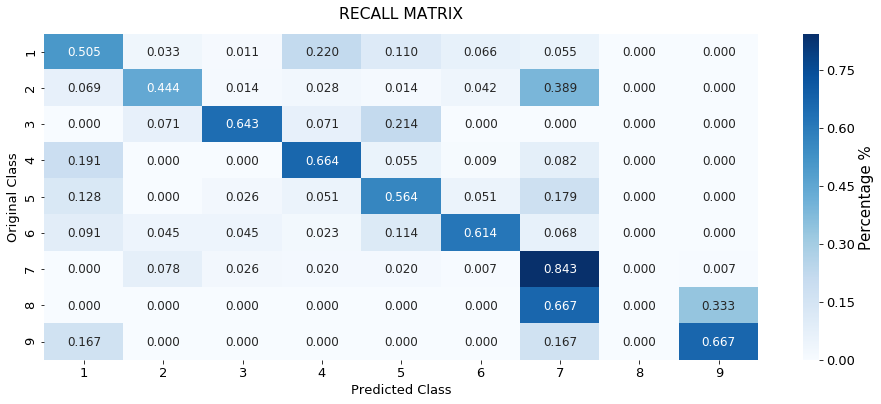

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


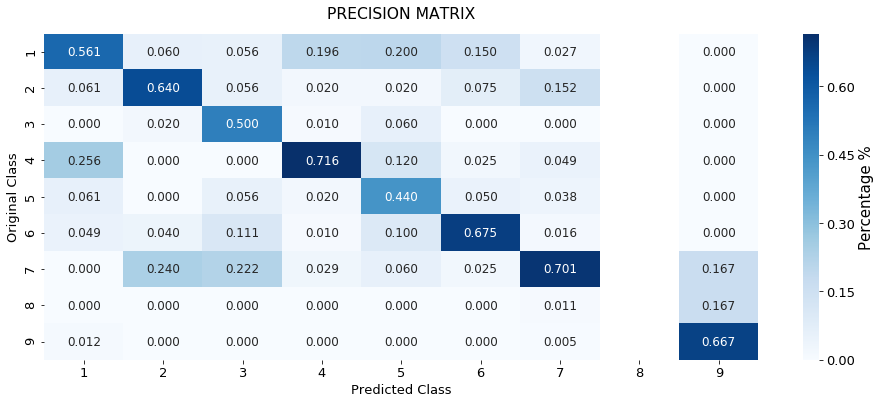

In [159]:
model.alpha=10**-2
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h3>Feature Importance</h3>

<h4>For Correctly classified point</h4>

In [160]:
tot_features=500

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls == actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 3 from the test data
Predicted Class : [4]
Actual Class : 4
Predicted Class Probabilities: [0.0578 0.0436 0.0088 0.6684 0.0289 0.0092 0.173  0.0064 0.0038]
----------------------------------------------------------------------------------------------------
170 Text feature [improvision] present in test data point [True]
265 Text feature [germline] present in test data point [True]
365 Text feature [suppressor] present in test data point [True]
499 Text feature [pmdlg] present in test data point [True]
Out of the top  500  features  4 are present in query point


<h4>For Incorrectly classified point</h4>

In [161]:
tot_features=500

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.coef_)[predicted_cls-1][:,:tot_features][0]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.0043 0.611  0.0073 0.0117 0.3389 0.002  0.0177 0.0047 0.0026]
----------------------------------------------------------------------------------------------------
65 Text feature [surgical] present in test data point [True]
232 Text feature [step] present in test data point [True]
Out of the top  500  features  2 are present in query point


<h2>Random Forest Classifier</h2>

<h3>Hyper paramter tuning (With One hot Encoding)</h3>

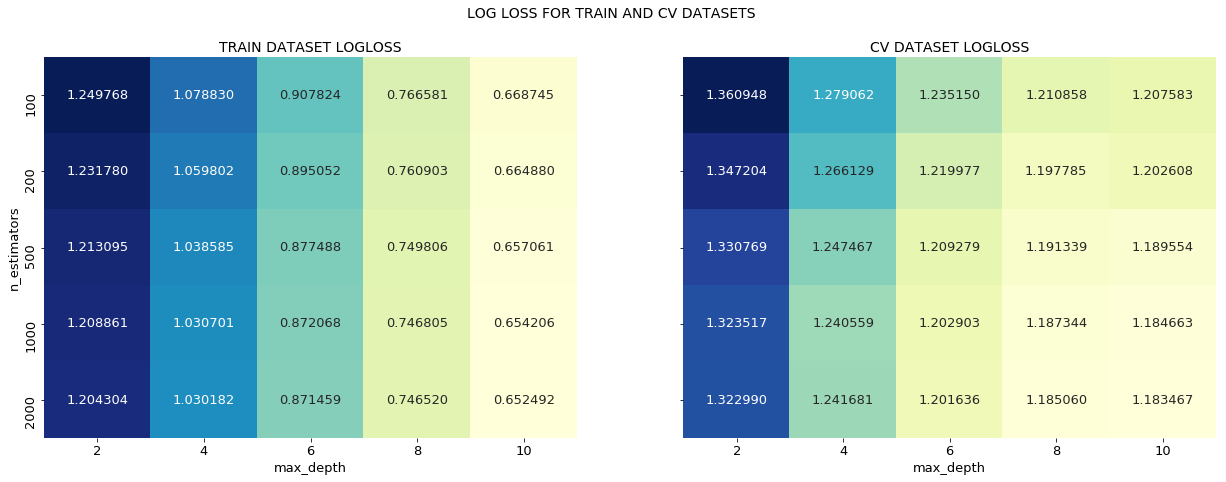

In [162]:
randomforest_hypertuning(X_tr_oe,X_cv_oe)

<h3>Testing model with best hyper parameters (One Hot Encoding)</h3>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.65706     |    1.15383    |   1.18955   |       41.54 %       |
+----------------+---------------+-------------+---------------------+


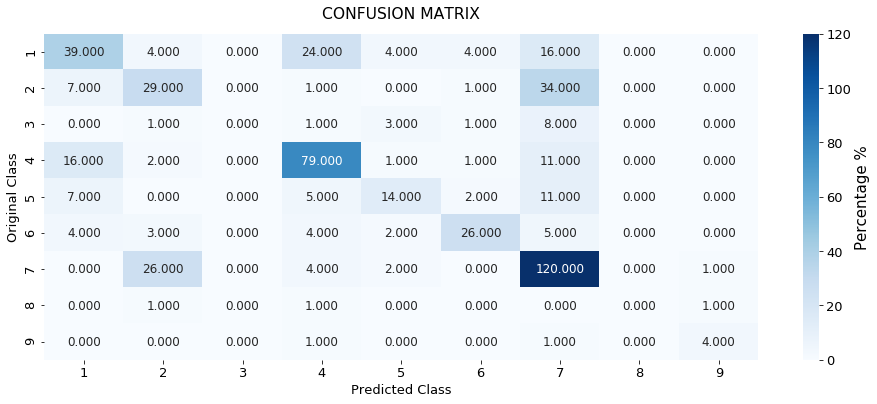

NOTE:-RECALL MATRIX (ROW SUM=1)


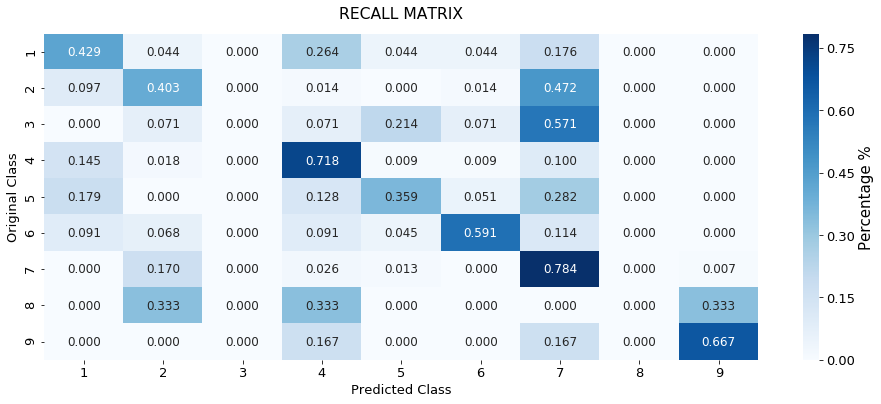

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


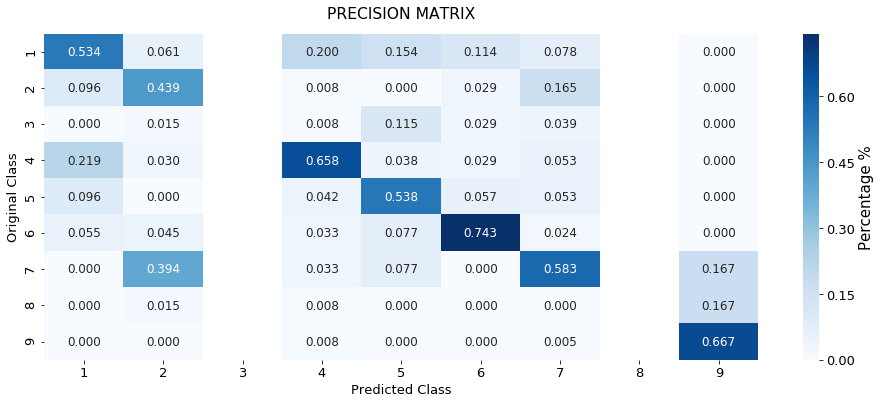

In [163]:
model = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h3>Feature Importance</h3>

<h4>Correctly Classified point</h4>

In [164]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.feature_importances_)[:tot_features]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.0863 0.5372 0.0224 0.1024 0.097  0.0547 0.0872 0.0054 0.0073]
----------------------------------------------------------------------------------------------------
0 Text feature [kinase] present in test data point [True]
7 Text feature [oncogene] present in test data point [True]
8 Text feature [growth] present in test data point [True]
10 Text feature [tyrosine] present in test data point [True]
15 Text feature [missense] present in test data point [True]
16 Text feature [function] present in test data point [True]
17 Text feature [proliferation] present in test data point [True]
20 Text feature [extracellular] present in test data point [True]
22 Text feature [cells] present in test data point [True]
27 Text feature [variants] present in test data point [True]
28 Text feature [deleterious] present in test data point [True]
29 Text feature [functional] present in test data point

<h4>Inorrectly Classified point</h4>

In [165]:
tot_features=100

for index in range(1,50):
    
    predicted_values=predict_future_q_point(model,X_tr_oe,X_te_oe,y_train_model,y_test,index)
    
    predicted_cls=predicted_values[0]
    actual_cls=predicted_values[1]
    class_probs=predicted_values[2][0]
    
    if(predicted_cls != actual_cls):
        
        print("For the index {} from the test data".format(index))
        print("Predicted Class :", predicted_cls)
        print("Actual Class :", actual_cls)
        print("Predicted Class Probabilities:",class_probs)
        
        indices = np.argsort(-model.feature_importances_)[:tot_features]
        print("-"*100)
        
        get_impfeature_names_tfidf(indices, X_test['Text'].iloc[index],X_test['Gene'].iloc[index],
                     X_test['Variation'].iloc[index],tot_features )
        
        break

For the index 1 from the test data
Predicted Class : [2]
Actual Class : 5
Predicted Class Probabilities: [0.0863 0.5372 0.0224 0.1024 0.097  0.0547 0.0872 0.0054 0.0073]
----------------------------------------------------------------------------------------------------
0 Text feature [kinase] present in test data point [True]
7 Text feature [oncogene] present in test data point [True]
8 Text feature [growth] present in test data point [True]
10 Text feature [tyrosine] present in test data point [True]
15 Text feature [missense] present in test data point [True]
16 Text feature [function] present in test data point [True]
17 Text feature [proliferation] present in test data point [True]
20 Text feature [extracellular] present in test data point [True]
22 Text feature [cells] present in test data point [True]
27 Text feature [variants] present in test data point [True]
28 Text feature [deleterious] present in test data point [True]
29 Text feature [functional] present in test data point

<h2>Stack the models </h2>

<h3>testing with hyper parameter tuning</h3>

In [167]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(X_tr_oe, y_train_model)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(X_tr_oe, y_train_model)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=1)
clf3.fit(X_tr_oe, y_train_model)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(X_tr_oe, y_train_model)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf1.predict_proba(X_cv_oe))))
sig_clf2.fit(X_tr_oe, y_train_model)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf2.predict_proba(X_cv_oe))))
sig_clf3.fit(X_tr_oe, y_train_model)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf3.predict_proba(X_cv_oe))))

print('-'*45)

c_values = [10**i for i in range(-5,5)] 
best_alpha = 999

table = PrettyTable()
table.hrules=True
table.field_names=["C", "Train_log_loss","Cv_Log_Loss"]

for i in tqdm.tqdm_notebook(c_values):
    
    clf= LogisticRegression(C=i)
    
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=clf, use_probas=True)
    sclf.fit(X_tr_oe, y_train_model)
    
    tr_log_loss=np.round(log_loss(y_train_model, sclf.predict_proba(X_tr_oe)),4)
    cv_log_loss=np.round(log_loss(y_cv_model, sclf.predict_proba(X_cv_oe)),4)
    
    table.add_row([i,tr_log_loss,cv_log_loss])

    if best_alpha > cv_log_loss:
        best_alpha = cv_log_loss

table.sortby='Cv_Log_Loss'
print(table)
del table


Logistic Regression :  Log Loss: 1.10
Support vector machines : Log Loss: 1.17
Naive Bayes : Log Loss: 1.29
---------------------------------------------



+--------+----------------+-------------+
|   C    | Train_log_loss | Cv_Log_Loss |
+--------+----------------+-------------+
|  0.1   |     0.6143     |    1.1377   |
+--------+----------------+-------------+
|   1    |     0.3568     |    1.2334   |
+--------+----------------+-------------+
|   10   |     0.2679     |    1.411    |
+--------+----------------+-------------+
|  0.01  |     1.2837     |    1.4379   |
+--------+----------------+-------------+
|  100   |     0.2353     |    1.5884   |
+--------+----------------+-------------+
|  1000  |     0.2259     |    1.732    |
+--------+----------------+-------------+
| 10000  |     0.2224     |    1.8644   |
+--------+----------------+-------------+
| 0.001  |     1.9933     |    2.0072   |
+--------+----------------+-------------+
| 0.0001 |     2.1738     |    2.1748   |
+--------+----------------+-------------+
| 1e-05  |     2.1949     |    2.195    |
+--------+----------------+-------------+


<h3>testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.6142976131408638
Log loss (CV) on the stacking classifier : 1.13768308617706
Log loss (test) on the stacking classifier : 1.1333179045361406
Number of missclassified point : 37.74


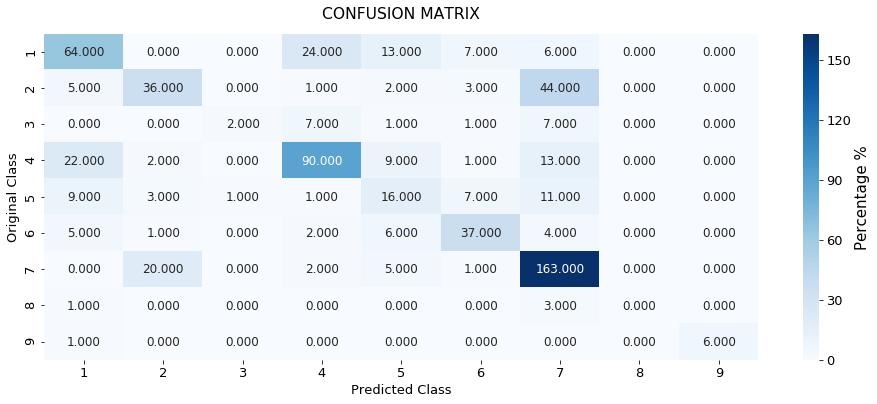

NOTE:-RECALL MATRIX (ROW SUM=1)


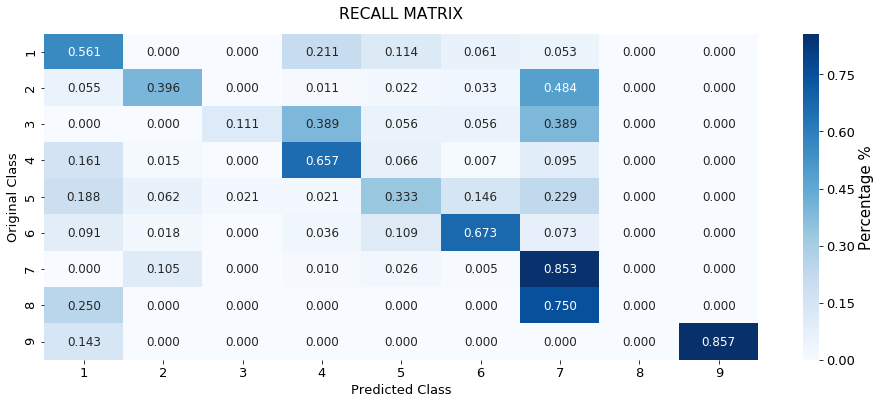

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


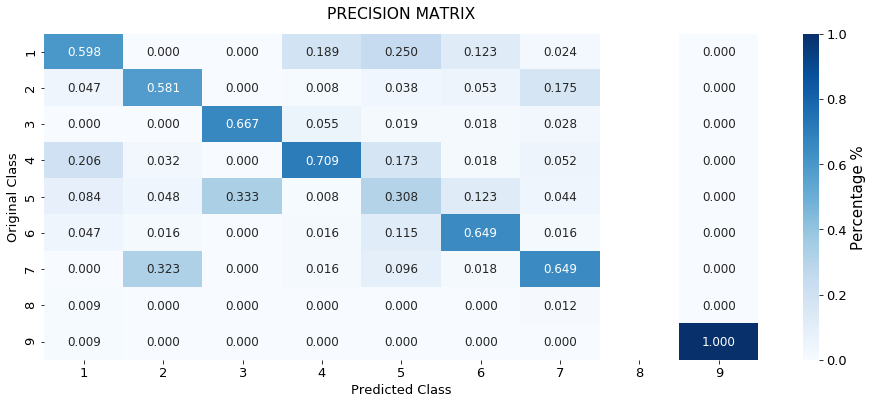

In [168]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(X_tr_oe, y_train_model)

log_error = log_loss(y_train_model, sclf.predict_proba(X_tr_oe))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv_model, sclf.predict_proba(X_cv_oe))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(X_te_oe))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.round(np.count_nonzero((sclf.predict(X_te_oe)- y_test))/y_test.shape[0]*100,2))
plot_confusion_matrix(y_test,sclf.predict(X_te_oe))

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.6964070153430267
Log loss (CV) on the VotingClassifier : 1.0833654911104582
Log loss (test) on the VotingClassifier : 1.0875739309098353
Number of missclassified point : 37.14


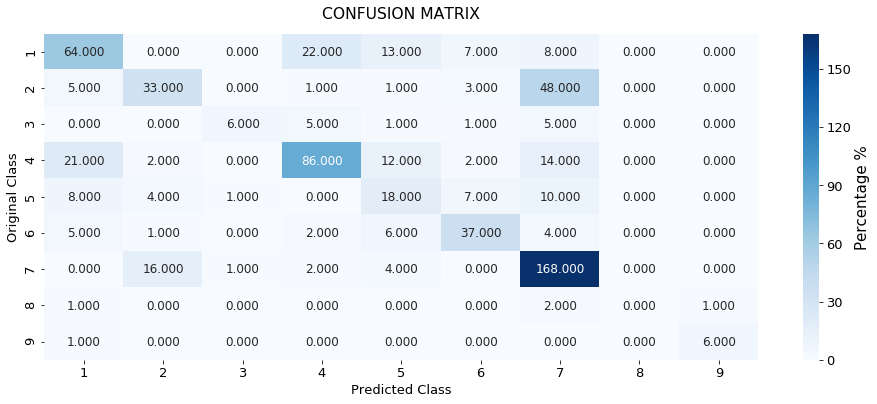

NOTE:-RECALL MATRIX (ROW SUM=1)


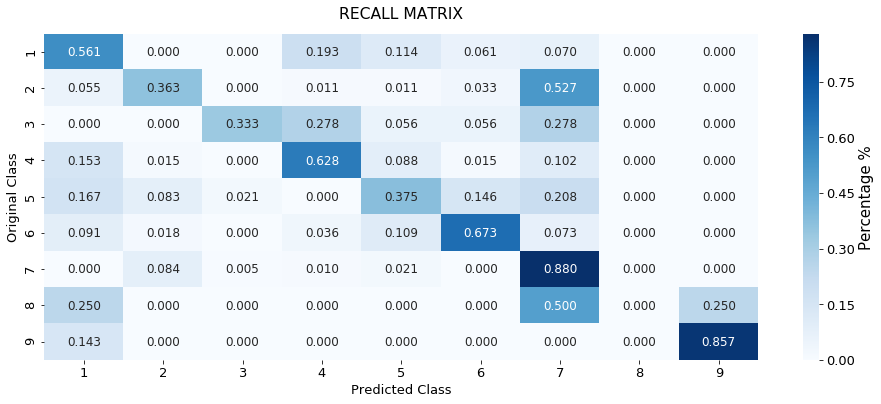

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


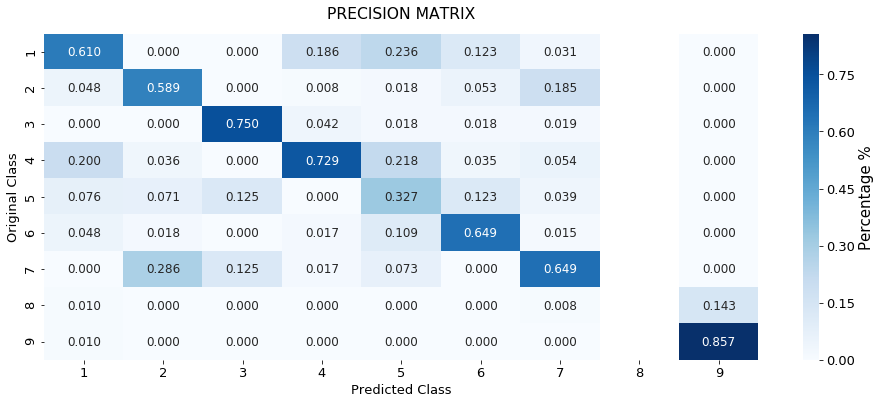

In [169]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(X_tr_oe, y_train_model)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train_model, vclf.predict_proba(X_tr_oe)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv_model, vclf.predict_proba(X_cv_oe)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(X_te_oe)))
print("Number of missclassified point :", np.round(np.count_nonzero((vclf.predict(X_te_oe)- y_test))/y_test.shape[0]*100,2))
plot_confusion_matrix(y_test,vclf.predict(X_te_oe))

In [170]:
del X_tr_oe
del X_te_oe
del X_cv_oe

## TF-IDF top 1000 features

In [171]:
X_tr_oe=X_tr_oe_1000
X_te_oe=X_te_oe_1000
X_cv_oe=X_cv_oe_1000

<h3>Naive Bayes</h3>

<h4>Hyper parameter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
|   1    |    0.83803     |    1.1662   |
+--------+----------------+-------------+
|  0.1   |    0.64019     |   1.16978   |
+--------+----------------+-------------+
|  0.01  |     0.5759     |   1.18849   |
+--------+----------------+-------------+
| 0.001  |    0.54971     |   1.19302   |
+--------+----------------+-------------+
| 0.0001 |    0.53765     |   1.19457   |
+--------+----------------+-------------+
| 1e-05  |    0.52588     |   1.19664   |
+--------+----------------+-------------+
|   10   |    1.06848     |   1.20538   |
+--------+----------------+-------------+
|  100   |     1.1573     |   1.24009   |
+--------+----------------+-------------+


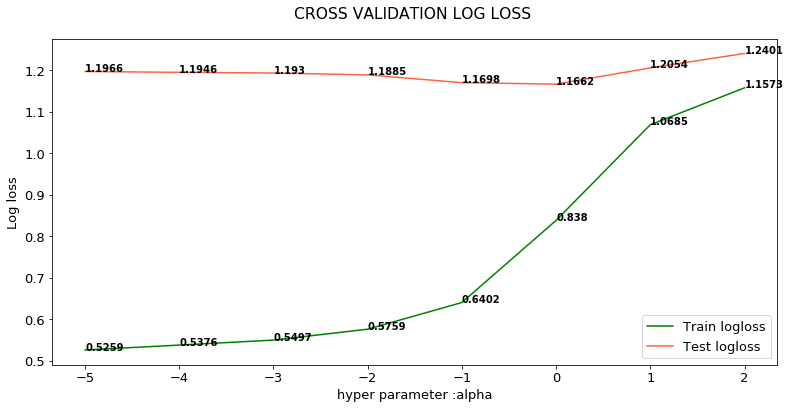

In [172]:
model=MultinomialNB()
alpha_values=[10**i for i in range(-5,3)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing the model with best hyper paramters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.83803     |    1.19993    |    1.1662   |       37.59 %       |
+----------------+---------------+-------------+---------------------+


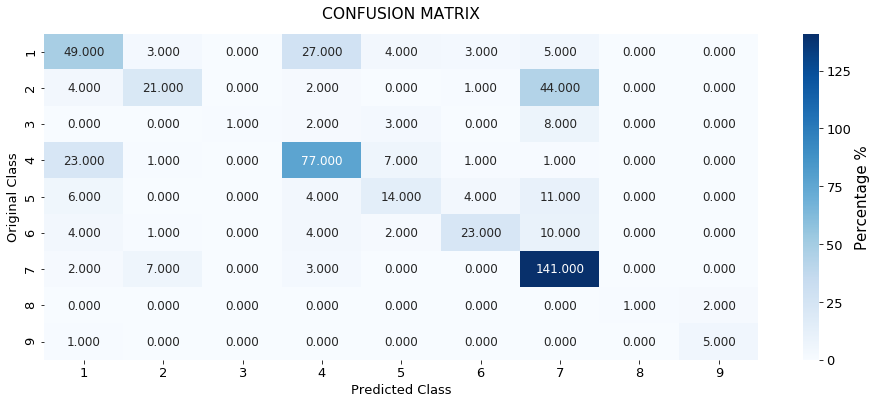

NOTE:-RECALL MATRIX (ROW SUM=1)


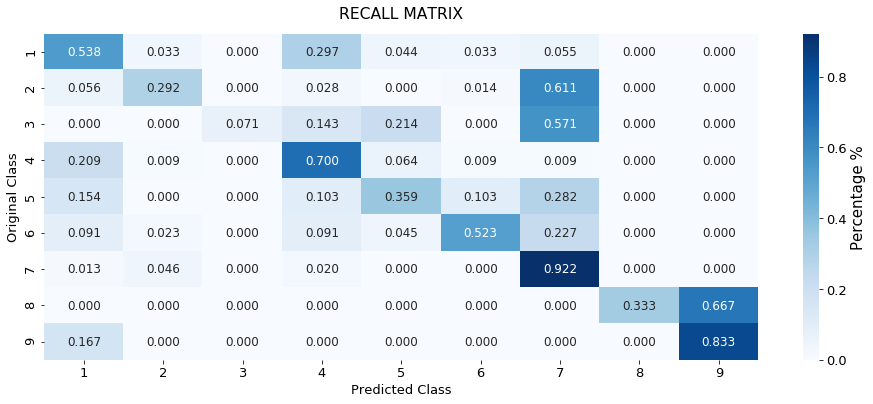

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


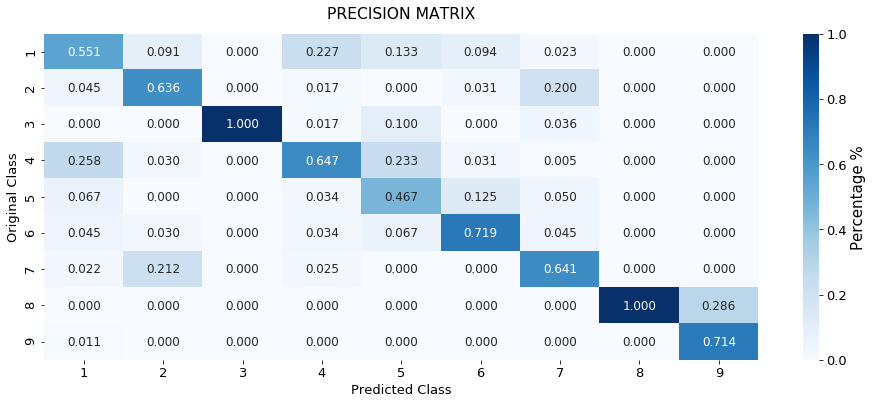

In [173]:
model.alpha=10**0
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h2>Logistic Regression(With Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.0001 |    0.44799     |    1.0312   |
+--------+----------------+-------------+
| 0.001  |    0.70301     |   1.05214   |
+--------+----------------+-------------+
| 1e-05  |    0.51921     |   1.14035   |
+--------+----------------+-------------+
|  0.01  |     0.9898     |   1.19569   |
+--------+----------------+-------------+
|  0.1   |    1.22575     |   1.33329   |
+--------+----------------+-------------+
|   1    |    1.29206     |   1.37203   |
+--------+----------------+-------------+
|   10   |    1.30195     |   1.37933   |
+--------+----------------+-------------+
|  100   |    1.30309     |   1.38028   |
+--------+----------------+-------------+
|  1000  |     1.3033     |   1.38038   |
+--------+----------------+-------------+


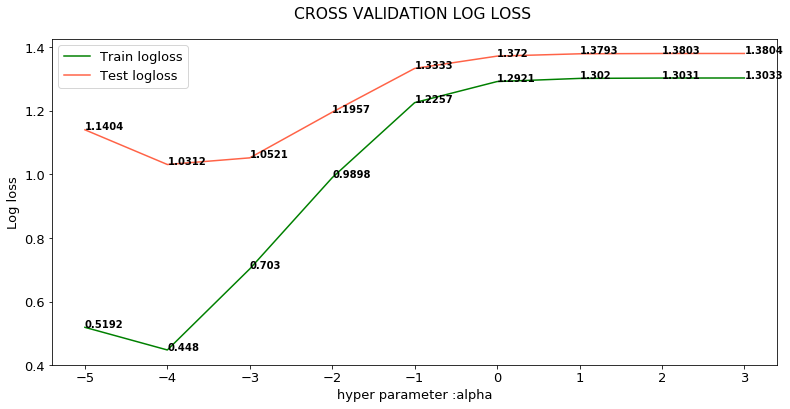

In [174]:
model=SGDClassifier()
model.class_weight='balanced'
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing the model with best hyper paramters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.45237     |    1.03841    |   1.02996   |        35.9 %       |
+----------------+---------------+-------------+---------------------+


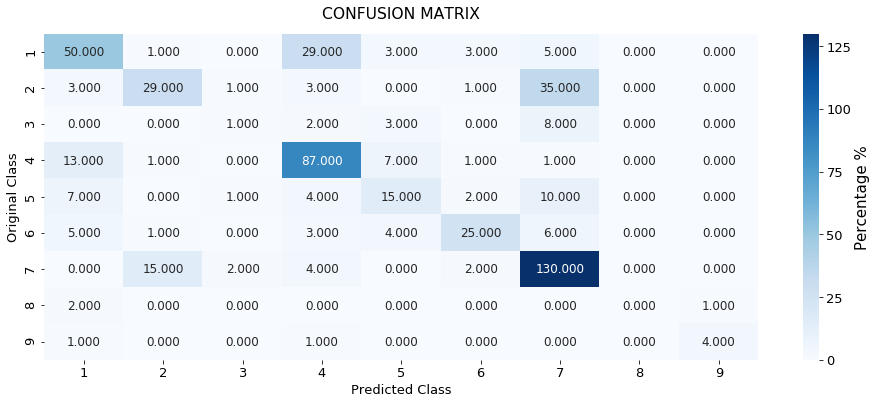

NOTE:-RECALL MATRIX (ROW SUM=1)


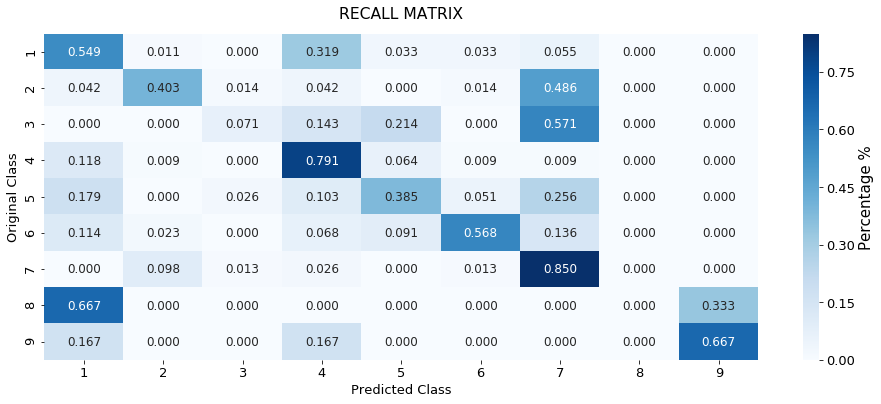

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


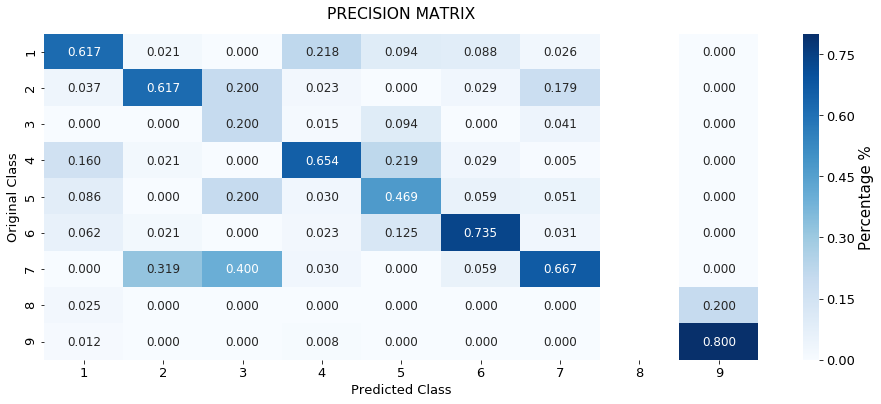

In [175]:
model.alpha=10**-4
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h2>Logistic Regression(With out Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.0001 |    0.42928     |   1.01864   |
+--------+----------------+-------------+
| 0.001  |    0.69221     |   1.04404   |
+--------+----------------+-------------+
| 1e-05  |    0.55902     |   1.17722   |
+--------+----------------+-------------+
|  0.01  |     1.0151     |   1.17891   |
+--------+----------------+-------------+
|  0.1   |    1.19561     |   1.30684   |
+--------+----------------+-------------+
|   1    |    1.25733     |   1.36827   |
+--------+----------------+-------------+
|   10   |    1.26625     |   1.37795   |
+--------+----------------+-------------+
|  100   |    1.26731     |   1.37926   |
+--------+----------------+-------------+
|  1000  |    1.26747     |   1.37944   |
+--------+----------------+-------------+


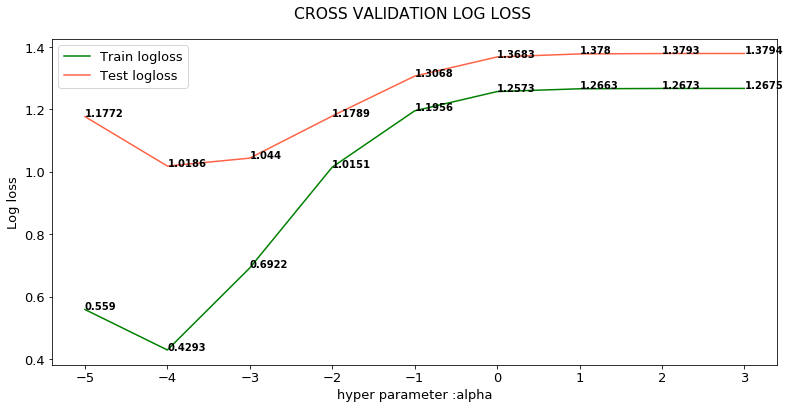

In [176]:
model=SGDClassifier()
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing model with best hyper parameters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.43057     |    1.03153    |   1.02411   |       36.47 %       |
+----------------+---------------+-------------+---------------------+


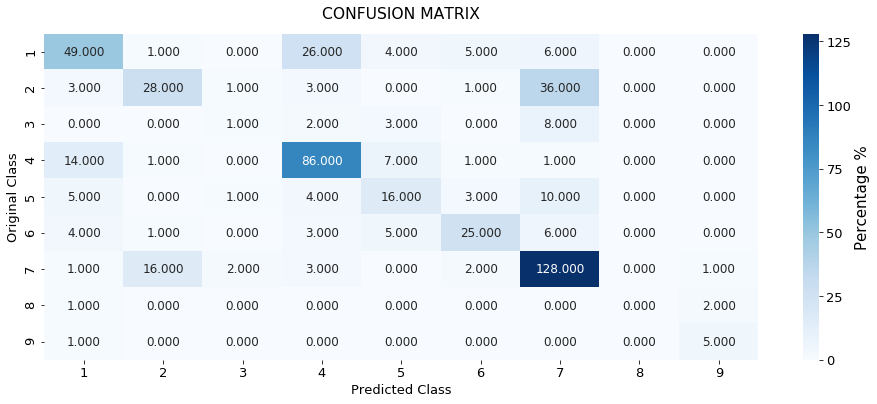

NOTE:-RECALL MATRIX (ROW SUM=1)


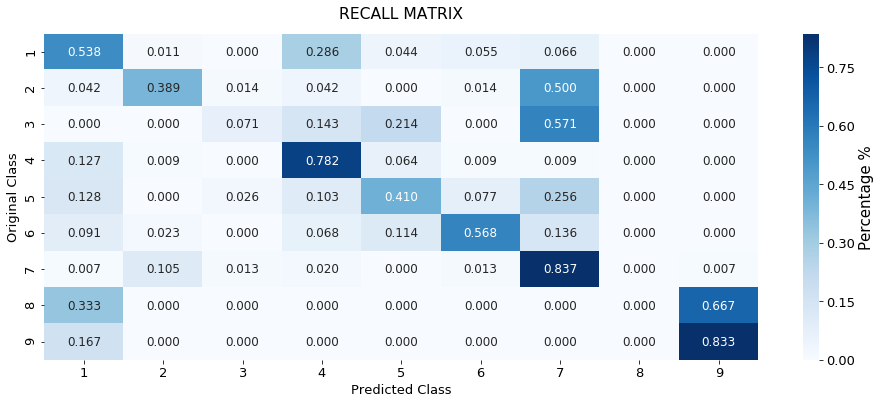

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


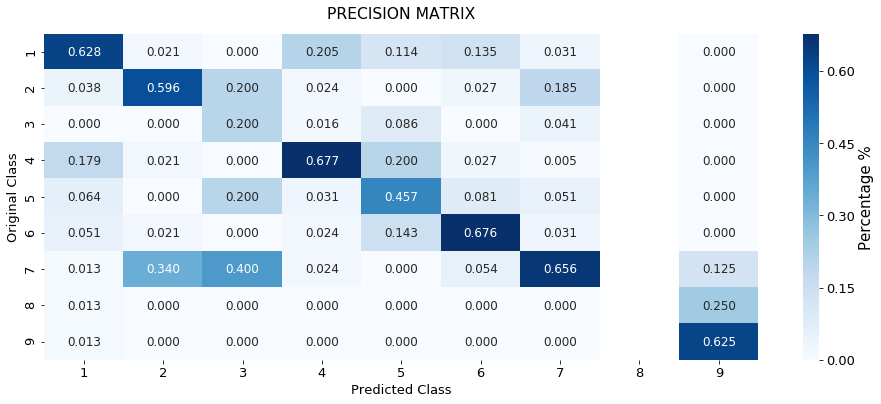

In [177]:
model.alpha=10**-4
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h2>Linear Support Vector Machines</h2>

<h3>Hyper paramter tuning</h3>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.0001 |    0.53005     |   1.15317   |
+--------+----------------+-------------+
| 0.001  |    0.65113     |   1.15666   |
+--------+----------------+-------------+
| 1e-05  |    0.67318     |   1.26222   |
+--------+----------------+-------------+
|  0.01  |     1.0233     |   1.26307   |
+--------+----------------+-------------+
|  0.1   |    1.24419     |   1.31971   |
+--------+----------------+-------------+
|   1    |    1.30297     |   1.38002   |
+--------+----------------+-------------+
|   10   |    1.30348     |    1.3805   |
+--------+----------------+-------------+
|  100   |    1.30348     |    1.3805   |
+--------+----------------+-------------+
|  1000  |    1.30348     |    1.3805   |
+--------+----------------+-------------+


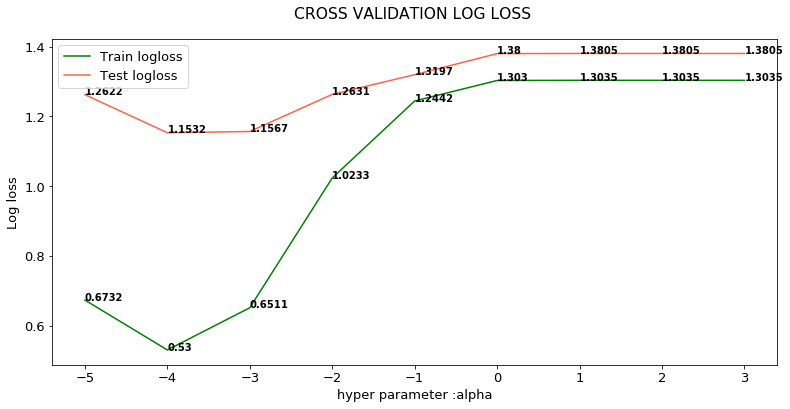

In [178]:
model=SGDClassifier()
model.loss='hinge'
model.class_weight='balanced'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h3>Testing model with best hyper parameters</h3>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.56144     |    1.16909    |    1.1644   |       38.16 %       |
+----------------+---------------+-------------+---------------------+


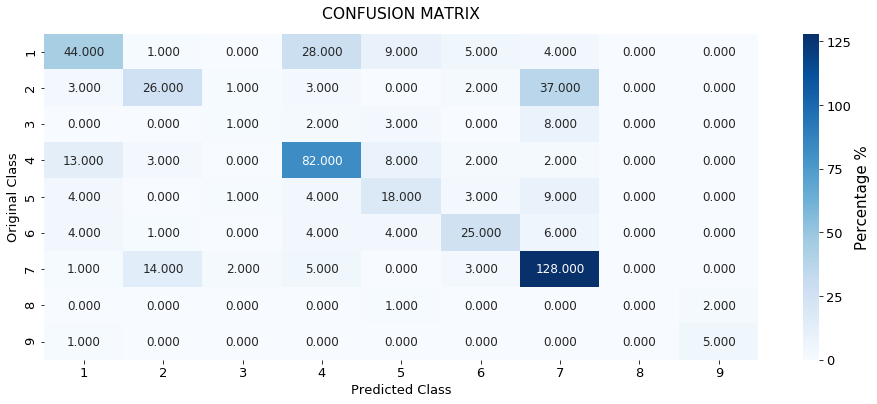

NOTE:-RECALL MATRIX (ROW SUM=1)


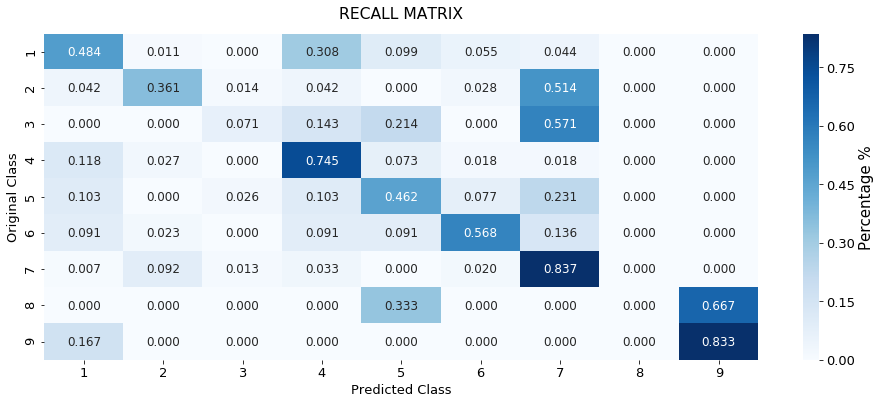

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


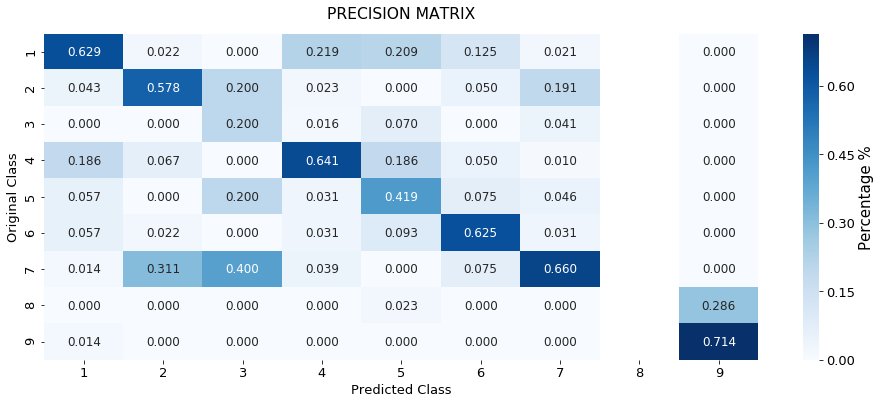

In [179]:
model.alpha=10**-4
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h2>Random Forest Classifier</h2>

<h3>Hyper paramter tuning (With One hot Encoding)</h3>

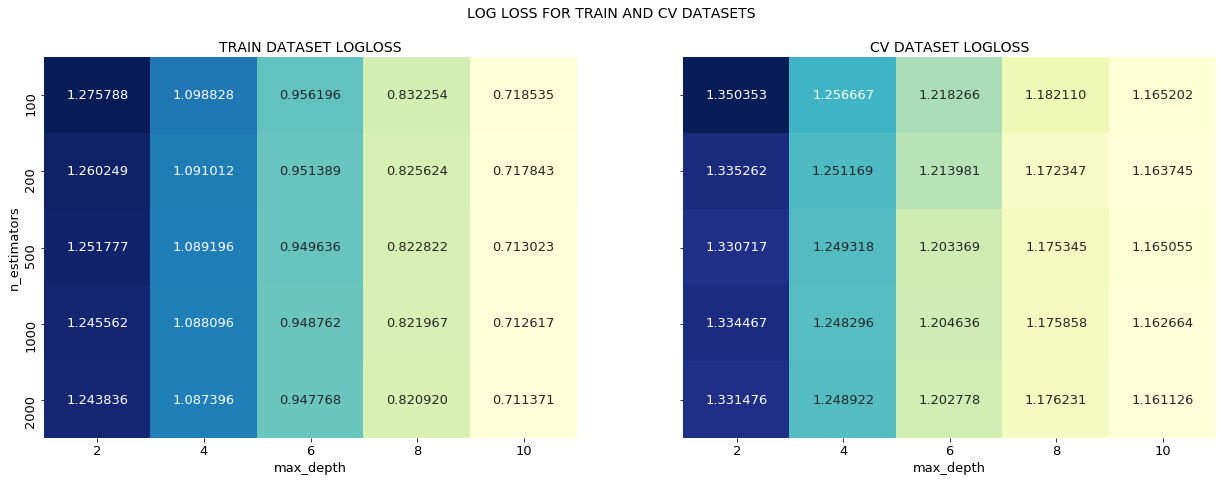

In [180]:
randomforest_hypertuning(X_tr_oe,X_cv_oe)

<h3>Testing model with best hyper parameters (One Hot Encoding)</h3>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.71784     |    1.14897    |   1.16375   |       41.17 %       |
+----------------+---------------+-------------+---------------------+


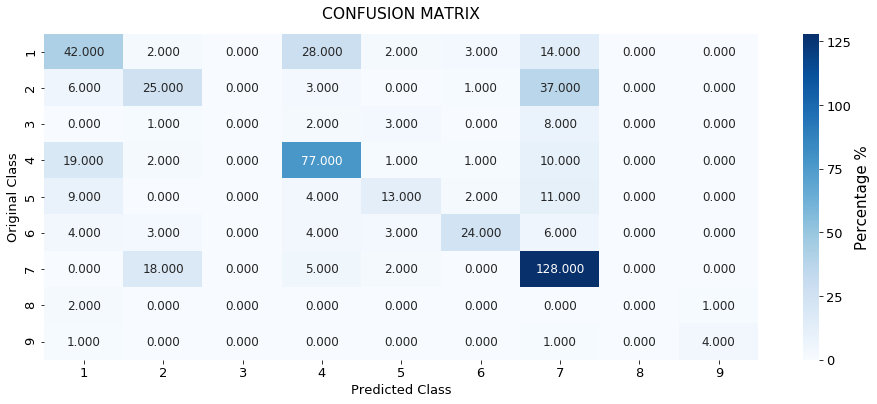

NOTE:-RECALL MATRIX (ROW SUM=1)


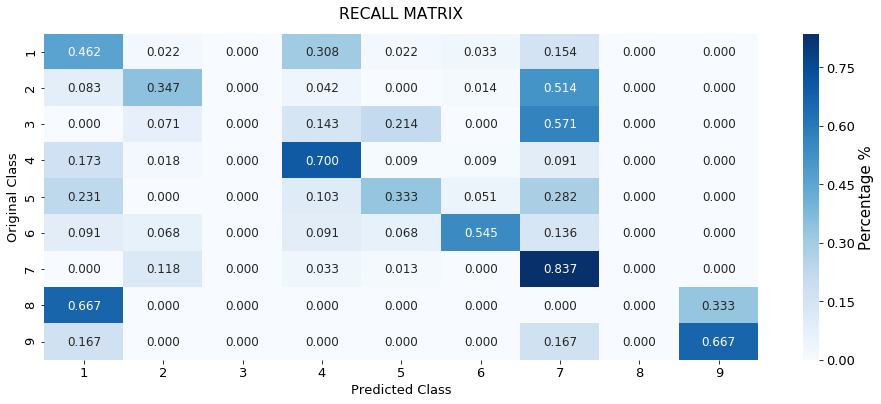

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


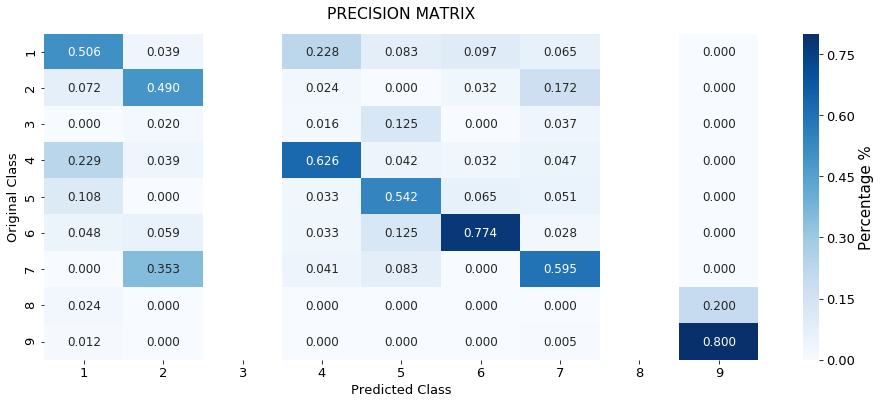

In [181]:
model = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h2>Stack the models </h2>

<h3>testing with hyper parameter tuning</h3>

In [182]:
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(X_tr_oe, y_train_model)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(X_tr_oe, y_train_model)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=1)
clf3.fit(X_tr_oe, y_train_model)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(X_tr_oe, y_train_model)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf1.predict_proba(X_cv_oe))))
sig_clf2.fit(X_tr_oe, y_train_model)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf2.predict_proba(X_cv_oe))))
sig_clf3.fit(X_tr_oe, y_train_model)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv_model, sig_clf3.predict_proba(X_cv_oe))))

print('-'*45)

c_values = [10**i for i in range(-5,5)] 
best_alpha = 999

table = PrettyTable()
table.hrules=True
table.field_names=["C", "Train_log_loss","Cv_Log_Loss"]

for i in tqdm.tqdm_notebook(c_values):
    
    clf= LogisticRegression(C=i)
    
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=clf, use_probas=True)
    sclf.fit(X_tr_oe, y_train_model)
    
    tr_log_loss=np.round(log_loss(y_train_model, sclf.predict_proba(X_tr_oe)),4)
    cv_log_loss=np.round(log_loss(y_cv_model, sclf.predict_proba(X_cv_oe)),4)
    
    table.add_row([i,tr_log_loss,cv_log_loss])

    if best_alpha > cv_log_loss:
        best_alpha = cv_log_loss

table.sortby='Cv_Log_Loss'
print(table)
del table


Logistic Regression :  Log Loss: 1.03
Support vector machines : Log Loss: 1.17
Naive Bayes : Log Loss: 1.17
---------------------------------------------



+--------+----------------+-------------+
|   C    | Train_log_loss | Cv_Log_Loss |
+--------+----------------+-------------+
|  0.1   |     0.4302     |    1.1324   |
+--------+----------------+-------------+
|   1    |     0.1285     |    1.3148   |
+--------+----------------+-------------+
|  0.01  |     1.1699     |    1.4306   |
+--------+----------------+-------------+
|   10   |     0.047      |    1.7405   |
+--------+----------------+-------------+
| 0.001  |     1.9592     |    1.9992   |
+--------+----------------+-------------+
| 0.0001 |      2.17      |    2.1738   |
+--------+----------------+-------------+
| 1e-05  |     2.1945     |    2.1948   |
+--------+----------------+-------------+
|  100   |     0.026      |    2.3367   |
+--------+----------------+-------------+
|  1000  |     0.0196     |    3.116    |
+--------+----------------+-------------+
| 10000  |     0.0167     |    3.9211   |
+--------+----------------+-------------+


<h3>testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.4302034601042464
Log loss (CV) on the stacking classifier : 1.13237016017541
Log loss (test) on the stacking classifier : 1.1505734181961742
Number of missclassified point : 37.59


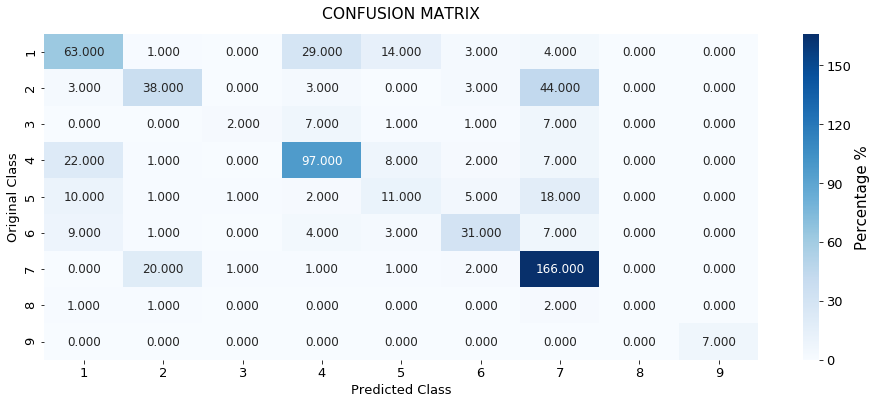

NOTE:-RECALL MATRIX (ROW SUM=1)


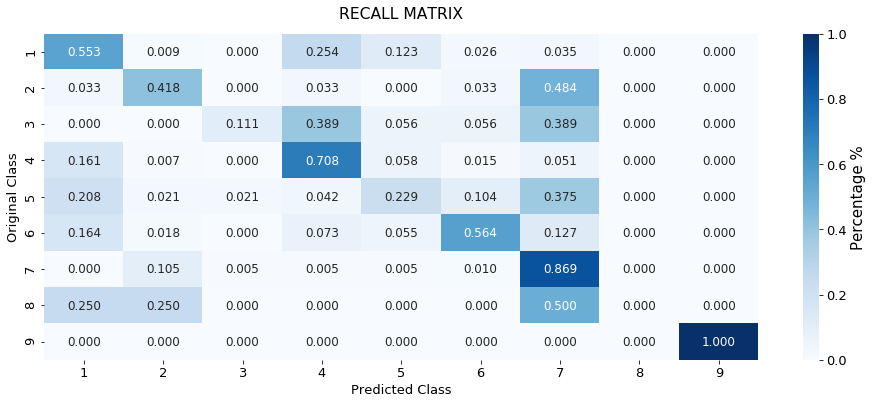

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


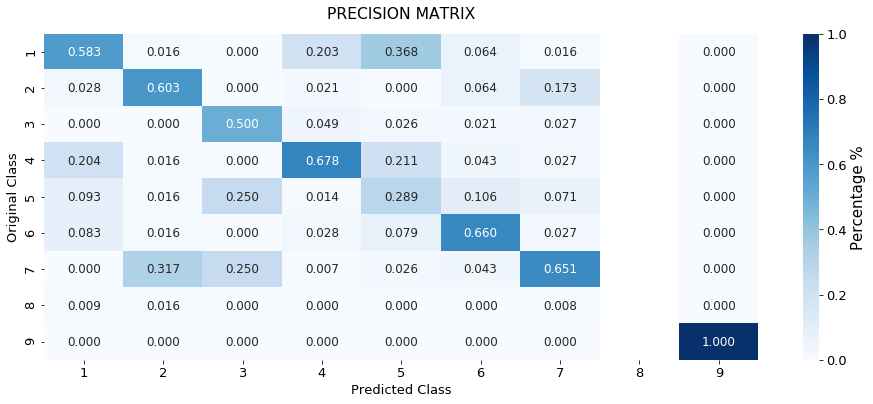

In [183]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(X_tr_oe, y_train_model)

log_error = log_loss(y_train_model, sclf.predict_proba(X_tr_oe))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv_model, sclf.predict_proba(X_cv_oe))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(X_te_oe))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.round(np.count_nonzero((sclf.predict(X_te_oe)- y_test))/y_test.shape[0]*100,2))
plot_confusion_matrix(y_test,sclf.predict(X_te_oe))

<h3>Maximum Voting classifier </h3>

In [185]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(X_tr_oe, y_train_model)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train_model, vclf.predict_proba(X_tr_oe)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv_model, vclf.predict_proba(X_cv_oe)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(X_te_oe)))
print("Number of missclassified point :", np.round(np.count_nonzero((vclf.predict(X_te_oe)- y_test))/y_test.shape[0]*100,2))

Log loss (train) on the VotingClassifier : 0.5568329540215184
Log loss (CV) on the VotingClassifier : 1.0712009922516539
Log loss (test) on the VotingClassifier : 1.0897025365186406
Number of missclassified point : 38.05


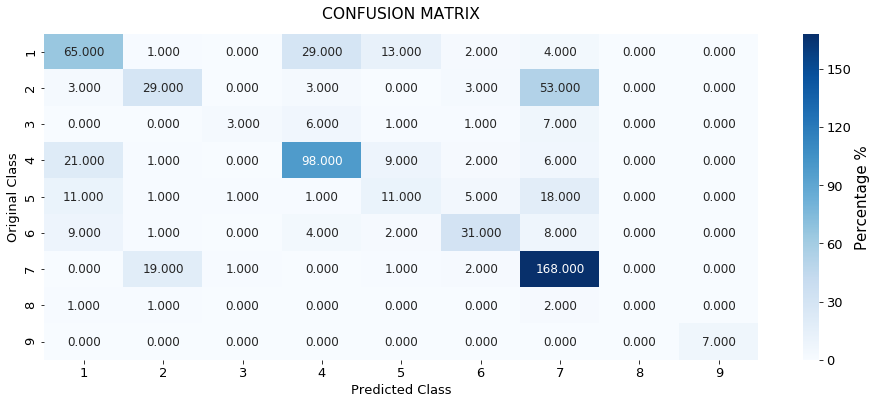

NOTE:-RECALL MATRIX (ROW SUM=1)


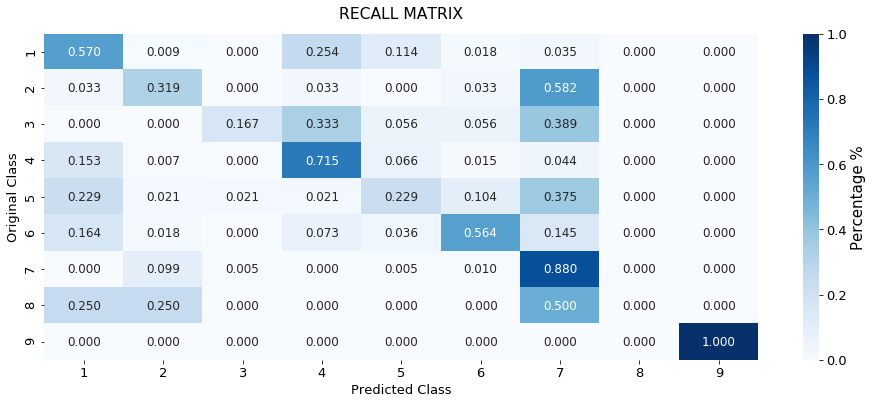

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


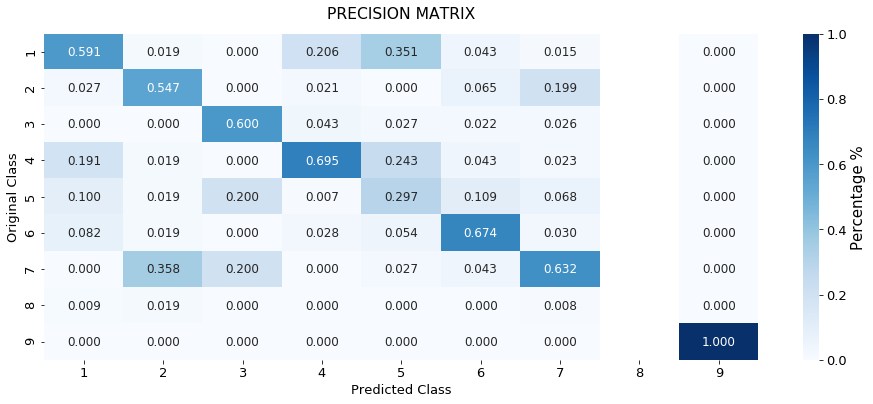

In [186]:
plot_confusion_matrix(y_test,vclf.predict(X_te_oe))

In [187]:
del X_tr_oe
del X_te_oe
del X_cv_oe

## BOW(unigram and bigram)

### Logistci Regression

In [188]:
vectorizer = CountVectorizer(min_df=3,ngram_range=(1,2))
X_tr_text_oe_gram = vectorizer.fit_transform(X_train_model['Text'])

train_text_features= vectorizer.get_feature_names()
# X_tr_text_oe.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = X_tr_text_oe_gram.sum(axis=0).A1
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

# don't forget to normalize every feature
X_tr_text_oe_gram = normalize(X_tr_text_oe_gram, axis=0)

X_te_text_oe_gram = vectorizer.transform(X_test['Text'])
X_te_text_oe_gram = normalize(X_te_text_oe_gram, axis=0)

X_cv_text_oe_gram = vectorizer.transform(X_cv_model['Text'])
X_cv_text_oe_gram = normalize(X_cv_text_oe_gram, axis=0)

Total number of unique words in train data : 769744


In [189]:
X_tr_oe = hstack((X_tr_f,X_tr_text_oe_gram)).tocsr()
X_te_oe = hstack((X_te_f,X_te_text_oe_gram)).tocsr()
X_cv_oe = hstack((X_cv_f,X_cv_text_oe_gram)).tocsr()

print("\nAfter One hot encoding  using BOW(unigram and bigram):\n".upper())
print("train data shape : ", X_tr_oe.shape)
print("test data shape : ", X_te_oe.shape)
print("cross validation data  shape :", X_cv_oe.shape)


AFTER ONE HOT ENCODING  USING BOW(UNIGRAM AND BIGRAM):

train data shape :  (2124, 771934)
test data shape :  (665, 771934)
cross validation data  shape : (532, 771934)



+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
|  0.1   |    0.85727     |   1.23076   |
+--------+----------------+-------------+
|  0.01  |    0.83627     |   1.25126   |
+--------+----------------+-------------+
|   1    |    1.12428     |   1.27823   |
+--------+----------------+-------------+
|   10   |    1.27736     |   1.33817   |
+--------+----------------+-------------+
|  100   |    1.30283     |   1.35532   |
+--------+----------------+-------------+
|  1000  |    1.30569     |    1.3576   |
+--------+----------------+-------------+
| 0.001  |    1.28764     |   1.45288   |
+--------+----------------+-------------+
| 0.0001 |     1.3791     |   1.52536   |
+--------+----------------+-------------+
| 1e-05  |    1.37585     |   1.55615   |
+--------+----------------+-------------+


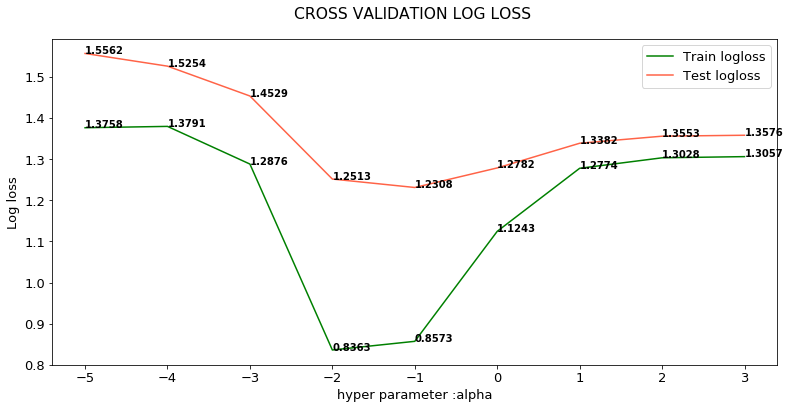

In [190]:
model=SGDClassifier()
model.class_weight='balanced'
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-5,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)


+----------------+---------------+-------------+----------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct  |
+----------------+---------------+-------------+----------------------+
|    0.86253     |    1.21212    |   1.22777   | 41.730000000000004 % |
+----------------+---------------+-------------+----------------------+


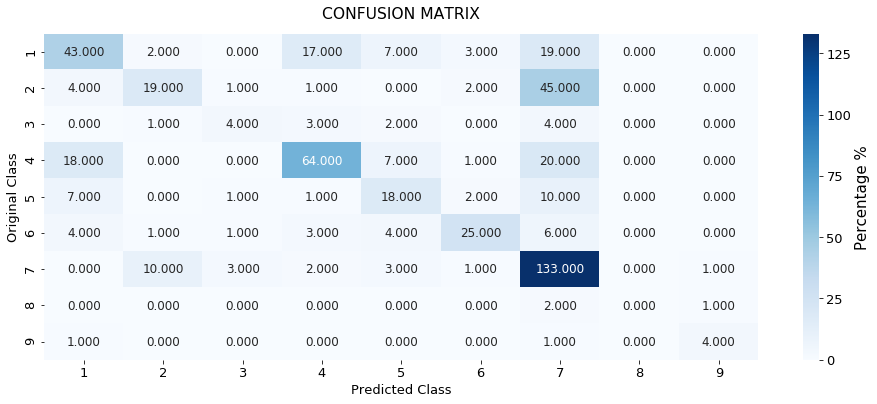

NOTE:-RECALL MATRIX (ROW SUM=1)


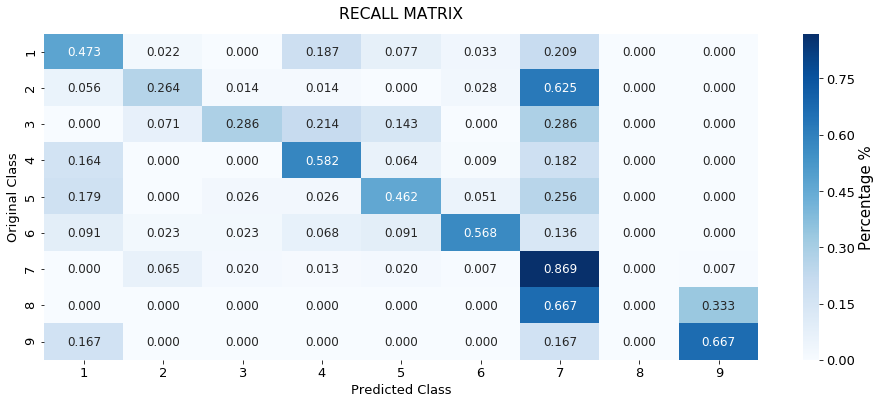

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


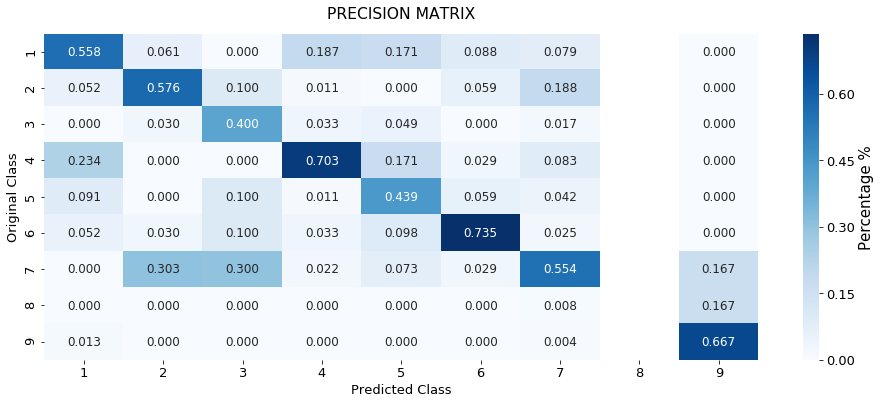

In [191]:
model.alpha=10**-1
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

In [192]:
del X_tr_oe
del X_te_oe
del X_cv_oe

In [193]:
tfvectorizer = TfidfVectorizer(ngram_range=(1,4),min_df = 3,max_features=10000)

X_tr_text_oe_tfidf = tfvectorizer.fit_transform(X_train_model['Text'])
X_te_text_oe_tfidf = tfvectorizer.transform(X_test['Text'])
X_cv_text_oe_tfidf = tfvectorizer.transform(X_cv_model['Text'])

In [194]:
select_best_feat = TruncatedSVD(n_components=9999,random_state=2)

select_best_feat.fit(X_tr_text_oe_tfidf)

TruncatedSVD(algorithm='randomized', n_components=9999, n_iter=5,
       random_state=2, tol=0.0)

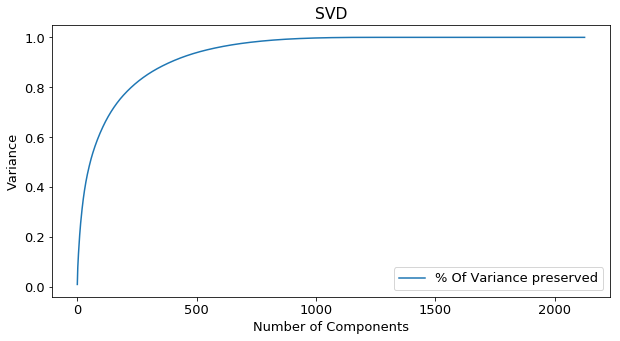

In [195]:
comp_to_variance={}
cum_var_ratio=0.0

for comp,cur_var in enumerate(select_best_feat.explained_variance_ratio_):
    cum_var_ratio+=cur_var
    comp_to_variance[comp+1]=cum_var_ratio
del cum_var_ratio

plt.figure(figsize=(10,5))
plt.plot(list(comp_to_variance.keys()),list(comp_to_variance.values()),label="% Of Variance preserved")
plt.xlabel("Number of Components")
plt.ylabel("Variance")
plt.legend()
plt.title("SVD")
plt.show()

In [196]:
select_best_feat = TruncatedSVD(n_components=700,random_state=2)

select_best_feat.fit(X_tr_text_oe_tfidf)

TruncatedSVD(algorithm='randomized', n_components=700, n_iter=5,
       random_state=2, tol=0.0)

In [197]:
X_tr_tfidf_1000=select_best_feat.transform(X_tr_text_oe_tfidf)
X_te_tfidf_1000=select_best_feat.transform(X_te_text_oe_tfidf)
X_cv_tfidf_1000=select_best_feat.transform(X_cv_text_oe_tfidf)

In [198]:
X_tr_oe_1000 = hstack((X_tr_f,X_tr_tfidf_1000)).tocsr()
X_te_oe_1000 = hstack((X_te_f,X_te_tfidf_1000)).tocsr()
X_cv_oe_1000 = hstack((X_cv_f,X_cv_tfidf_1000)).tocsr()

print("\nAfter One hot encoding  using tfidf top 1000 features:\n".upper())
print("train data shape : ", X_tr_oe_1000.shape)
print("test data shape : ", X_te_oe_1000.shape)
print("cross validation data  shape :", X_cv_oe_1000.shape)


AFTER ONE HOT ENCODING  USING TFIDF TOP 1000 FEATURES:

train data shape :  (2124, 2890)
test data shape :  (665, 2890)
cross validation data  shape : (532, 2890)


In [199]:
X_tr_oe=X_tr_oe_1000
X_te_oe=X_te_oe_1000
X_cv_oe=X_cv_oe_1000

<h2>K Nearest Neighbour Classification</h2>


+-------------+----------------+-------------+
| N_NEIGHBORS | train_log_loss | cv_log_loss |
+-------------+----------------+-------------+
|      5      |    0.90411     |   1.13744   |
+-------------+----------------+-------------+
|      11     |    1.00398     |   1.16818   |
+-------------+----------------+-------------+
|      15     |    1.04814     |   1.18755   |
+-------------+----------------+-------------+
|      21     |     1.1026     |   1.21576   |
+-------------+----------------+-------------+
|      31     |    1.15179     |   1.24538   |
+-------------+----------------+-------------+
|      41     |     1.1847     |   1.26583   |
+-------------+----------------+-------------+
|      51     |    1.21038     |   1.28597   |
+-------------+----------------+-------------+
|      99     |    1.26136     |   1.31565   |
+-------------+----------------+-------------+


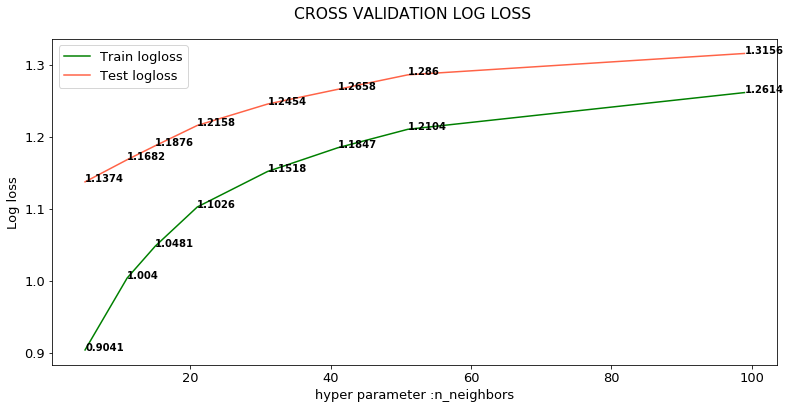

In [200]:
model=KNeighborsClassifier()
model.n_jobs=-1
k_values=[5, 11, 15, 21, 31, 41, 51, 99]
plot_log_loss(model,'n_neighbors',k_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,False)

+----------------+---------------+-------------+----------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct  |
+----------------+---------------+-------------+----------------------+
|    0.49726     |    1.08503    |   1.07563   | 35.339999999999996 % |
+----------------+---------------+-------------+----------------------+


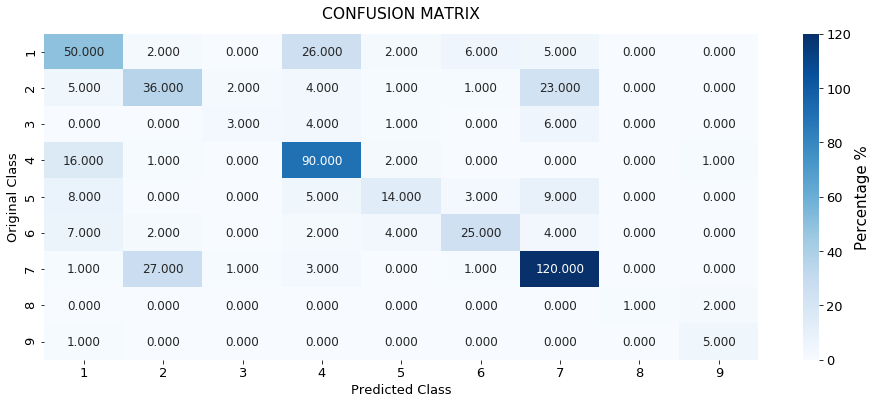

NOTE:-RECALL MATRIX (ROW SUM=1)


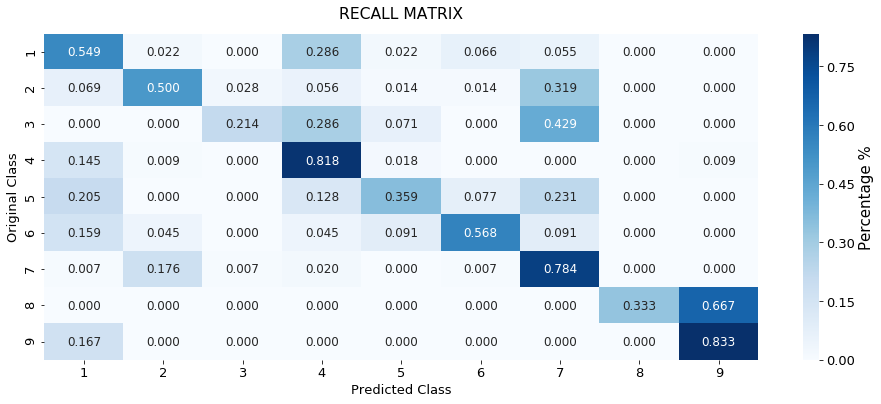

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


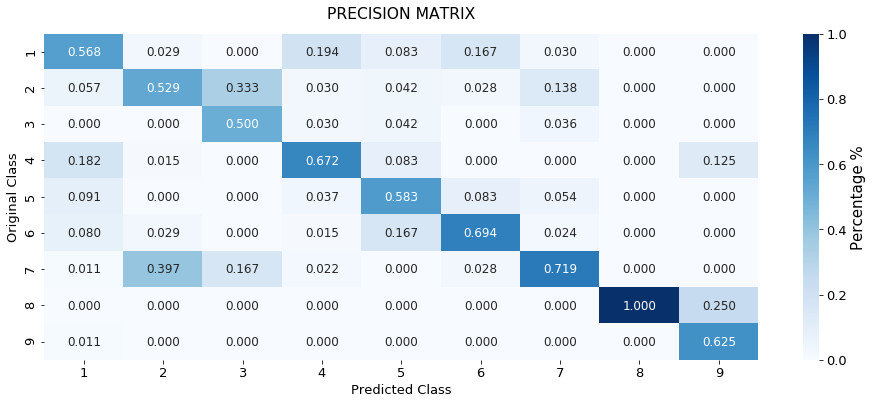

In [201]:
model.n_neighbors=5
build_best_model(model,X_tr_re,y_train_model,X_te_re,y_test,X_cv_re,y_cv_model,True)

<h2>Logistic Regression(With Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.0001 |    0.44738     |   0.99078   |
+--------+----------------+-------------+
| 0.001  |    0.67837     |   1.03128   |
+--------+----------------+-------------+
| 1e-05  |    0.49933     |    1.0991   |
+--------+----------------+-------------+
| 1e-06  |    0.60638     |   1.17986   |
+--------+----------------+-------------+
|  0.01  |    1.01355     |   1.19156   |
+--------+----------------+-------------+
|  0.1   |    1.30397     |   1.37877   |
+--------+----------------+-------------+
|   1    |    1.40556     |   1.45482   |
+--------+----------------+-------------+
|   10   |     1.4198     |   1.46639   |
+--------+----------------+-------------+
|  100   |    1.42181     |   1.46802   |
+--------+----------------+-------------+
|  1000  |    1.42214     |   1.46829   |
+--------+----------------+-------------+


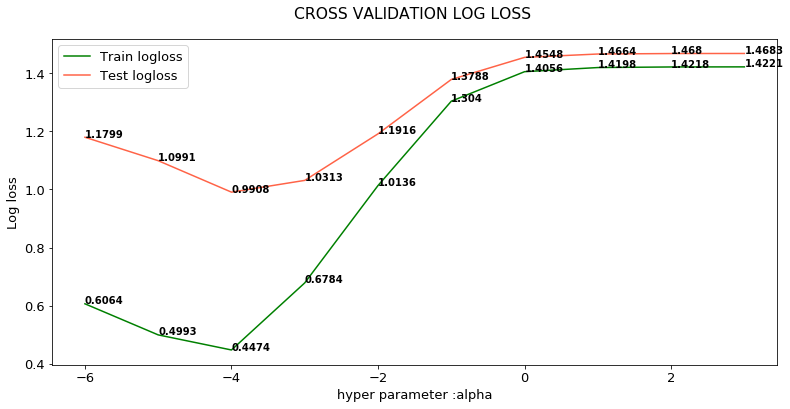

In [202]:
model=SGDClassifier()
model.class_weight='balanced'
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-6,4)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing the model with best hyper paramters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.44756     |    0.98735    |   0.98843   |        34.4 %       |
+----------------+---------------+-------------+---------------------+


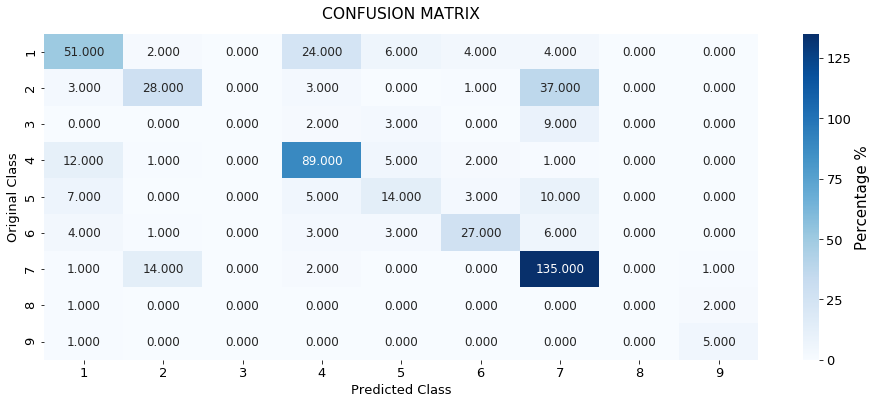

NOTE:-RECALL MATRIX (ROW SUM=1)


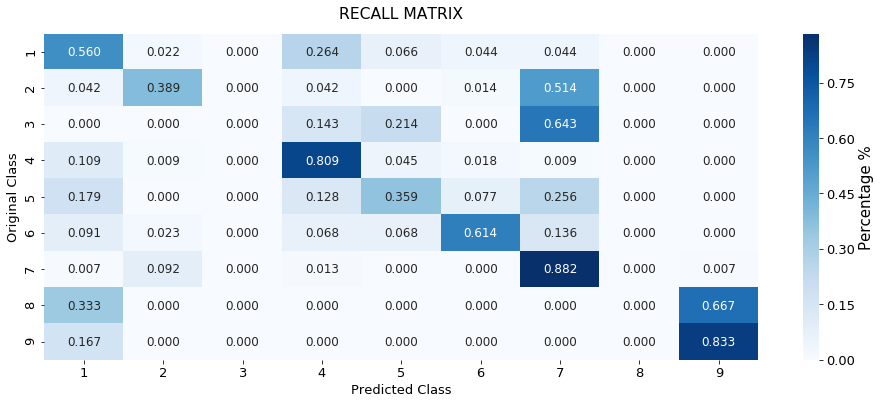

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


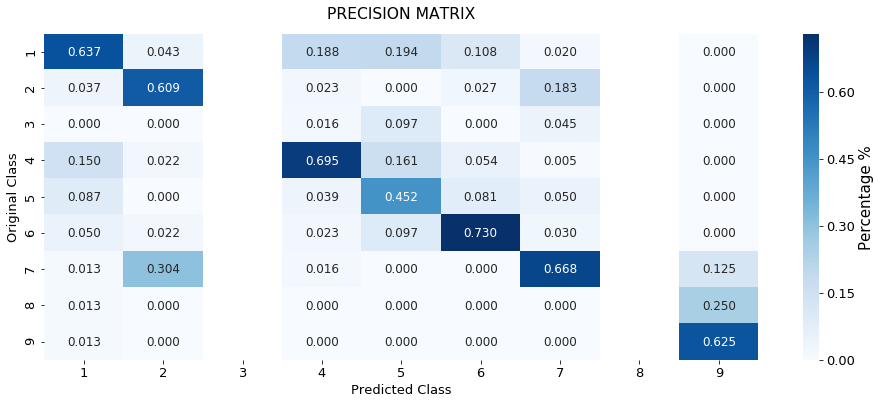

In [206]:
model.alpha=10**-4
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

<h2>Logistic Regression(With out Class balancing)</h2>

<h4>Hyper paramter tuning</h4>


+--------+----------------+-------------+
| ALPHA  | train_log_loss | cv_log_loss |
+--------+----------------+-------------+
| 0.0001 |    0.43281     |   0.99024   |
+--------+----------------+-------------+
| 0.001  |    0.67496     |   1.03078   |
+--------+----------------+-------------+
| 1e-05  |    0.54867     |   1.12141   |
+--------+----------------+-------------+
|  0.01  |    1.03389     |   1.19197   |
+--------+----------------+-------------+
| 1e-06  |    0.62296     |    1.2013   |
+--------+----------------+-------------+
|  0.1   |    1.26438     |   1.35063   |
+--------+----------------+-------------+
|   1    |    1.36095     |   1.42871   |
+--------+----------------+-------------+
|   10   |    1.37388     |   1.43945   |
+--------+----------------+-------------+
|  100   |    1.37565     |   1.44088   |
+--------+----------------+-------------+
|  1000  |    1.37598     |   1.44129   |
+--------+----------------+-------------+
| 10000  |    1.37864     |   1.4

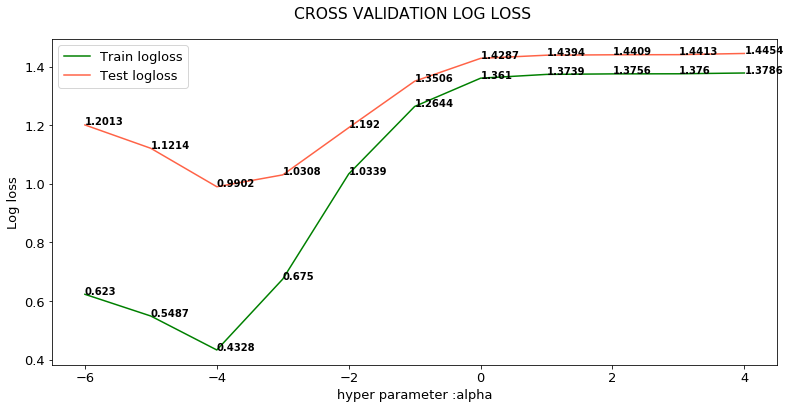

In [207]:
model=SGDClassifier()
model.loss='log'
model.penalty='l2'
alpha_values=[10**i for i in range(-6,5)]
plot_log_loss(model,'alpha',alpha_values,X_tr_oe,y_train_model,X_cv_oe,y_cv_model,True)

<h4>Testing model with best hyper parameters</h4>

+----------------+---------------+-------------+---------------------+
| Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | Miss_classified_pct |
+----------------+---------------+-------------+---------------------+
|    0.43184     |    0.99003    |   0.98173   |       34.77 %       |
+----------------+---------------+-------------+---------------------+


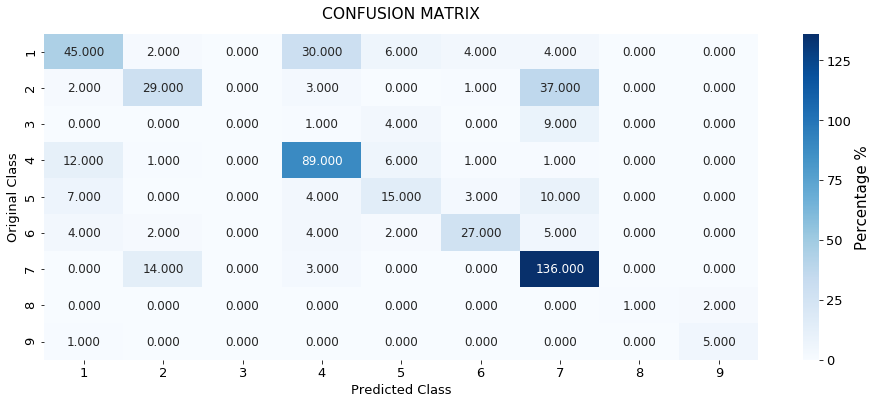

NOTE:-RECALL MATRIX (ROW SUM=1)


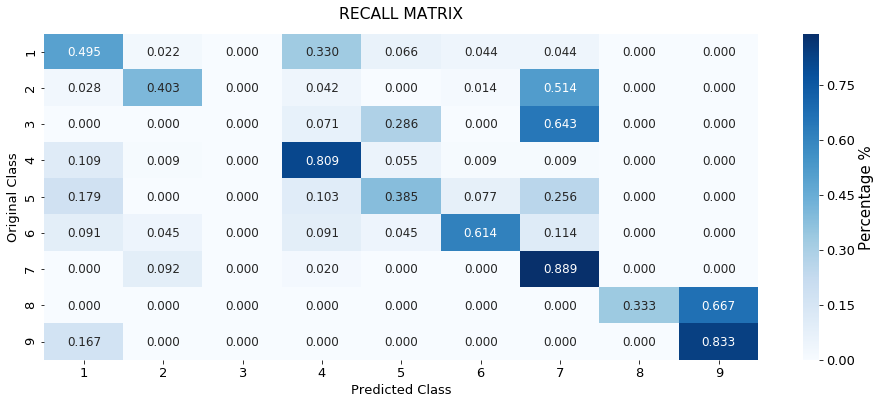

NOTE:-PRECISION MATRIX (COLUMM SUM=1)


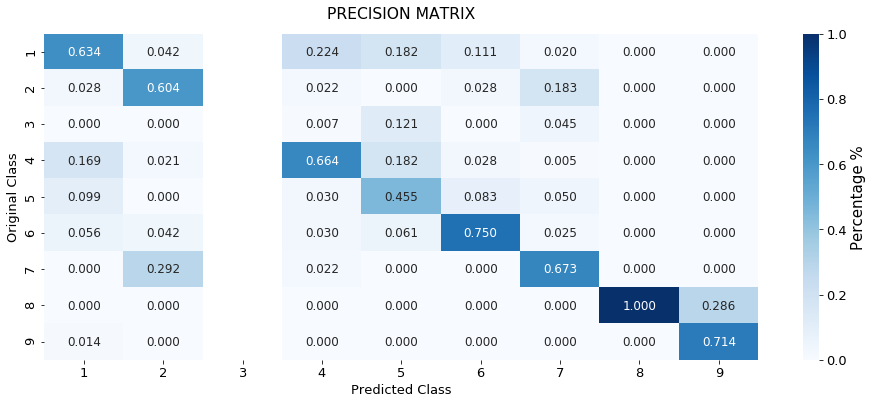

In [208]:
model.alpha=10**-4
build_best_model(model,X_tr_oe,y_train_model,X_te_oe,y_test,X_cv_oe,y_cv_model,True)

## summary

In [215]:
summary_table = PrettyTable()
summary_table.hrules=True
summary_table.field_names=['Model',"vectorizer",'Encoding',"Train_Log_Loss", "Test_Log_Loss","Cv_Log_Loss","mis_cls_pct"]

summary_table.add_row(['MultinomialNB','BOW','OHE',0.919,1.267,1.294,39.85])
summary_table.add_row(['KNN','BOW','RE',0.63884,1.1065,1.0584,37.03])
summary_table.add_row(['Logistic Regression(balanced)','BOW','OHE',0.62533,1.09768,1.11214,34.96])
summary_table.add_row(['Logistic Regression','BOW','OHE',0.61942,1.12616,1.11228,36.84])
summary_table.add_row(['Linear SVM','BOW','OHE',0.75829,1.16085,1.15664,34.5])
summary_table.add_row(['Random Forest','BOW','OHE',0.70752,1.16355,1.18692,41.17])
summary_table.add_row(['Random Forest','BOW','RE',0.04185,1.13625,1.133606,49.25])
summary_table.add_row(['Stacking classifier','BOW','OHE',0.6546,1.1366,1.1334,37.44])
summary_table.add_row(['Voting classifier','BOW','OHE',0.729,1.106,1.093,36.09])

summary_table.add_row(['MultinomialNB','TFIDF','OHE',0.888,1.28762,1.28537,38.53])
summary_table.add_row(['Logistic Regression(balanced)','TFIDF','OHE',0.58196,1.06037,1.09763,36.09])
summary_table.add_row(['Logistic Regression','TFIDF','OHE',0.56922,1.08154,1.11758,37.22])
summary_table.add_row(['Linear SVM','TFIDF','OHE',0.728,1.3529,1.16297,35.70])
summary_table.add_row(['Random Forest','TFIDF','OHE',0.65706,1.15383,1.18955,41.54])
summary_table.add_row(['Stacking classifier','TFIDF','OHE',0.614,1.1333,1.137,37.74])
summary_table.add_row(['Voting classifier','TFIDF','OHE',0.6964,1.0875,1.0833,37.14])

summary_table.add_row(['MultinomialNB','TFIDF(top1000)','OHE',0.83803,1.19993,1.1662,37.59])
summary_table.add_row(['Logistic Regression(balanced)','TFIDF(top1000)','OHE',0.45237,1.03841,1.02996,35.90])
summary_table.add_row(['Logistic Regression','TFIDF(top1000)','OHE',0.43057,1.103153,1.02411,36.47])
summary_table.add_row(['Linear SVM','TFIDF(top1000)','OHE',0.56144,1.16909,1.1644,38.16])
summary_table.add_row(['Random Forest','TFIDF(top1000)','OHE',0.71784,1.14897,1.16375,41.17])
summary_table.add_row(['Stacking classifier','TFIDF(top1000)','OHE',0.4362,1.1505,1.1323,37.59])
summary_table.add_row(['Voting classifier','TFIDF(top1000)','OHE',0.55,1.0897,1.0712,38.05])


summary_table.add_row(['Logistic Regression','BOW(UNI &BIGRAM)','OHE',0.86253,1.21212,1.2277,41.73])

summary_table.add_row(['KNN(balanced)','TFIDF(FE)','OHE',0.49726,1.08503,1.07563,35.33])
summary_table.add_row(['Logistic Regression(balanced)','TFIDF(FE)','OHE',0.44756,0.98755,0.98843,34.4])
summary_table.add_row(['Logistic Regression','TFIDF(FE)','OHE',0.43184,0.99003,0.98173,34.77])



summary_table.sortby='Cv_Log_Loss'
print(summary_table)


+-------------------------------+------------------+----------+----------------+---------------+-------------+-------------+
|             Model             |    vectorizer    | Encoding | Train_Log_Loss | Test_Log_Loss | Cv_Log_Loss | mis_cls_pct |
+-------------------------------+------------------+----------+----------------+---------------+-------------+-------------+
|      Logistic Regression      |    TFIDF(FE)     |   OHE    |    0.43184     |    0.99003    |   0.98173   |    34.77    |
+-------------------------------+------------------+----------+----------------+---------------+-------------+-------------+
| Logistic Regression(balanced) |    TFIDF(FE)     |   OHE    |    0.44756     |    0.98755    |   0.98843   |     34.4    |
+-------------------------------+------------------+----------+----------------+---------------+-------------+-------------+
|      Logistic Regression      |  TFIDF(top1000)  |   OHE    |    0.43057     |    1.103153   |   1.02411   |    36.47    |
